Project Contributors:
1.   Muhammad Khaled Hamza -> (Smart)    [mkldhz99@gmail.com]
2.   Yousef Khaled El-Geushy -> (Smart)        [yousefkhaled2899@gmail.com]
3.   Mohamed Ali Kamal -> (Smart)        [engmohammedali96@gmail.com]
4.   Sherif El-Sayed Sherif -> (Smart)   [shrifsayed637@yahoo.com]
5.   Ashrf Ehab -> (Smart)               [ashrf28396@gmail.com]
6.   Mohamed Alaa Eldin -> (New Capital) [malaaeldin21@gmail.com]




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from prophet import Prophet
import xgboost as xgb



from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf




import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [ ]:
data = pd.read_csv('/content/airline-passengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

In [ ]:
data.shape

(144, 1)

In [ ]:
data.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

# Data Visualization

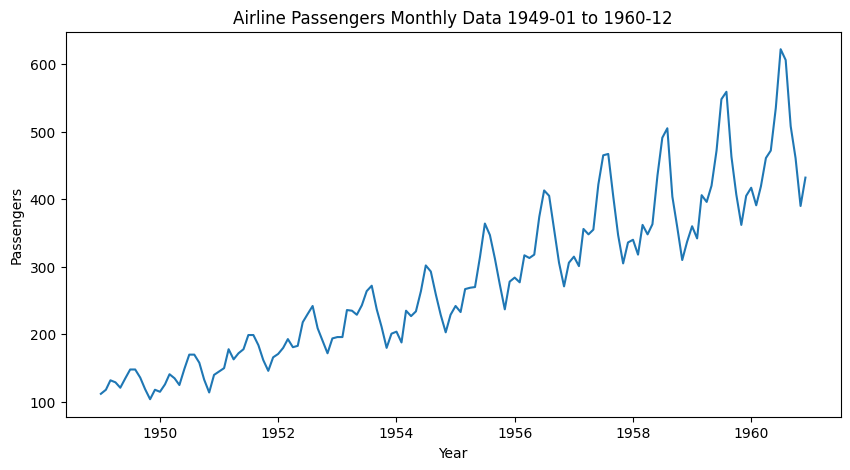

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data)
plt.title('Airline Passengers Monthly Data 1949-01 to 1960-12')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()

The data seems to have an upward trend, and high seasonality. Let's investigate this further 

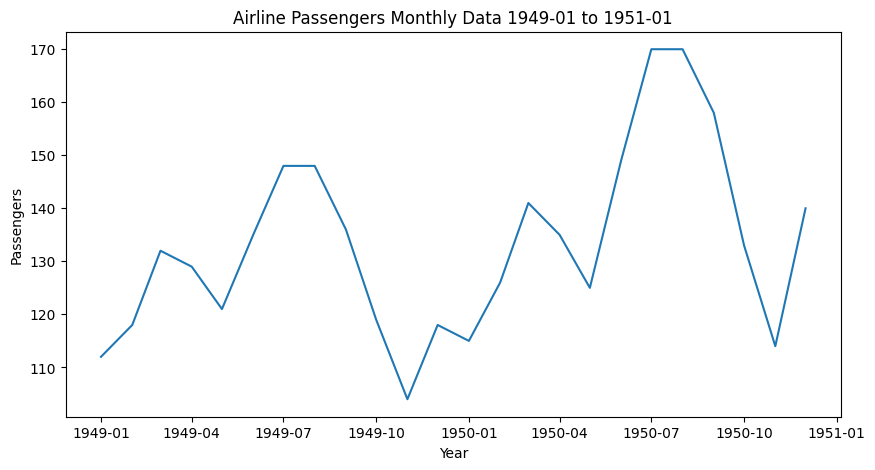

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data[:24])
plt.title('Airline Passengers Monthly Data 1949-01 to 1951-01')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()

The data seems to peak at months from July to August, which makes sense as more people would want to travel during summertime

# Helper Functions

In [ ]:
def fixed_partition(data, test_size):
  df_train = data[ : -test_size]
  df_test = data[-test_size : ]
  return df_train, df_test

In [ ]:
def roll_forward(data, window_size, test_size):
    num_folds = len(data) - window_size - test_size + 1
    for i in range(num_folds):
        train_start = 0
        train_end = i + window_size
        test_start = train_end
        test_end = test_start + test_size

        df_train = data.iloc[train_start:train_end]
        df_test = data.iloc[test_start:test_end]

        yield df_train, df_test

In [ ]:
def cross_validation(data, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for i, (train_index, test_index) in enumerate(tscv.split(data)):
        train_size = int((i+1)/n_splits * len(data))
        if i == n_splits-1:
            train_size = len(data) - len(test_index)
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        splits.append((train_data, test_data))
    return splits

In [ ]:
def RMSE(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

# 1 - Simple Moving Average

In [ ]:
def moving_average(data, window_size):
  return data.rolling(window_size).mean()

## Fixed

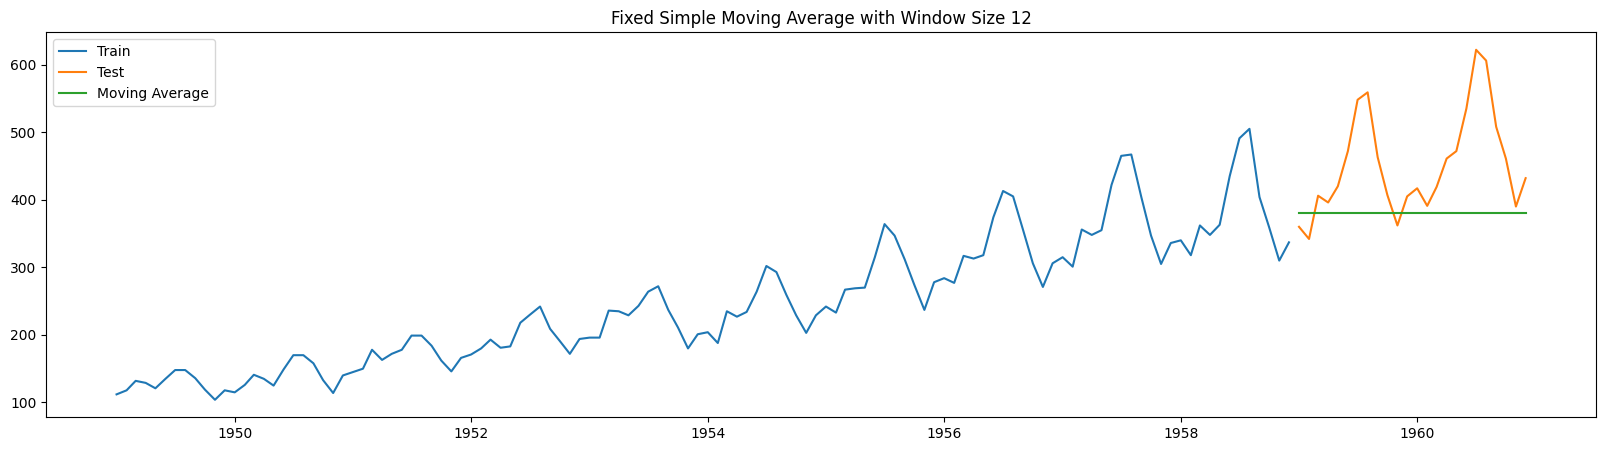

RMSE = 113.81662807511427


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

# moving average with window 12
ma_window_size = 12
ma = moving_average(train_data, ma_window_size)

test_data['ma'] = ma['Passengers'].iloc[-1]

# plotting results
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, test_data['ma'], label='Moving Average')
plt.title(f'Fixed Simple Moving Average with Window Size {ma_window_size}')
plt.legend(loc='best')
plt.show()
print("RMSE =", RMSE(test_data['Passengers'], ma[-test_size:]))

## Roll Forward

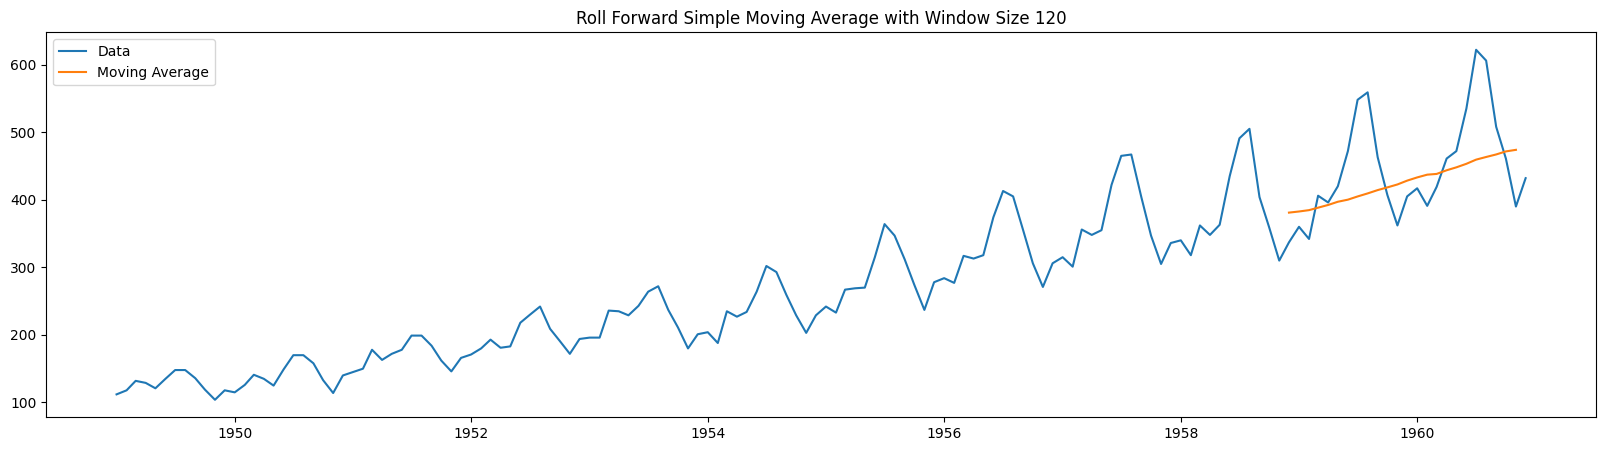

RMSE = 55.388888888888886


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
moving_average_window_size = 12
ma_data = pd.DataFrame()
rmse_list = []

for df_train, df_test in roll_forward(data, rf_window_size, test_size):
    ma = moving_average(df_train, moving_average_window_size)
    ma_data = ma_data.append(ma[-test_size:])
    rmse_list.append(RMSE(df_test['Passengers'], ma_data[-test_size:]))

plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(ma_data, label='Moving Average')
plt.title(f'Roll Forward Simple Moving Average with Window Size {rf_window_size}')
plt.legend(loc='best')
plt.show()

print("RMSE =", np.mean(rmse_list))

## Cross Validation

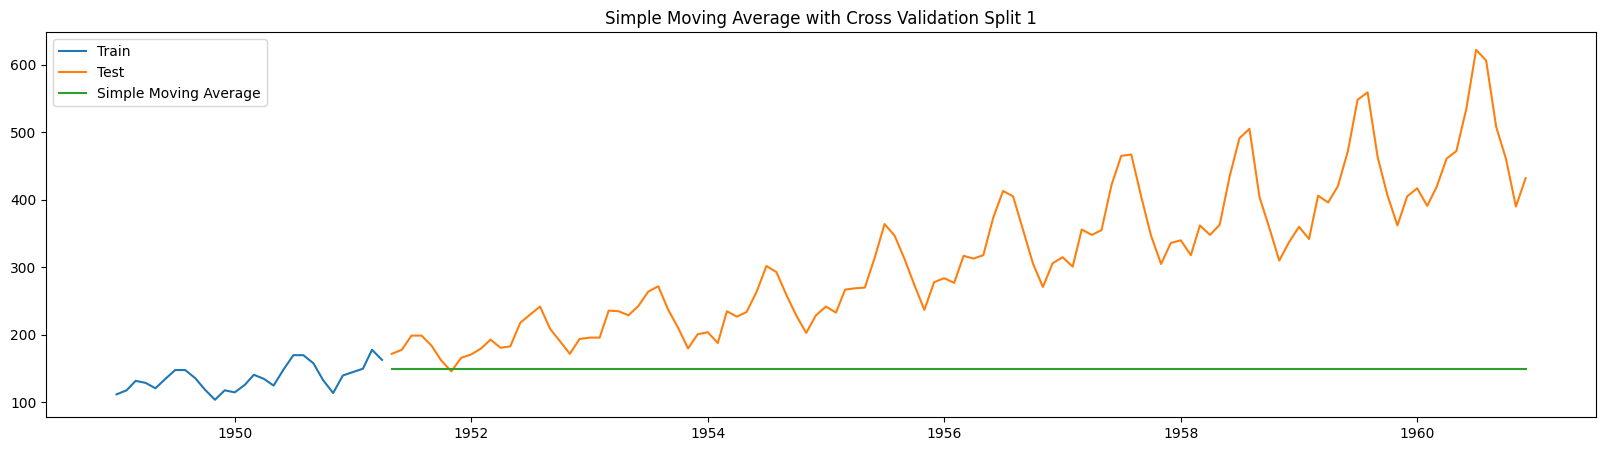

RMSE at Split 1 = 197.04575958322928


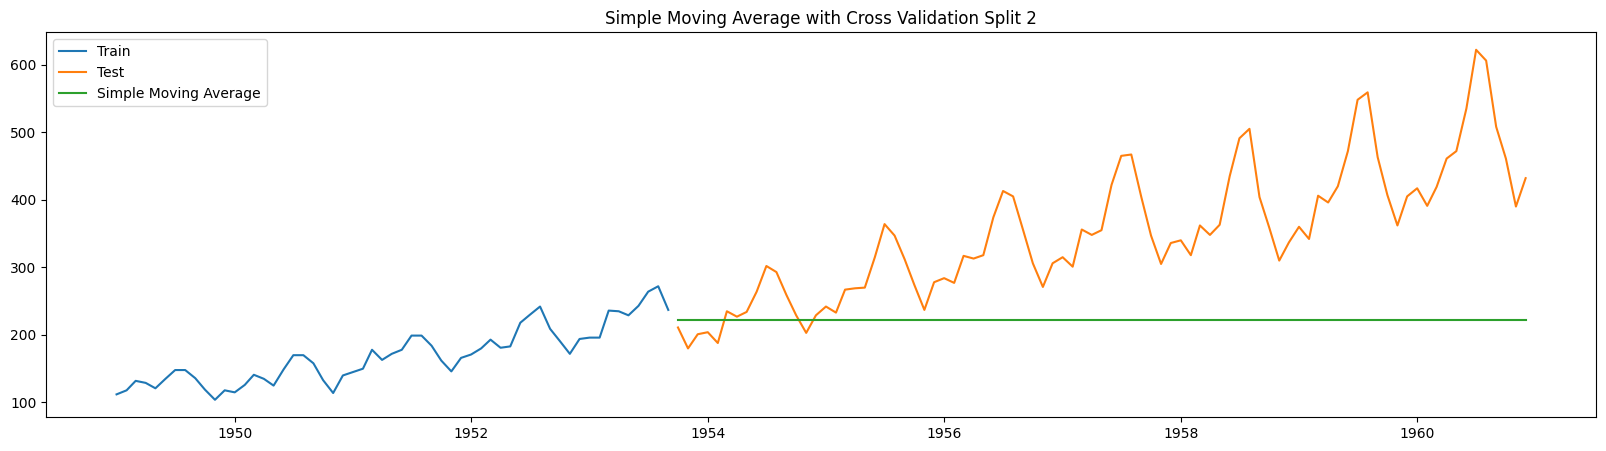

RMSE at Split 2 = 162.35040048707663


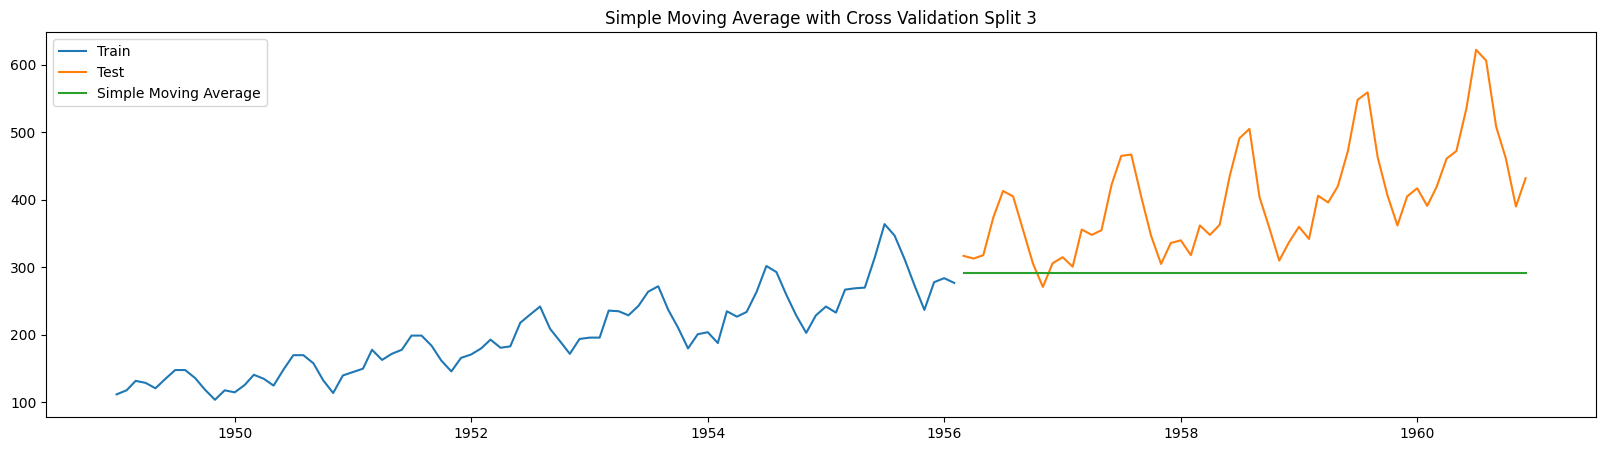

RMSE at Split 3 = 134.49515722882984


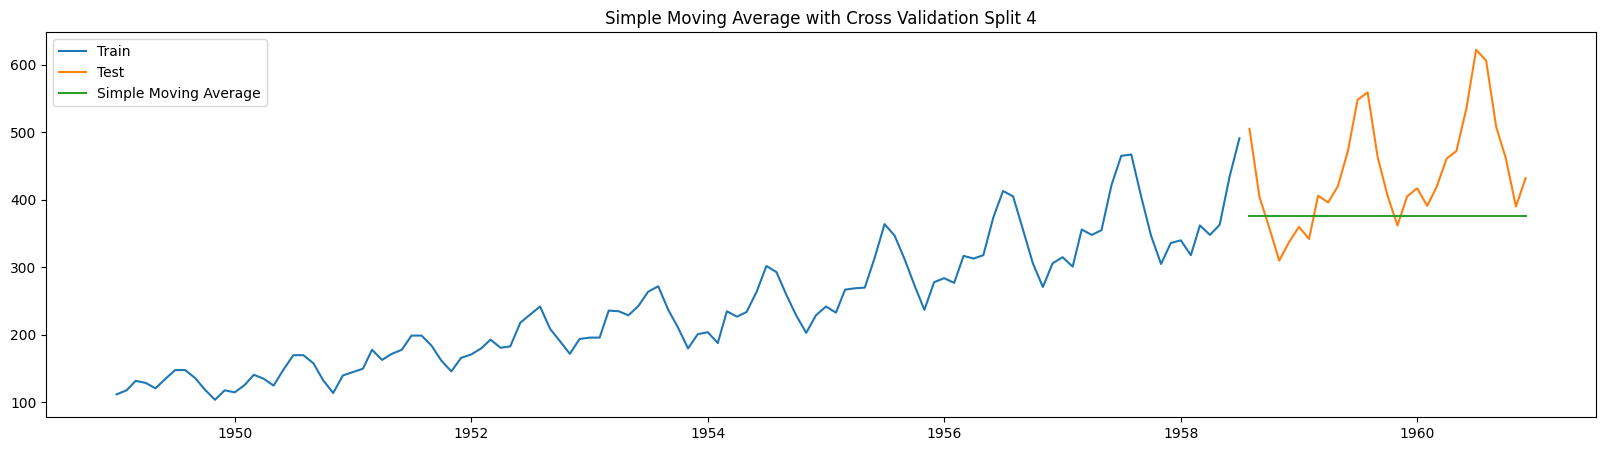

RMSE at Split 4 = 100.98290891393606


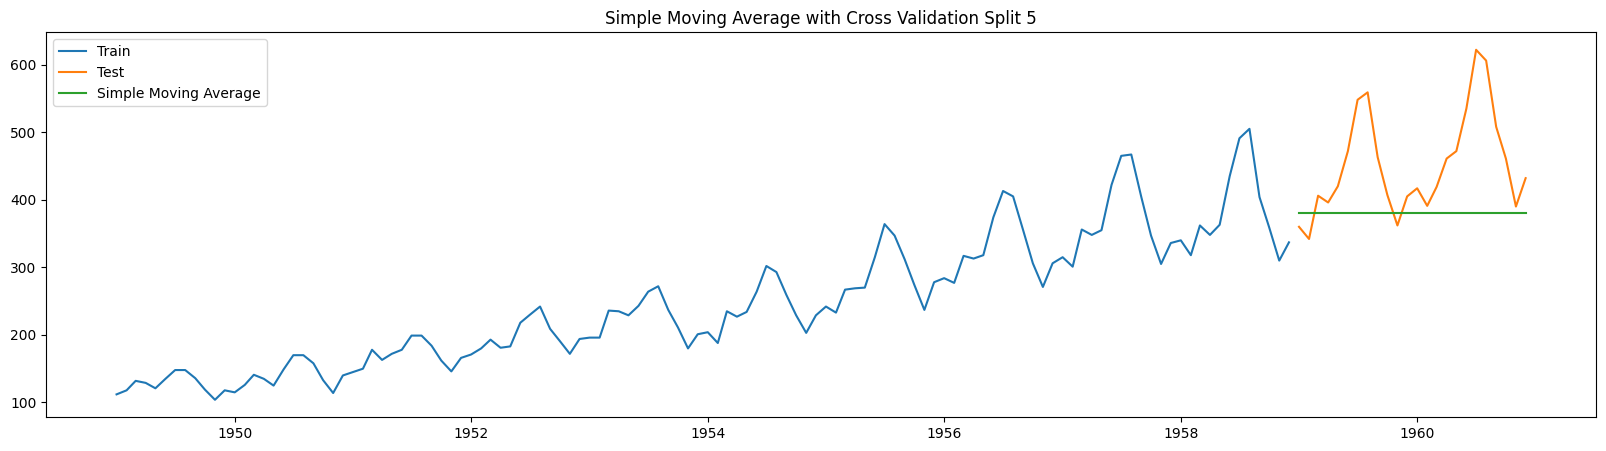

RMSE at Split 5 = 103.21458230308352
Mean RMSE = 139.61776170323105


In [ ]:
moving_average_window_size = 12
rmse_list = []

for i, (df_train, df_test) in enumerate(cross_validation(data, n_splits = 5)):
  y = df_test.copy()
  ma = moving_average(df_train, moving_average_window_size)
  y['ma'] = ma['Passengers'].iloc[-1]

  rmse_list.append(RMSE(df_test, y['ma']))
  plt.figure(figsize=(20,5))
  plt.plot(df_train, label='Train')
  plt.plot(df_test, label='Test')
  plt.plot(y['ma'], label='Simple Moving Average')
  plt.title(f'Simple Moving Average with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()  
  print(f'RMSE at Split {i+1} =', rmse_list[-1])

print("Mean RMSE =", np.mean(rmse_list))

## Report

Overall, the simple moving average seems good for the short term forecasting, but for the long term it doesn't seem to produce any good results since it doesn't have any information about the test data.

- Fixed Partitions: The simple moving average doesn't yield any good results as the algorithm doesn't have any information after the first forecast, so it repeats this forecasts for the remaining months

- Roll Forward: The simple moving average yields good results, since we're forecasting one period after the training

- Cross Validation: The same applies as fixed partiotions

# 2 - Naïve Forecasting

## Fixed

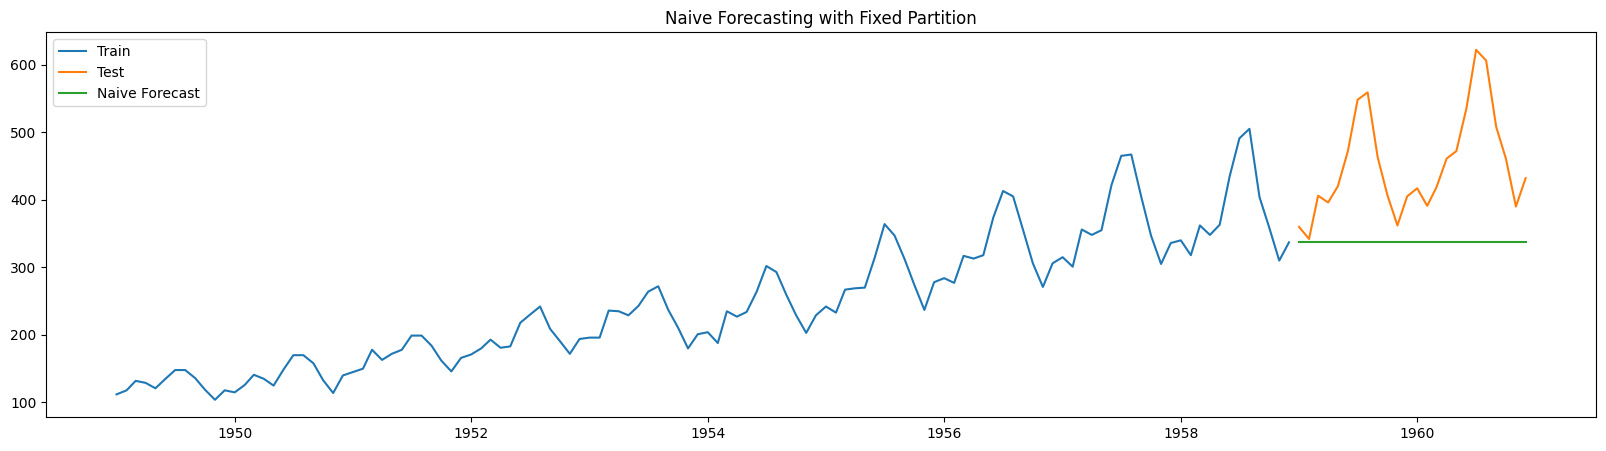

RMSE = 137.32898455897794


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

naive_forecast = test_data.copy()

# perfrom naive forecasting
naive_forecast['fixed'] = train_data['Passengers'].iloc[-1]

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(naive_forecast['fixed'], label='Naive Forecast')
plt.title('Naive Forecasting with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(naive_forecast['Passengers'], naive_forecast['fixed']))

## Roll Forward

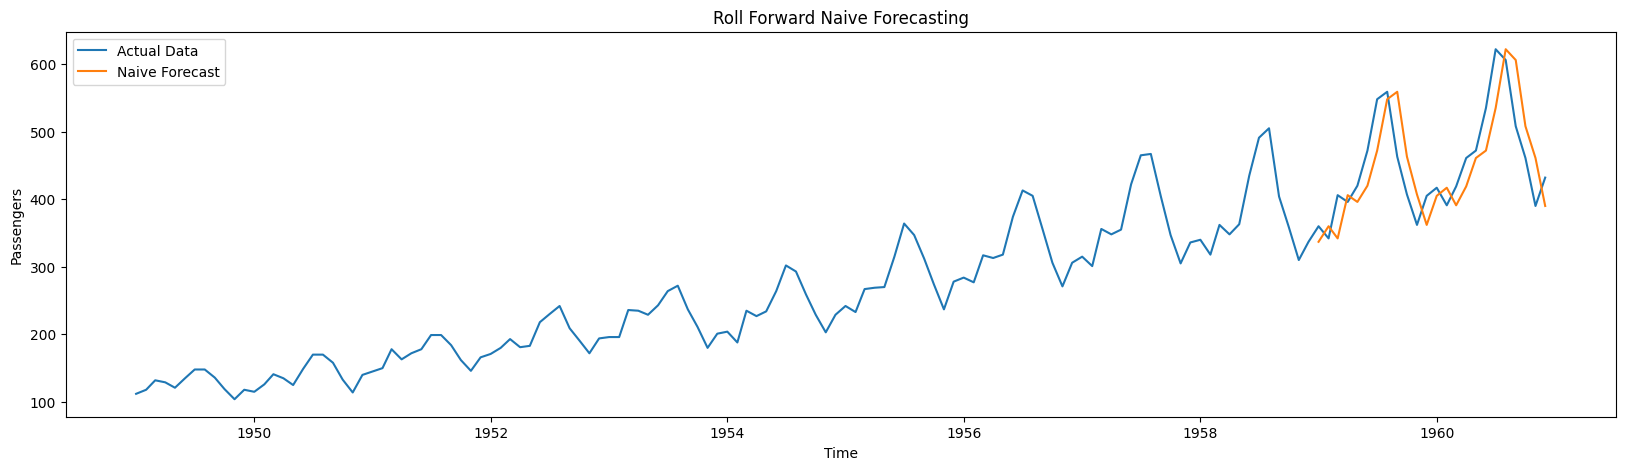

Average RMSE: 44.208333333333336


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
forecast_data = pd.DataFrame()
rmse_list = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  forecast_test_data = test_data.copy()
    
  # Perform the naive forecast for the test data
  naive_forecast = train_data['Passengers'].iloc[-1]
  forecast_test_data['naive_forecast'] = [naive_forecast] * len(test_data)
  # Calculate the RMSE for the forecast
  rmse_list.append(RMSE(test_data['Passengers'], forecast_test_data['naive_forecast']))

  # Add the forecast to the forecast DataFrame
  forecast_data = pd.concat([forecast_data, forecast_test_data['naive_forecast']])

# Plot the overall results of the data and forecasting
plt.figure(figsize=(20,5))
plt.plot(data, label='Actual Data')
plt.plot(forecast_data, label='Naive Forecast')
plt.title('Roll Forward Naive Forecasting')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Print the average RMSE across all splits
print('Average RMSE:', np.mean(rmse_list))


## Cross Validation

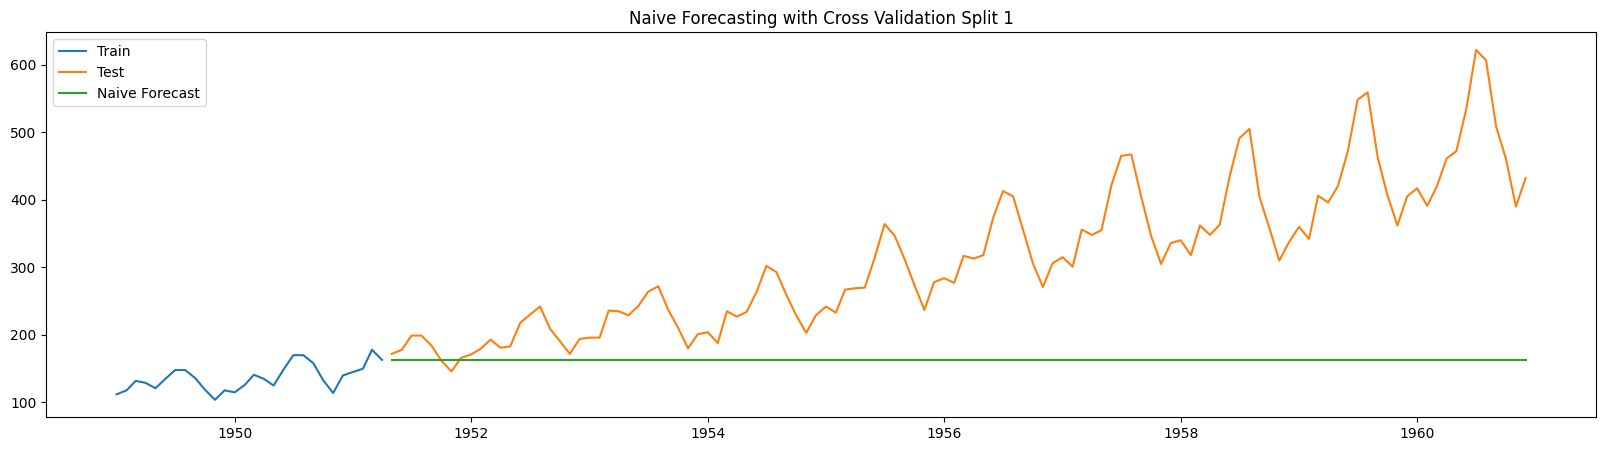

RMSE at Split 1 = 185.9312766996785


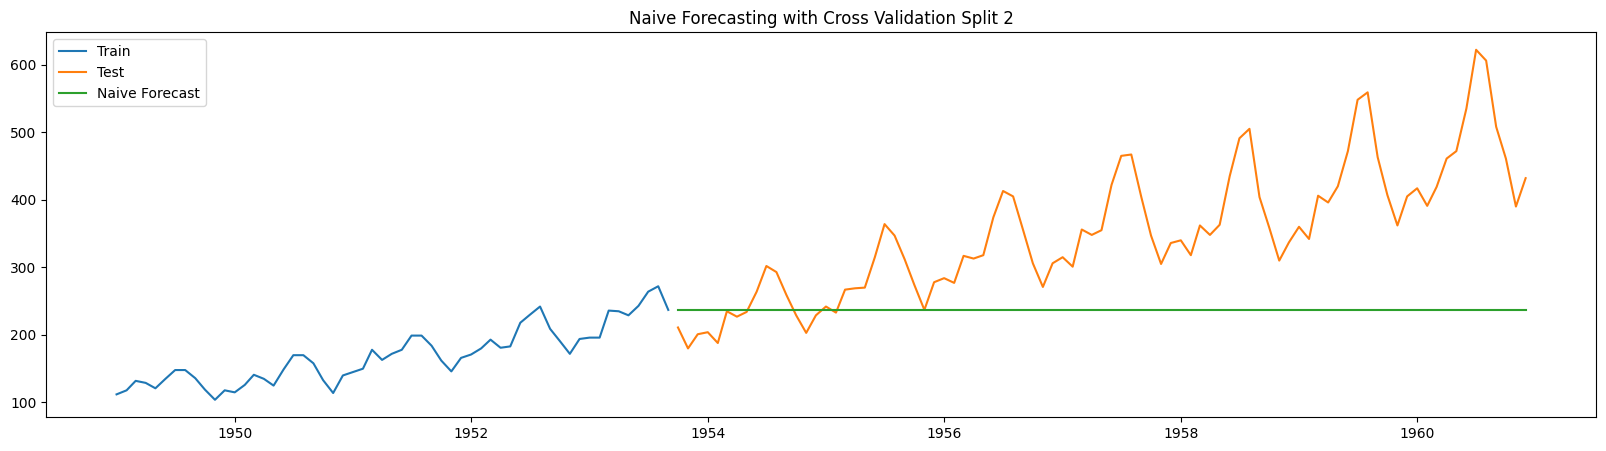

RMSE at Split 2 = 150.6464995148973


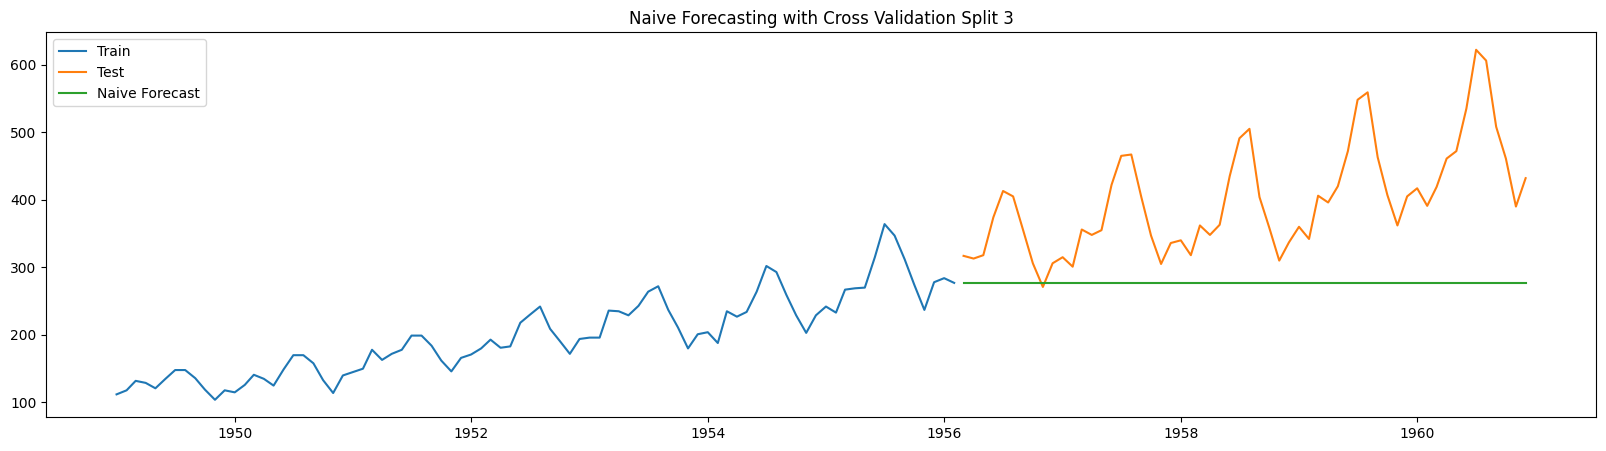

RMSE at Split 3 = 146.23770210599378


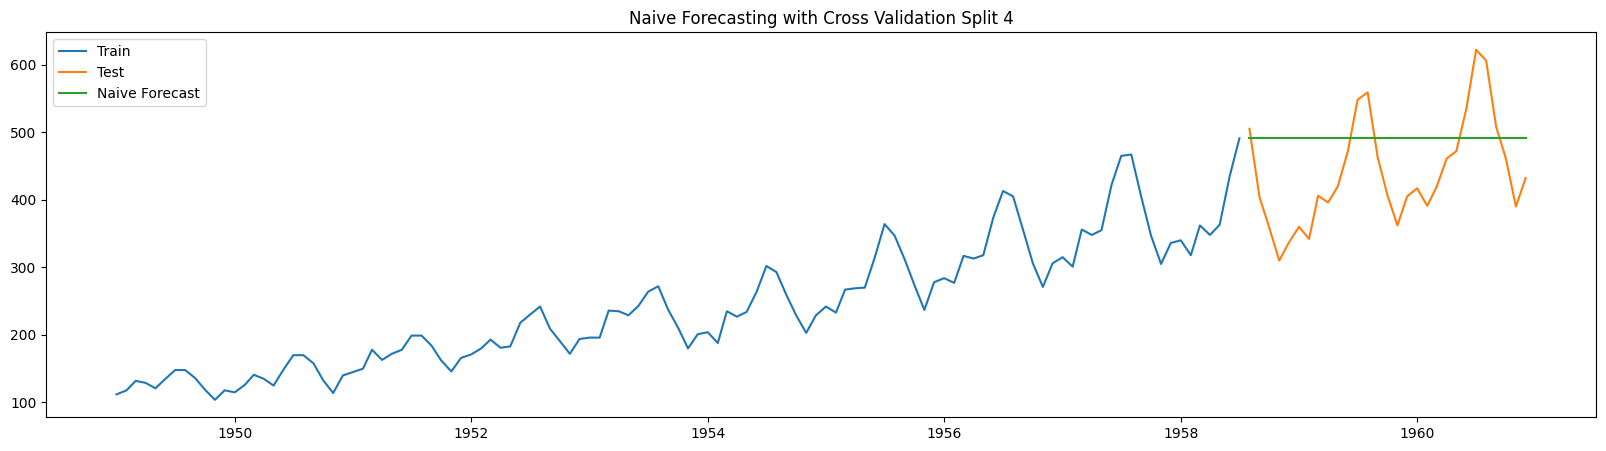

RMSE at Split 4 = 93.13394136662937


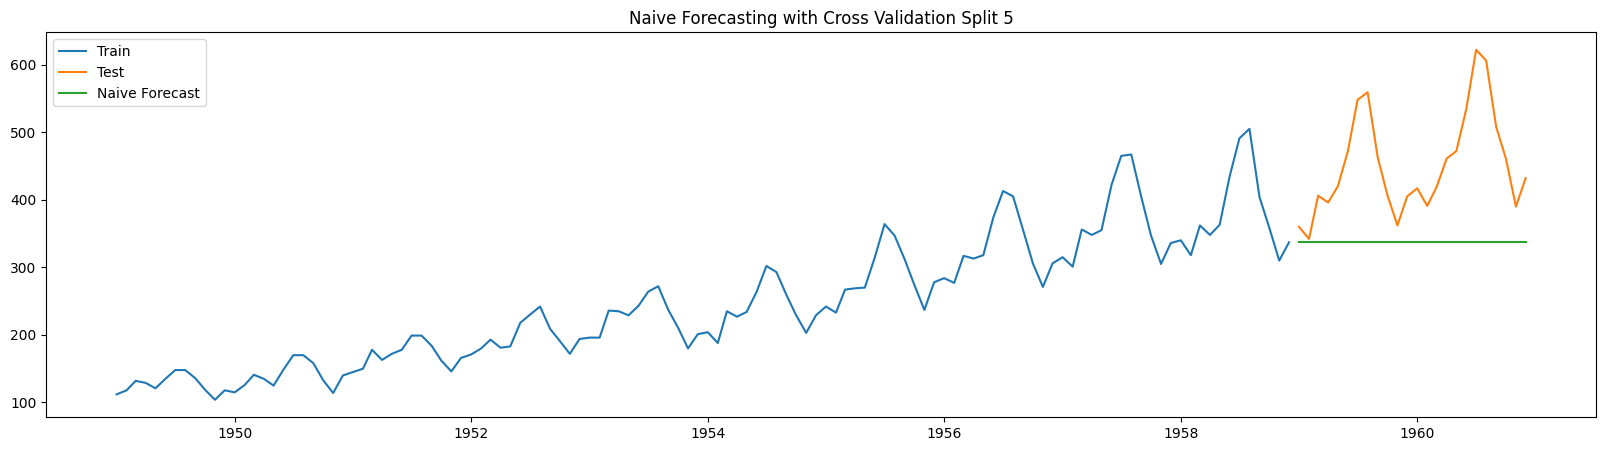

RMSE at Split 5 = 137.32898455897794
Mean RMSE of all splits = 142.65568084923538


In [ ]:
rmse_list = []

for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  y = test_data.copy()
  y['naive'] = train_data['Passengers'].iloc[-1]
  rmse_list.append(RMSE(test_data['Passengers'], y['naive']))

  plt.figure(figsize=(20,5))
  plt.plot(train_data, label='Train')
  plt.plot(test_data, label='Test')
  plt.plot(y['naive'], label='Naive Forecast')
  plt.title(f'Naive Forecasting with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()  
  print(f'RMSE at Split {i+1} =', rmse_list[-1])

print('Mean RMSE of all splits =', np.mean(rmse_list))

## Report

In general, naive forecast models tend to perform poorly when predicting long-term periods as they rely solely on the latest entry and do not account for trends or seasonality. However, for short-term periods, they can be effective as they capture the most recent information available.


- Fixed Partition: The fixed partition method is not suitable for long-term predictions using a naive forecast model, as it relies solely on the last entry and therefore produces constant and unreliable results.

- Roll Forward: The roll forward technique is highly effective when using a naive forecast model to predict short-term periods. This technique involves retraining the model with actual new data from the short period, resulting in highly accurate and reliable predictions.

- Cross Validation: Same applies as fixed Partition

# 3 - Weighted Moving Average

In [ ]:
def weighted_moving_average(data, window_size, weights):
  return data.rolling(window_size).apply(lambda x: np.sum(weights*x)/np.sum(weights), raw=True)

## Fixed

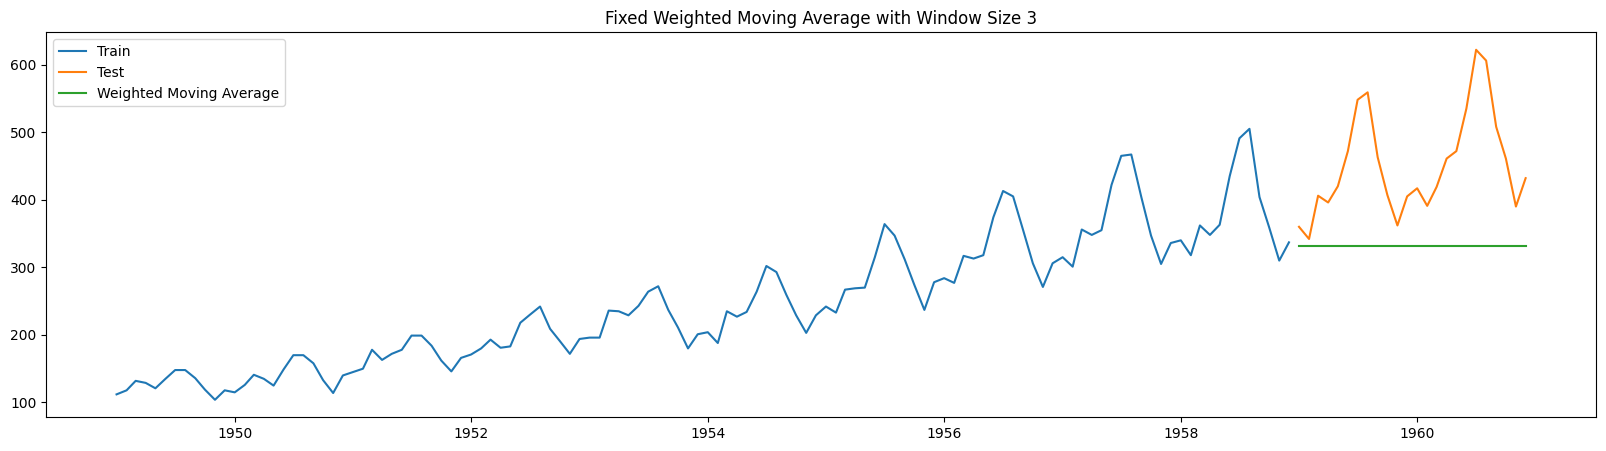

RMSE = 84.65711478271236


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

# Apply the wegihted moving average to the train data
wma_window_size = 3
weights = [0.1, 0.3, 0.6]
ma = weighted_moving_average(train_data, wma_window_size, weights)
test_data['ma'] = ma['Passengers'].iloc[-1]



# Plot the results
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data['ma'], label='Weighted Moving Average')
plt.title(f'Fixed Weighted Moving Average with Window Size {wma_window_size}')
plt.legend(loc='best')
plt.show()
print("RMSE =", RMSE(test_data['Passengers'], ma[-test_size:]))

## Roll Forward

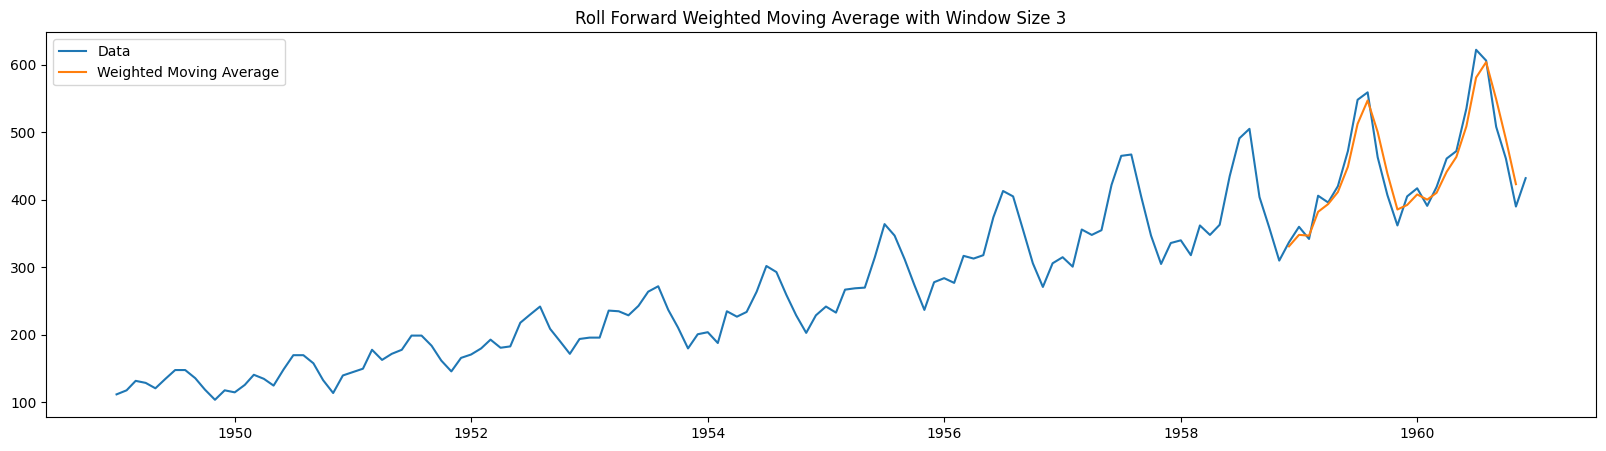

RMSE = 52.416666666666664


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
wma_window_size = 3
weights = [0.1, 0.3, 0.6]
ma_data = pd.DataFrame()
rmse_list = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
    ma = weighted_moving_average(train_data, wma_window_size, weights)
    ma_data = ma_data.append(ma[-test_size:])
    rmse_list.append(RMSE(test_data['Passengers'], ma_data[-test_size:]))

plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(ma_data, label='Weighted Moving Average')
plt.title(f'Roll Forward Weighted Moving Average with Window Size {wma_window_size}')
plt.legend(loc='best')
plt.show()

print("RMSE =", np.mean(rmse_list))

## Cross Validation

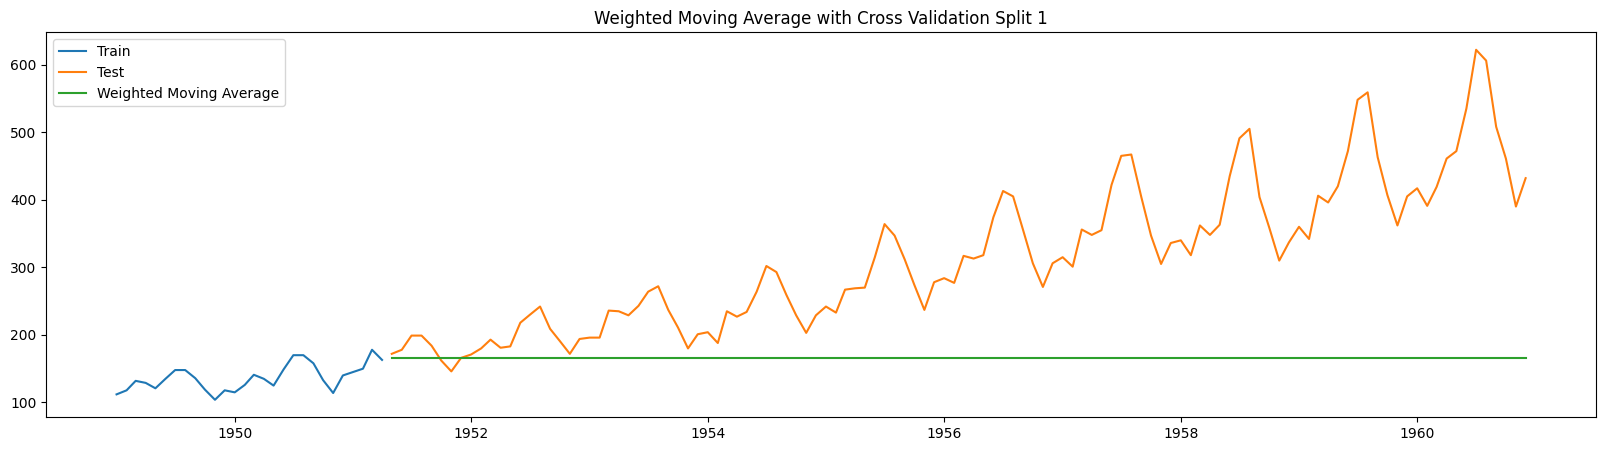

RMSE at Split 1 = 183.32587435192164


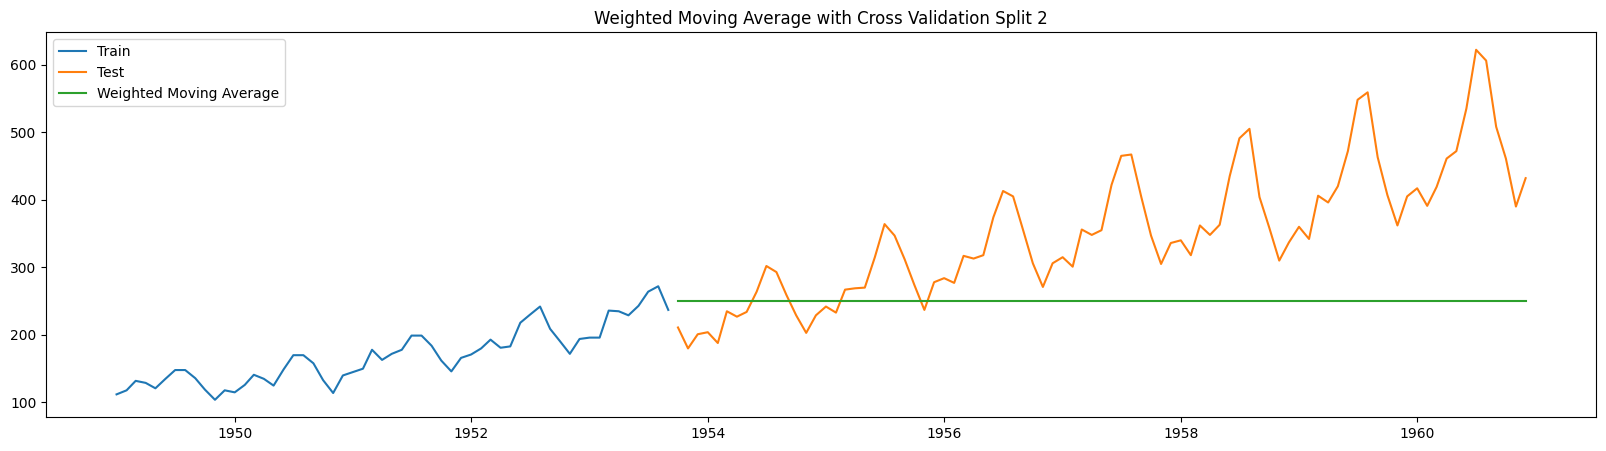

RMSE at Split 2 = 140.79704477044947


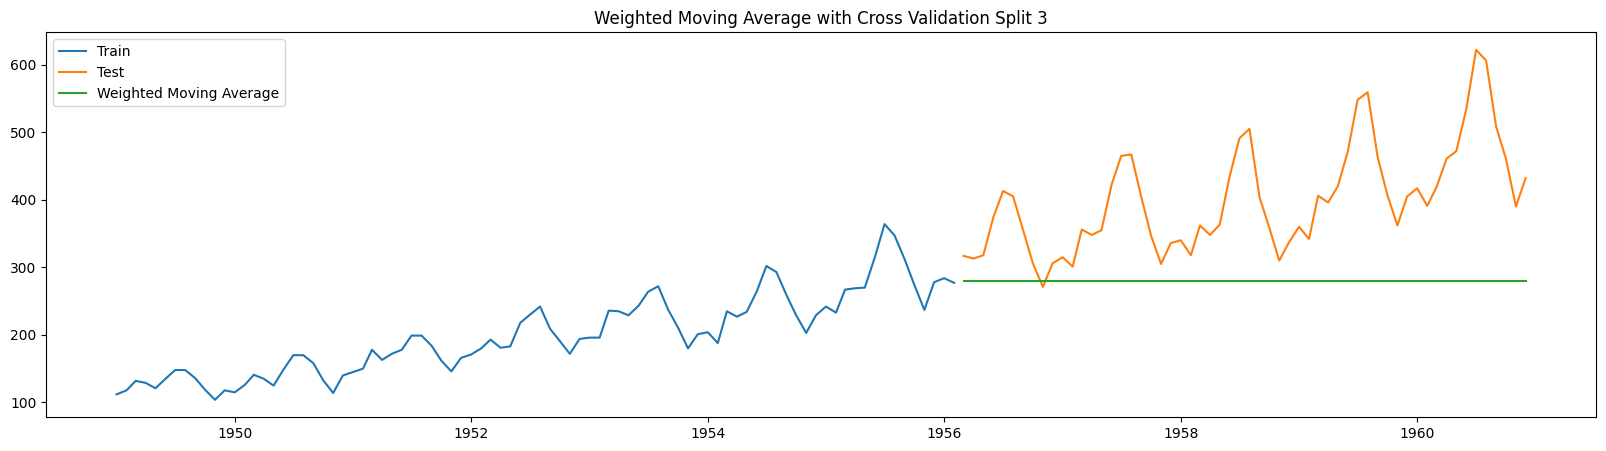

RMSE at Split 3 = 144.38562589647643


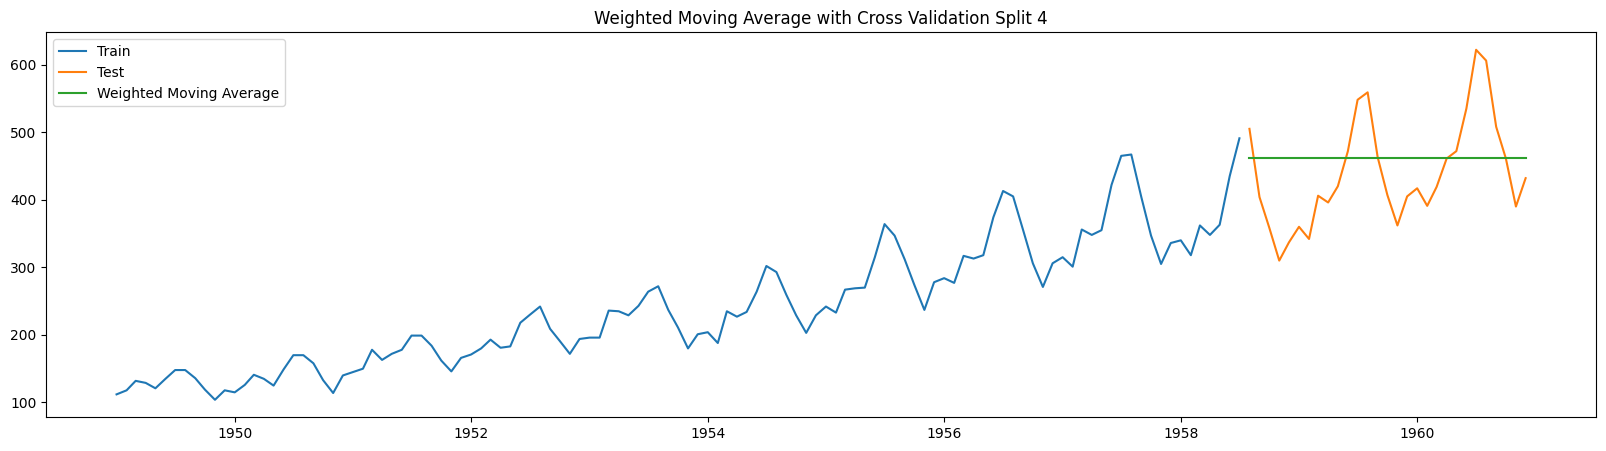

RMSE at Split 4 = 80.92751972151291


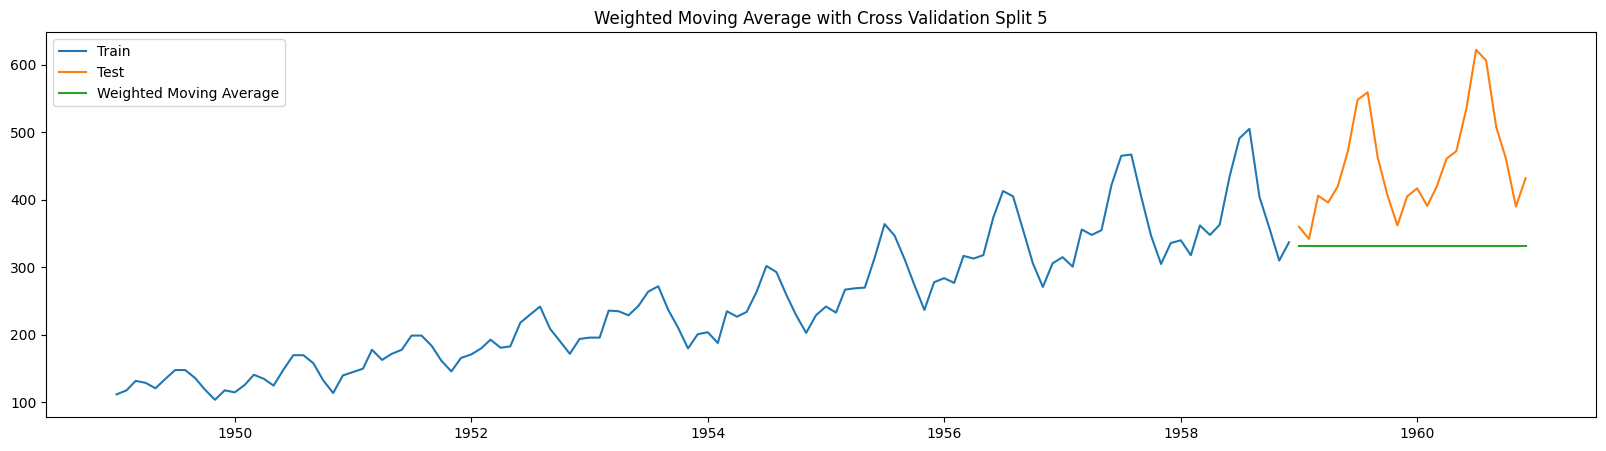

RMSE at Split 5 = 142.31658371391578
Mean RMSE = 138.35052969085524


In [ ]:
wma_window_size = 3
weights = [0.1, 0.3, 0.6]
rmse_list = []

for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  y = test_data.copy()
  ma = weighted_moving_average(train_data, wma_window_size, weights)
  y['ma'] = ma['Passengers'].iloc[-1]

  rmse_list.append(RMSE(test_data, y['ma']))
  plt.figure(figsize=(20,5))
  plt.plot(train_data, label='Train')
  plt.plot(test_data, label='Test')
  plt.plot(y['ma'], label='Weighted Moving Average')
  plt.title(f'Weighted Moving Average with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()  
  print(f'RMSE at Split {i+1} =', rmse_list[-1])

print("Mean RMSE =", np.mean(rmse_list))

## Report

In general weighted moving average seem to behave the same as simple moving average in fixed partitions and cross validations, but it is able to have better results in roll forward, since it doesn't give all the past values the same weight. Both Moving and Weighted Moving Average should not be used for forecasting, as they would be considered data pre-processing techniques, as they smooth the data.

# 4 - Simple Linear Regression

In [ ]:
def perform_OLS(data):
  data['intercept'] = 1
  X = data[['t', 'intercept']]
  y = data['Passengers']
  model = sm.OLS(y,X).fit()
  return model

## Fixed

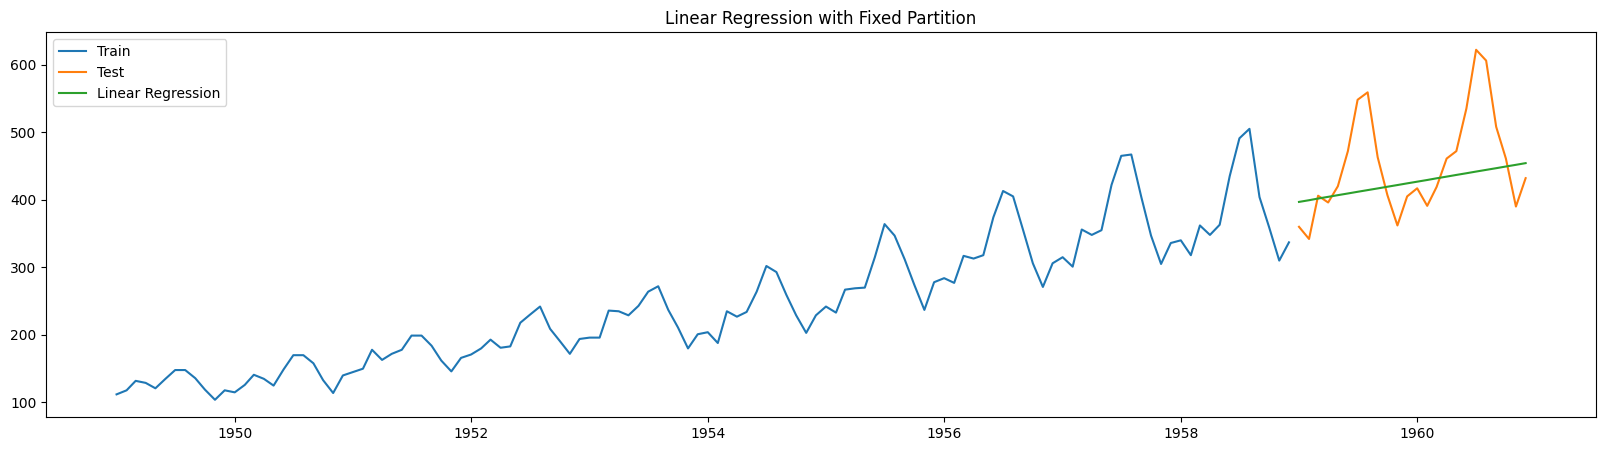

RMSE = 74.78775885644494


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

# performing LR using OLS
train_data['t'] = np.arange(0, len(train_data))
y = test_data.copy()
y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))
y['intercept'] = 1

model = perform_OLS(train_data)
y['forecast'] = model.predict(exog=y[['t', 'intercept']])

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(y['forecast'], label='Linear Regression')
plt.title('Linear Regression with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], y['forecast']))

## Roll Forward

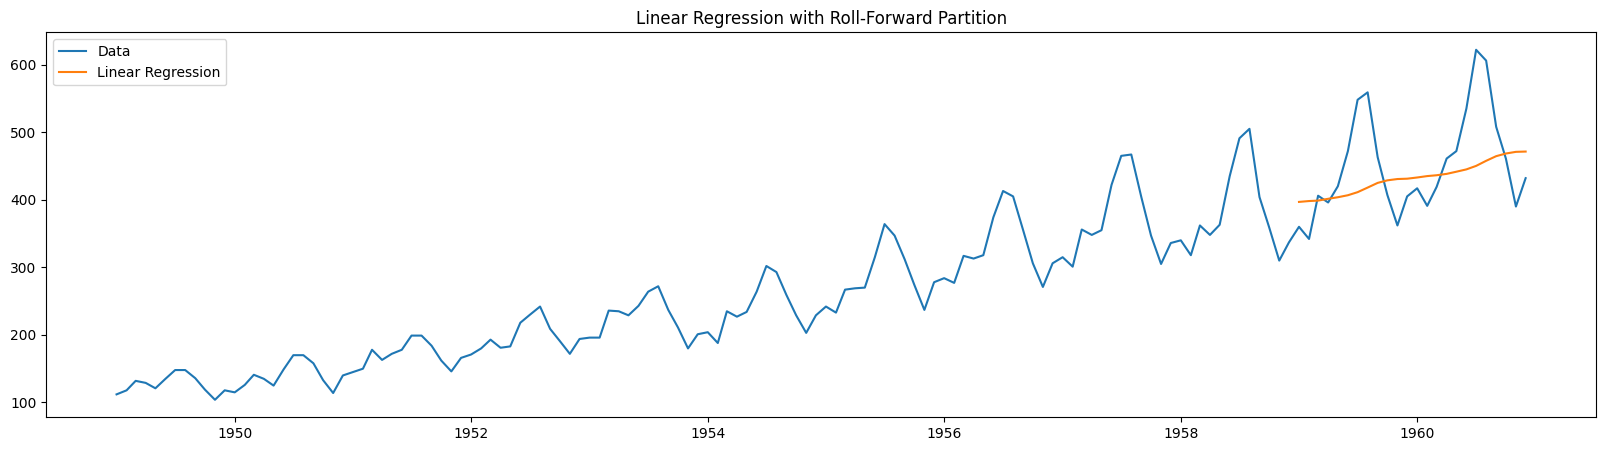

RMSE = 55.477997408919315


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
preds = pd.DataFrame()
rmse_list = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  train_data['t'] = np.arange(0, len(train_data))
  y = test_data.copy()
  y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))
  y['intercept'] = 1

  model = perform_OLS(train_data)
  y['forecast'] = model.predict(exog=y[['t', 'intercept']])
  preds = pd.concat([preds, y['forecast']])
  rmse_list.append(RMSE(y['Passengers'].iloc[-test_size:], y['forecast'].iloc[-test_size:]))

plt.figure(figsize=(20,5))
plt.plot(data.index, data['Passengers'], label='Data')
plt.plot(preds, label='Linear Regression')
plt.title('Linear Regression with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", np.mean(rmse_list))

## Cross Validation

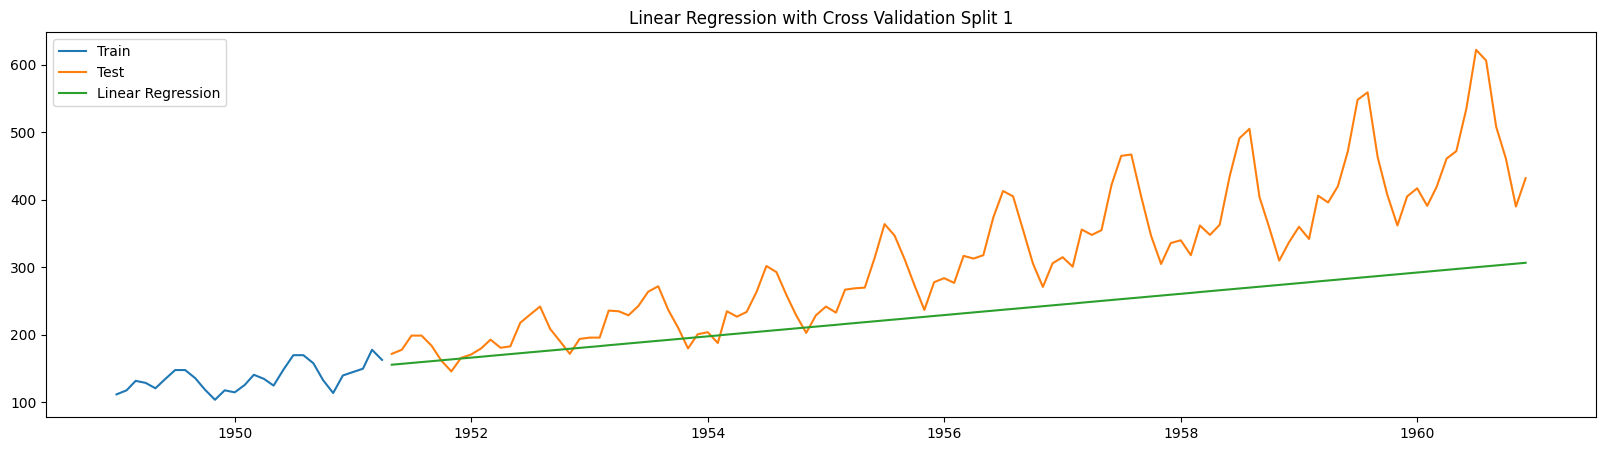

RMSE at split 1 = 109.76872782773978


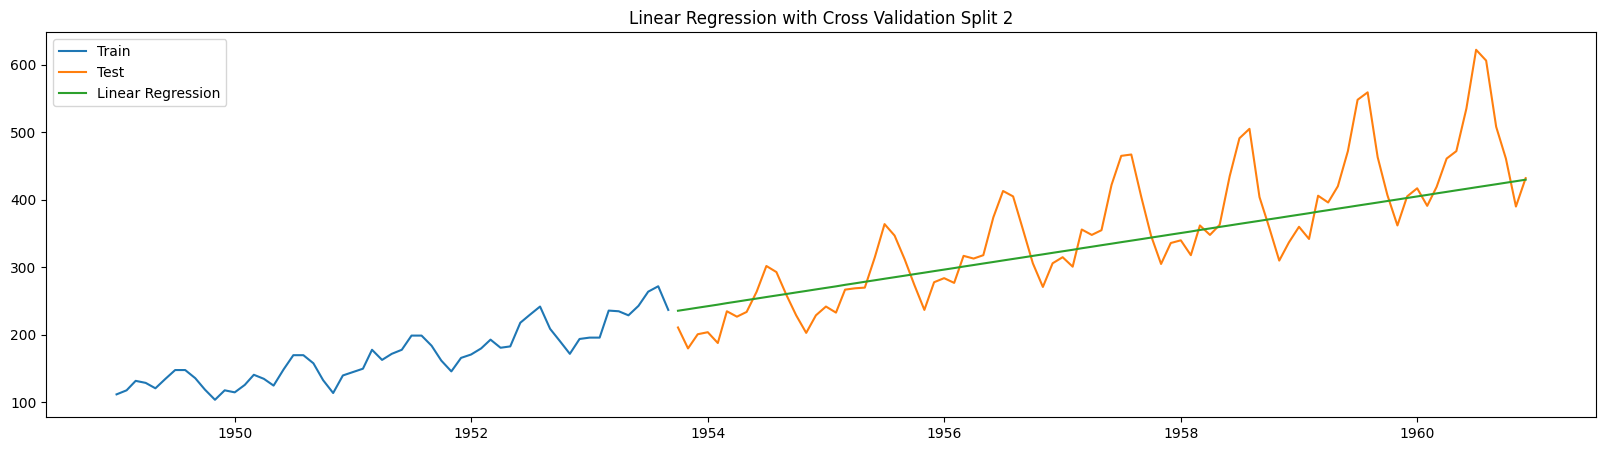

RMSE at split 2 = 62.47551901497475


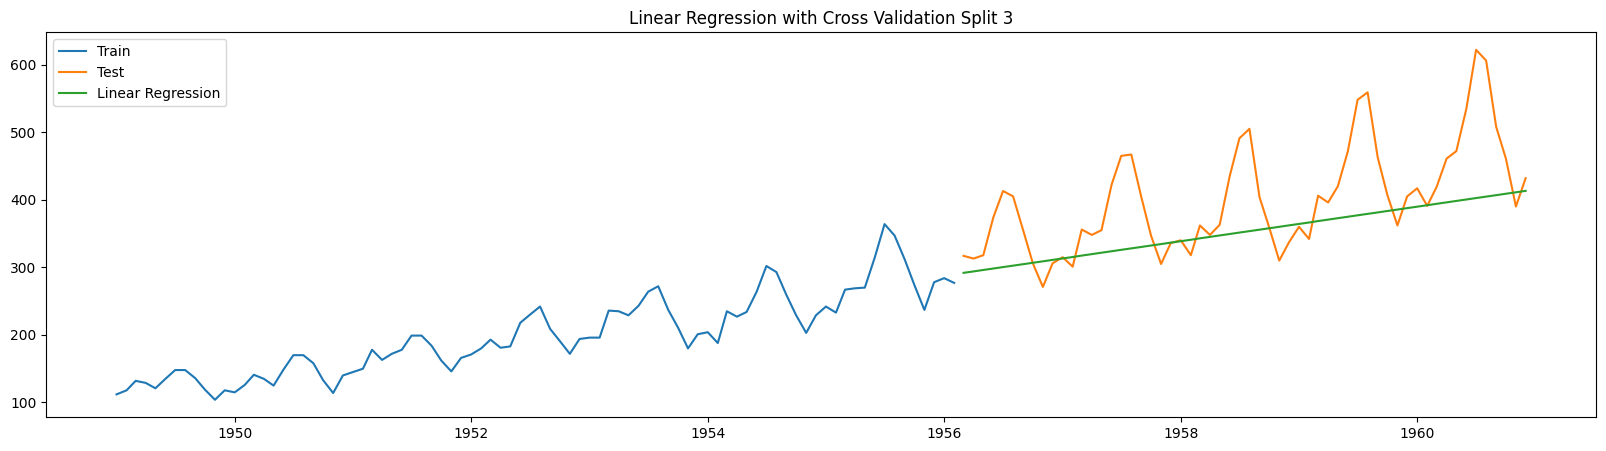

RMSE at split 3 = 79.29498752807847


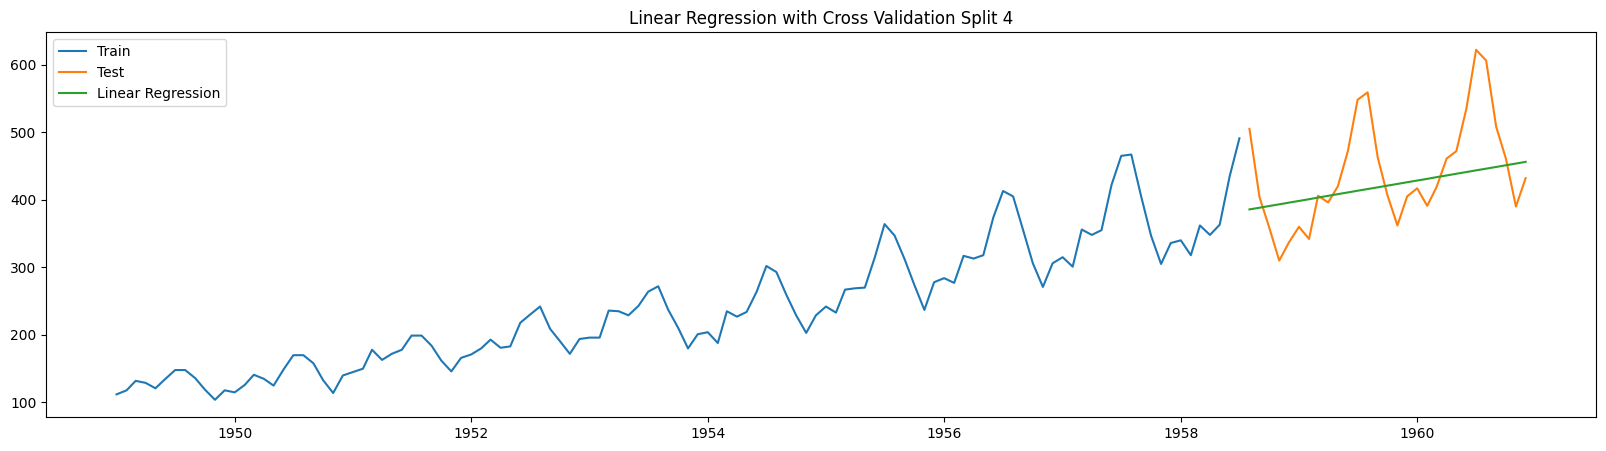

RMSE at split 4 = 73.80490236213495


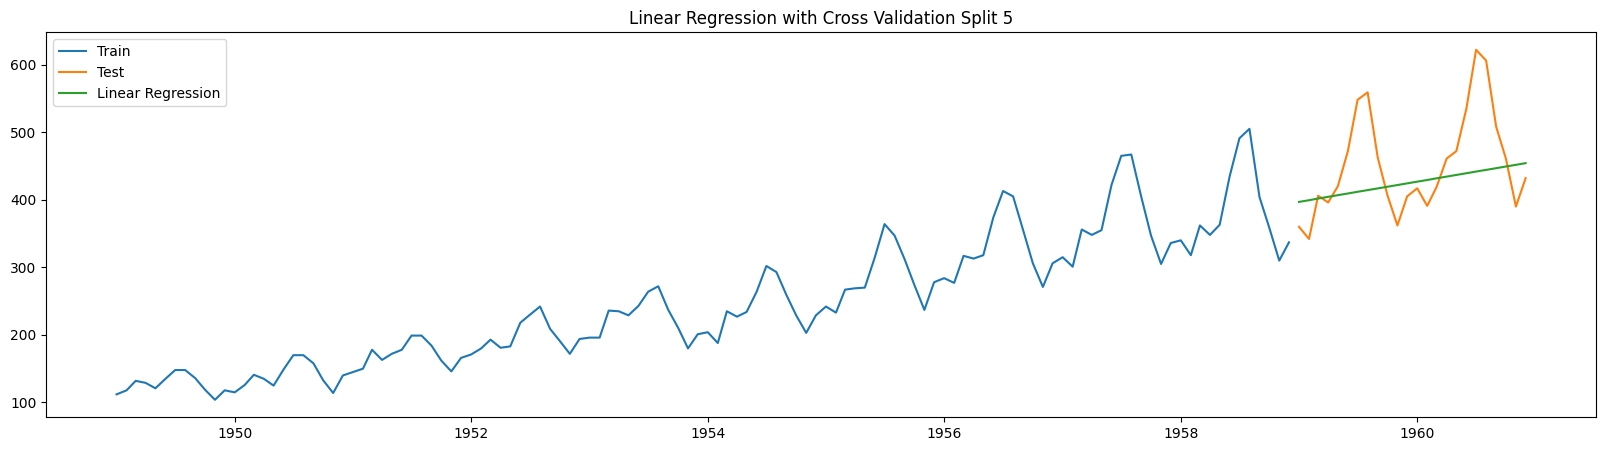

RMSE at split 5 = 74.78775885644494
Mean RMSE = 80.02637911787458


In [ ]:
rmse_list = []

for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  train_data['t'] = np.arange(0, len(train_data))
  y = test_data.copy()
  y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))
  y['intercept'] = 1

  model = perform_OLS(train_data)
  y['forecast'] = model.predict(exog=y[['t', 'intercept']])
  rmse_list.append(RMSE(y['Passengers'], y['forecast']))
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(y['forecast'], label='Linear Regression')
  plt.title(f'Linear Regression with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
print('Mean RMSE =', np.mean(rmse_list))  

## Report

In general, linear regression models tend to perform better when provided with a large amount of data to fit on. These models are reliable for making predictions on data that exhibit a linear trend and have no seasonality.

- Fixed Partition: The fixed partition method can be effectively used with a linear regression model to accurately predict the trend in data. However, when it comes to forecasting, the model's performance can be suboptimal as it does not take seasonality into account while making forecasts based on the trend.

- Roll Forward: Roll-forward method is superior to fixed partition approach as it is regularly fed with new data. This enables the linear equation to be adjusted with each new entry, resulting in more accurate forecasts and lower mean square error compared to the fixed partition technique.

- Cross Validation: When it comes to the cross-validator technique, it is essential to have a sufficient amount of data to achieve optimal results with a linear regression model. With a low volume of data, the model may not perform as well since it requires more data to produce accurate predictions.

# 5 - Classical Decomposition

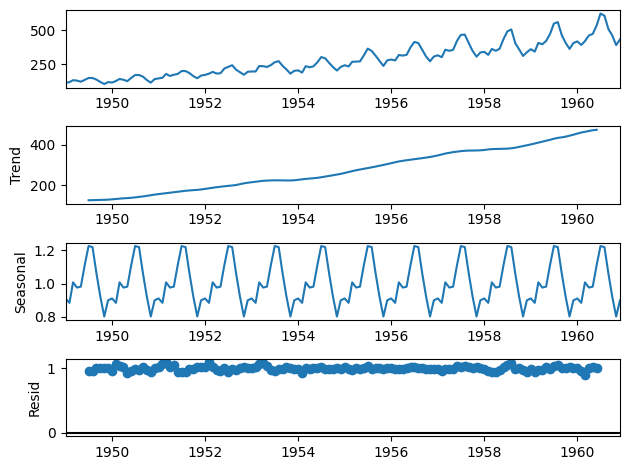

In [ ]:
result = seasonal_decompose(data, model='multiplicative', period=12)

# Extract the components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

result.plot();

Using classical decomp. we are able to extract the data into trend, seasonal and residuals. 

We use "Multiplicative" method as the data seems to have multiplicative seasonality. The trend of the data seems to be nearly linear.

## Fixed

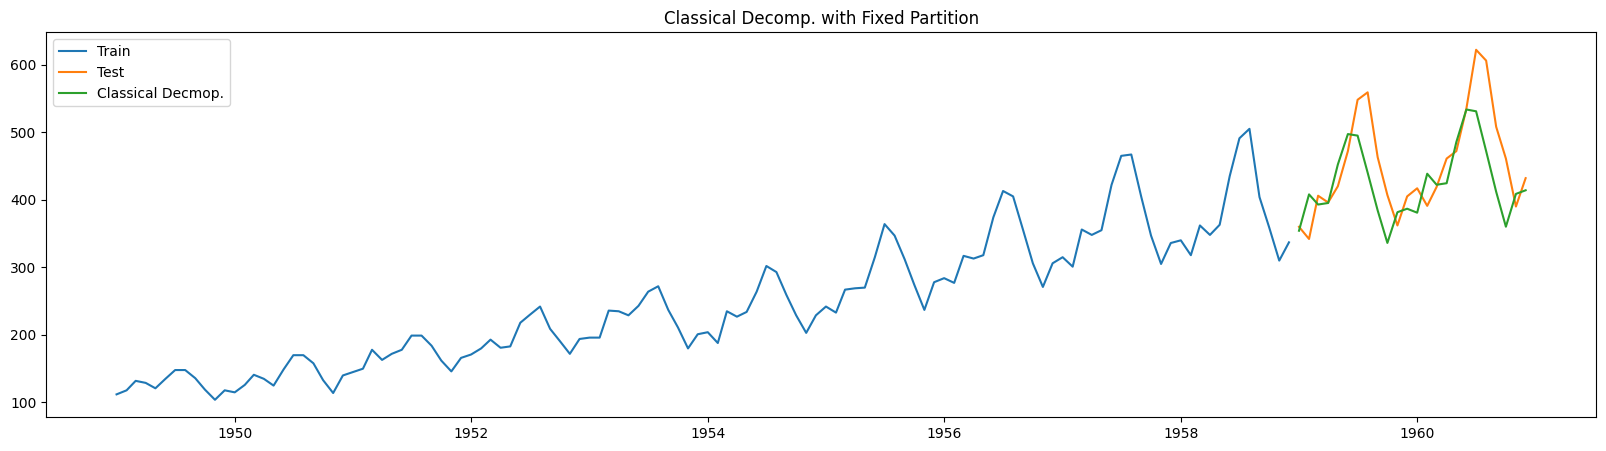

RMSE = 60.04868543435378


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

result = seasonal_decompose(train_data, model='multiplicative', period=12)
seasonal = result.seasonal

train_data['t'] = np.arange(0, len(train_data))
y = test_data.copy()
y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))
y['intercept'] = 1

model = perform_OLS(train_data)

y['trend'] = model.predict(exog=y[['t', 'intercept']])


y['forecast'] = [y['trend'].iloc[i] * seasonal[seasonal.index.month[i]] for i in range(test_size)]


# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(y['forecast'], label='Classical Decmop.')
plt.title('Classical Decomp. with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], y['forecast']))

## Roll Forward

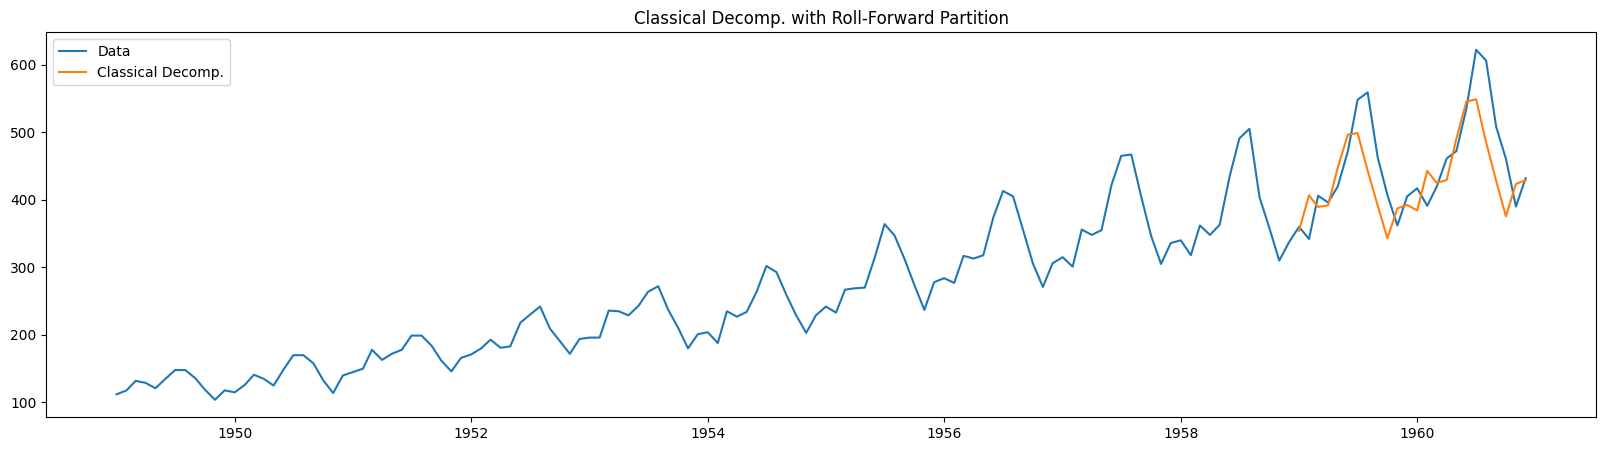

RMSE = 54.70308140624943


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
preds = pd.DataFrame()
rmse_list = []
forecast = []
forecast_index = []
test = []
for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  result = seasonal_decompose(train_data, model='multiplicative', period=12)
  seasonal = result.seasonal
  train_data['t'] = np.arange(0, len(train_data))
  y = test_data.copy()
  y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))

  model = perform_OLS(train_data)

  y['intercept'] = 1
  y['trend'] = model.predict(exog=y[['t', 'intercept']])


  for i in range(len(y['trend'])):
    forecast.append(y['trend'].iloc[i]*seasonal[y.index.month[i]])
  
  test.append(test_data['Passengers'])
  forecast_index.append(test_data.index)


  

plt.figure(figsize=(20,5))
plt.plot(data.index, data['Passengers'], label='Data')
plt.plot(forecast_index, forecast, label='Classical Decomp.')
plt.title('Classical Decomp. with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test, forecast))

## Cross Validation

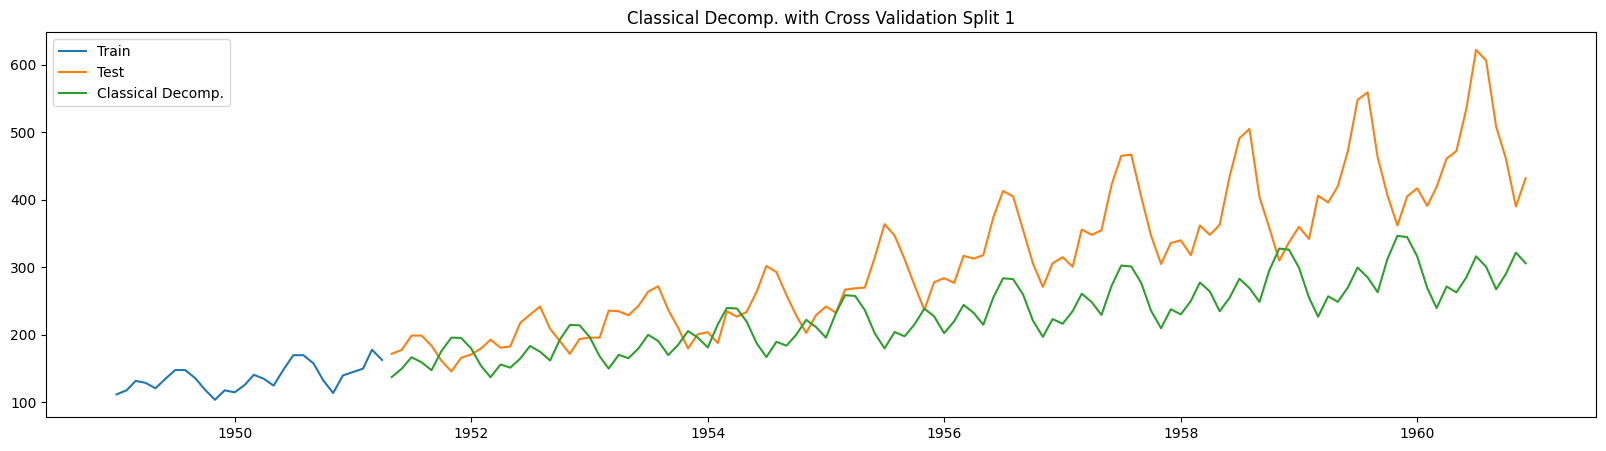

RMSE at split 1 = 113.66185772418393


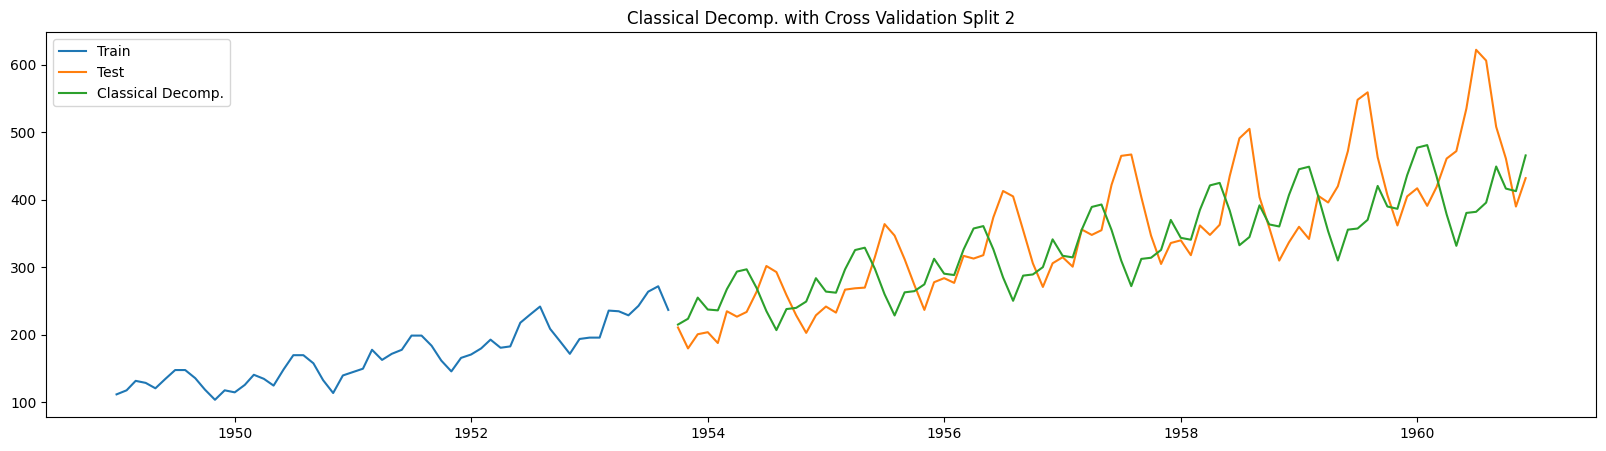

RMSE at split 2 = 81.13477299612536


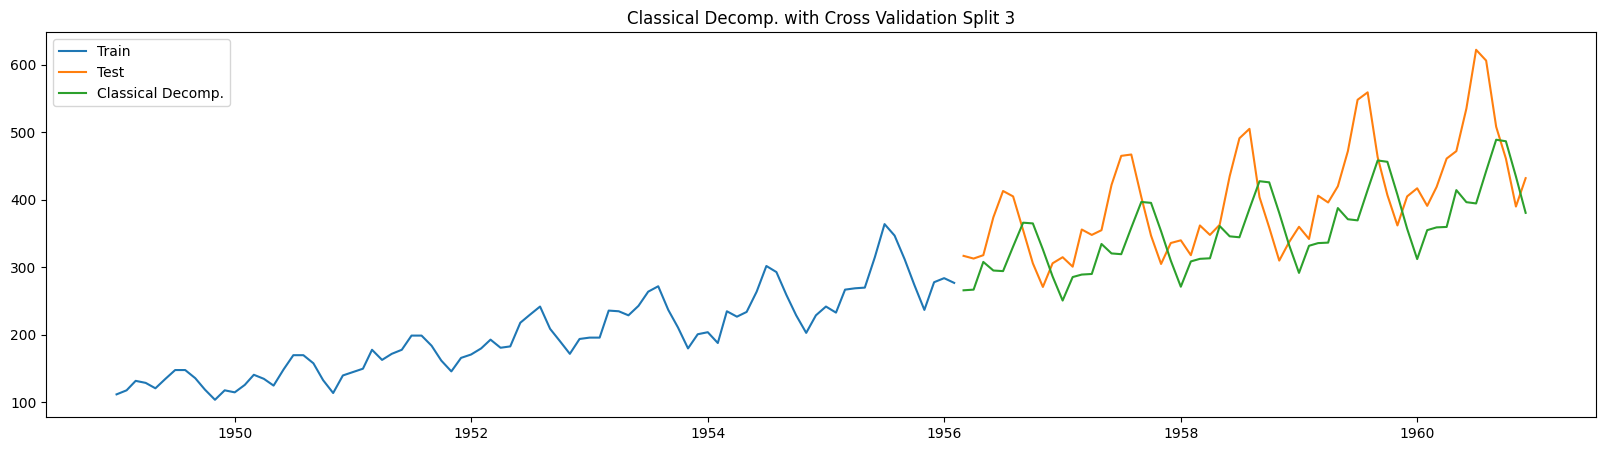

RMSE at split 3 = 80.65932684743899


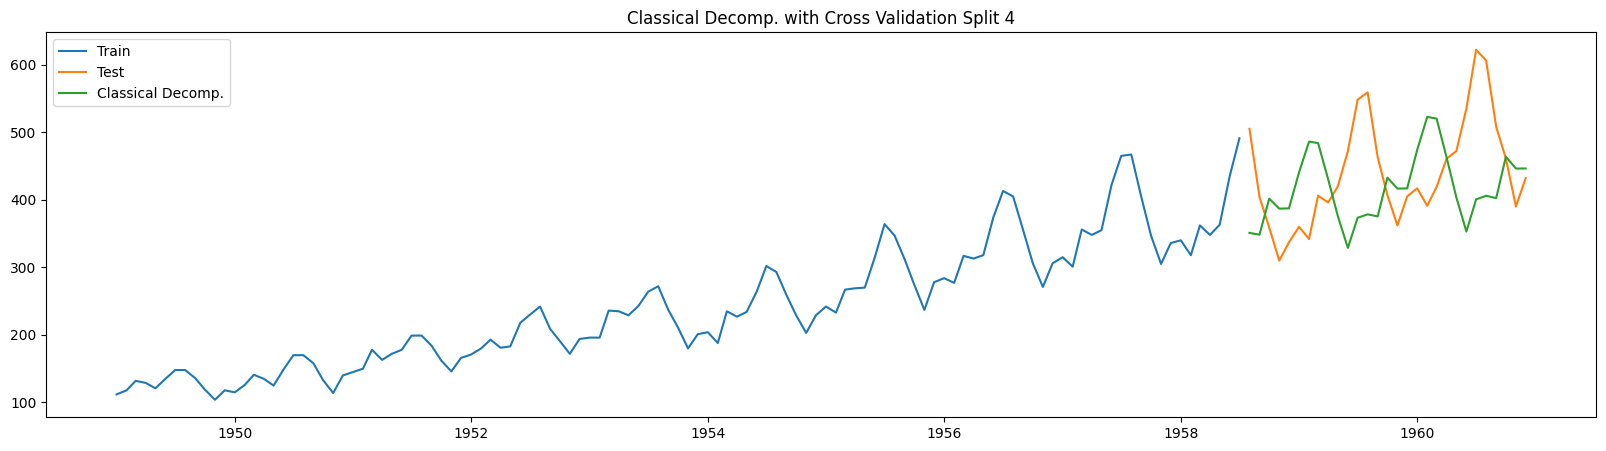

RMSE at split 4 = 108.39556385603176


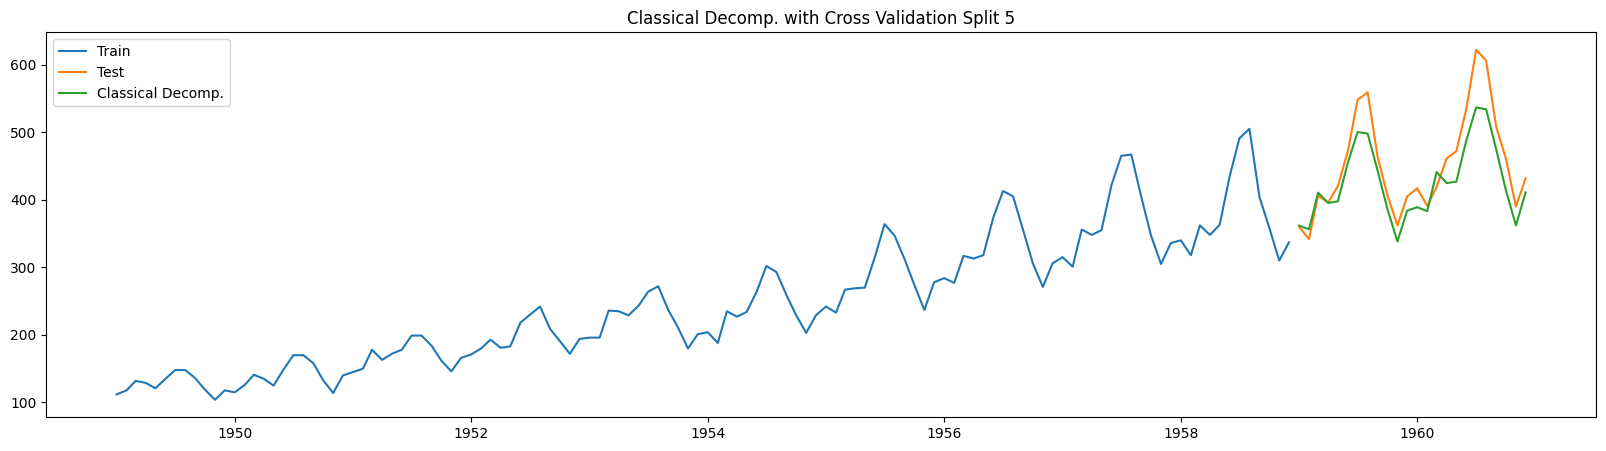

RMSE at split 5 = 36.92992797809511
Mean RMSE = 84.15628988037503


In [ ]:
rmse_list = []

for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  result = seasonal_decompose(train_data, model='multiplicative', period=12)
  seasonal = result.seasonal
  seasonal = np.tile(seasonal, len(test_data) // 12 + 1)[:len(test_data)]

  train_data['t'] = np.arange(0, len(train_data))
  y = test_data.copy()
  y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))

  model = perform_OLS(train_data)

  y['intercept'] = 1
  y['trend'] = model.predict(exog=y[['t', 'intercept']])
  y['forecast'] = [y['trend'].iloc[i] * seasonal[i] for i in range(len(test_data))]
  rmse_list.append(RMSE(y['Passengers'], y['forecast']))
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(y['forecast'], label='Classical Decomp.')
  plt.title(f'Classical Decomp. with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])

print('Mean RMSE =', np.mean(rmse_list))

## Report

The linear regression model is relied upon to predict the trend in the data, which is then multiplied by the seasonality component derived from classical decomposition.

- Fixed Partition: Using this method the classical decomposition seems to be catching the seasoanlity of the data, but since we're estimating the trend the forecasting seems off by some margin.

- Roll Forward: It is observed that the roll-forward technique is the most effective, producing low RMSE and adjusting the trend model with the periodic addition of new data.
- Cross Validation: On the other hand, cross-validator may yield suboptimal predictions due to the linear regression model requiring a larger dataset for optimal fitting.

# 6 - STL

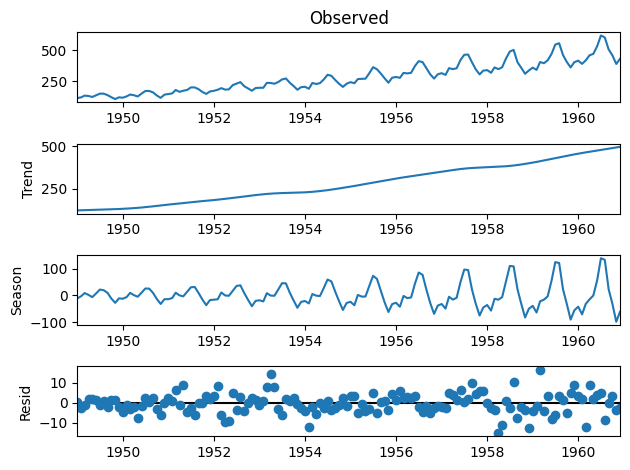

In [ ]:
stl = STL(data, period = 12).fit()
stl.plot();

The difference between Classical Decomp. and STL decomp. is that STL seems to able to get the seasonality as multiplicative seasonality.

## Fixed

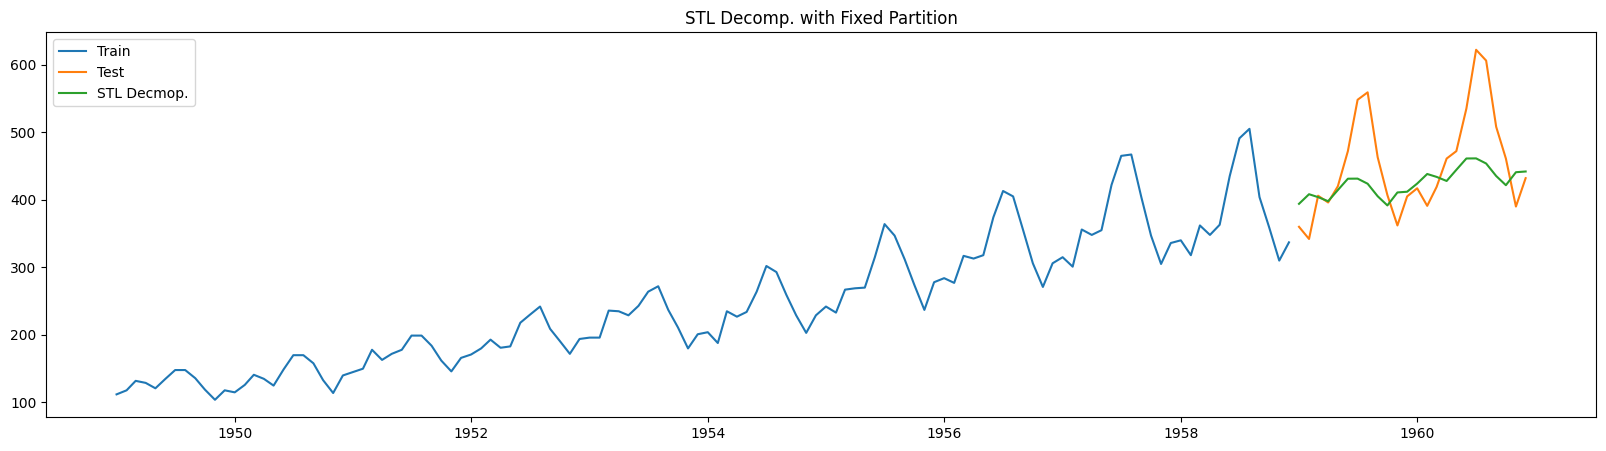

RMSE = 68.78441786259377


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

stl = STL(train_data, period=12).fit()
seasonal = stl.seasonal

train_data['t'] = np.arange(0, len(train_data))
y = test_data.copy()
y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))
y['intercept'] = 1

model = perform_OLS(train_data)

y['trend'] = model.predict(exog=y[['t', 'intercept']])


y['forecast'] = [y['trend'].iloc[i] + seasonal[seasonal.index.month[i]] for i in range(test_size)]


# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(y['forecast'], label='STL Decmop.')
plt.title('STL Decomp. with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], y['forecast']))

## Roll Forward

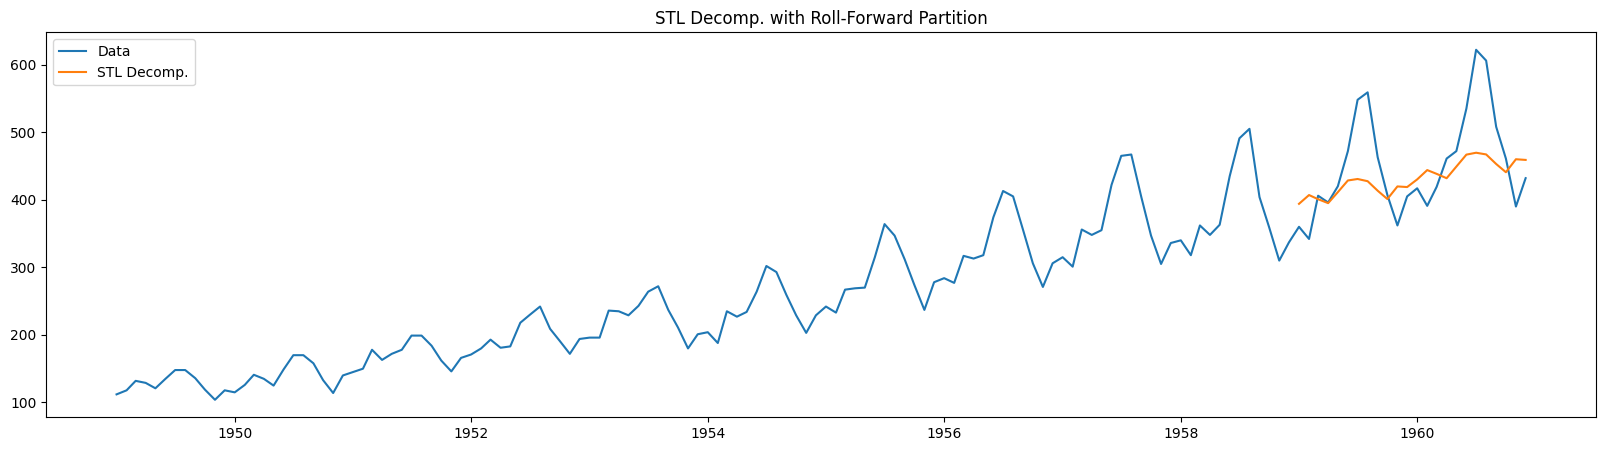

RMSE = 66.26083723689061


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
preds = pd.DataFrame()
rmse_list = []
forecast = []
forecast_index = []
test = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  stl = STL(train_data, period=12).fit()
  seasonal = stl.seasonal
  train_data['t'] = np.arange(0, len(train_data))
  y = test_data.copy()
  y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))

  model = perform_OLS(train_data)

  y['intercept'] = 1
  y['trend'] = model.predict(exog=y[['t', 'intercept']])
  

  for i in range(len(y['trend'])):
    forecast.append(y['trend'].iloc[i]+seasonal[y.index.month[i]])
  
  test.append(test_data['Passengers'])
  forecast_index.append(test_data.index)

plt.figure(figsize=(20,5))
plt.plot(data.index, data['Passengers'], label='Data')
plt.plot(forecast_index, forecast, label='STL Decomp.')
plt.title('STL Decomp. with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test, forecast))

## Cross Validation

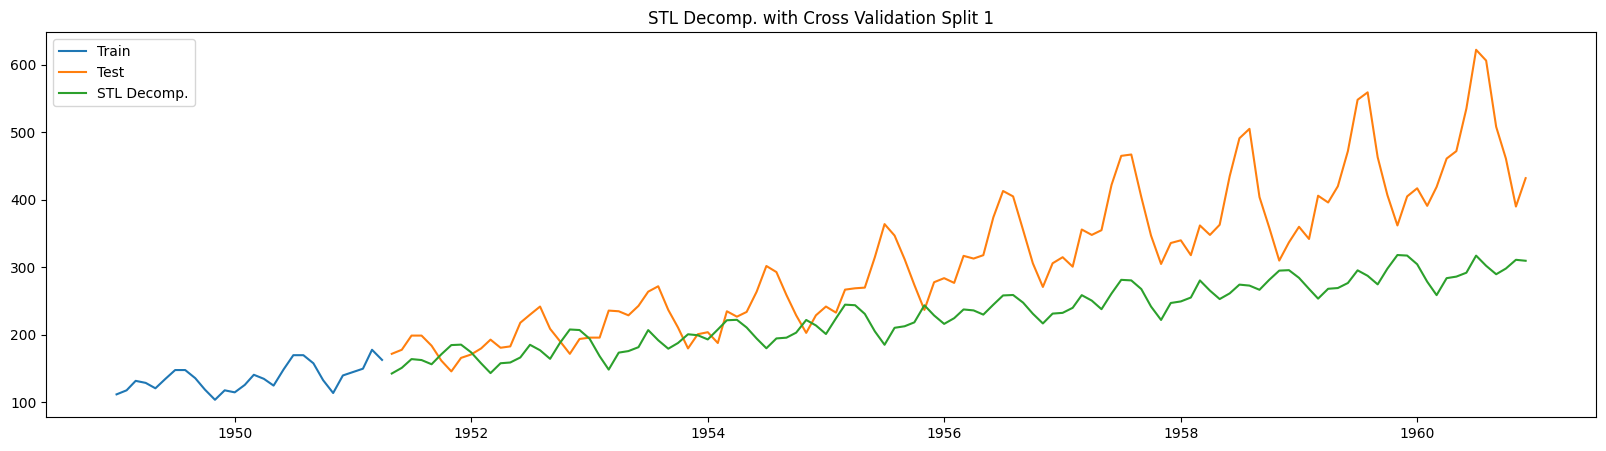

RMSE at split 1 = 110.91299288979252


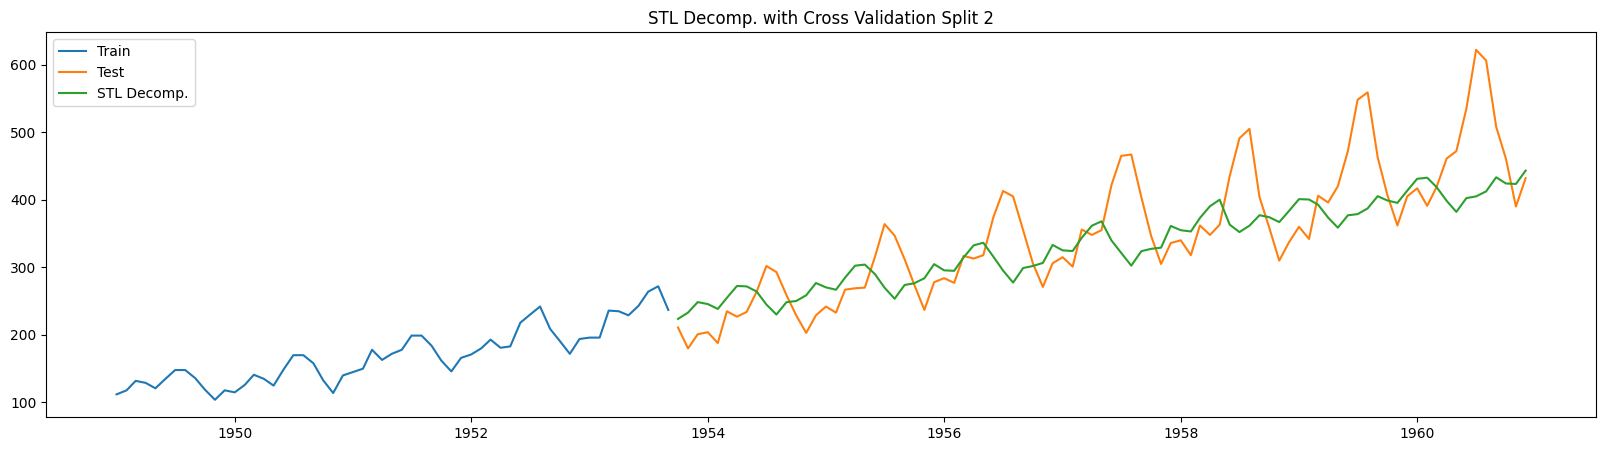

RMSE at split 2 = 69.37825381870194


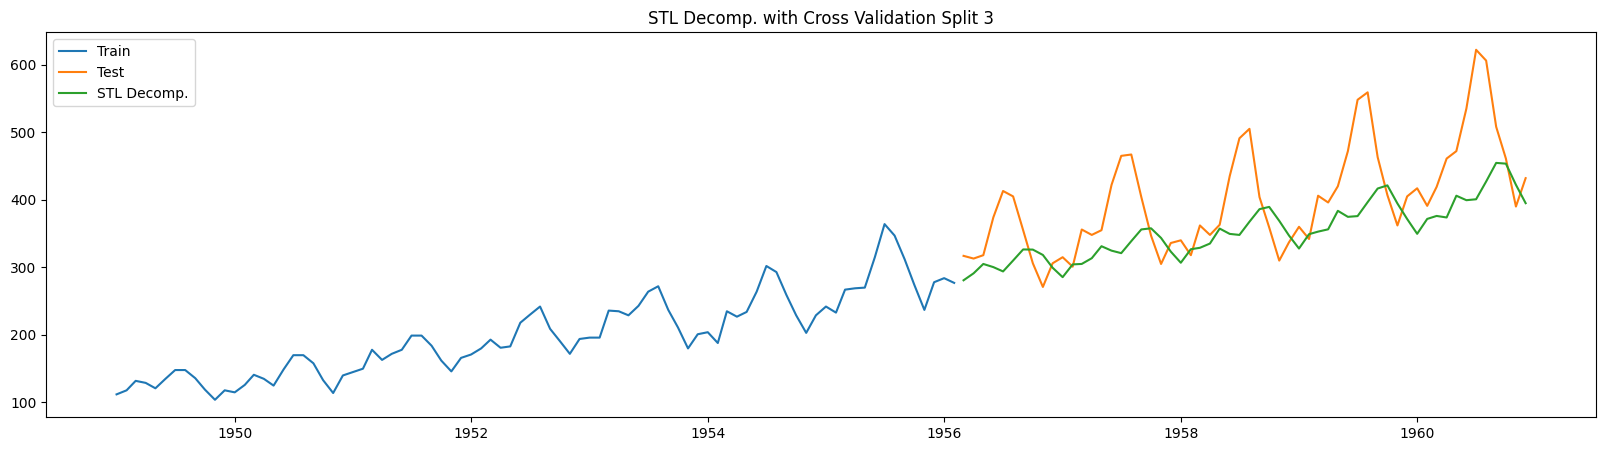

RMSE at split 3 = 77.03396868846683


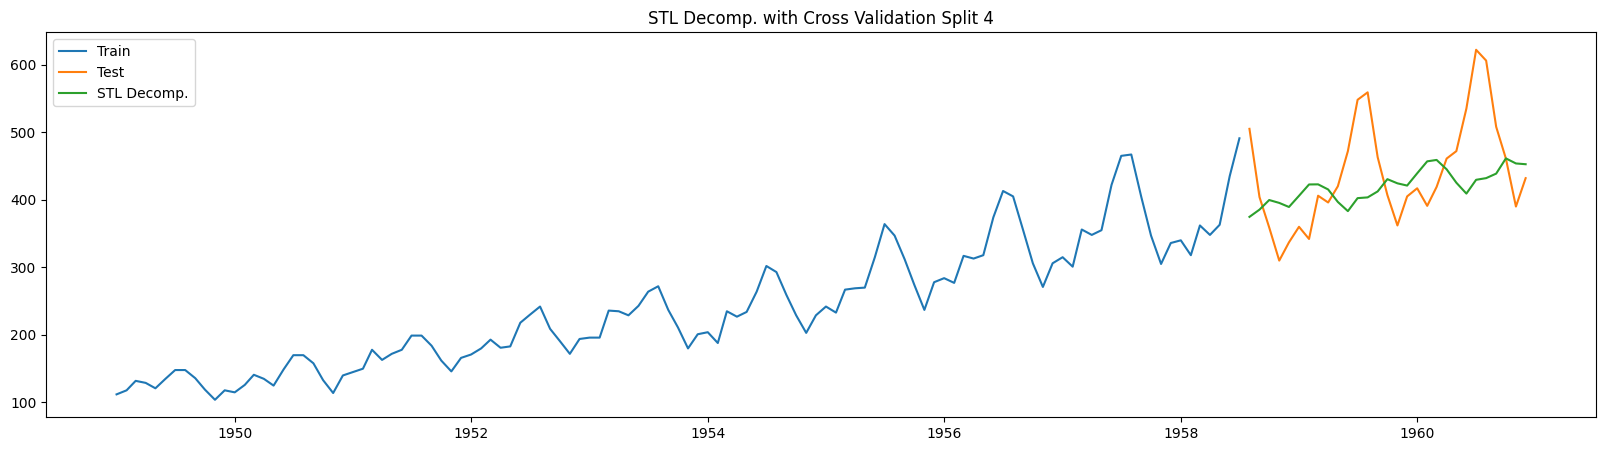

RMSE at split 4 = 83.17154689639166


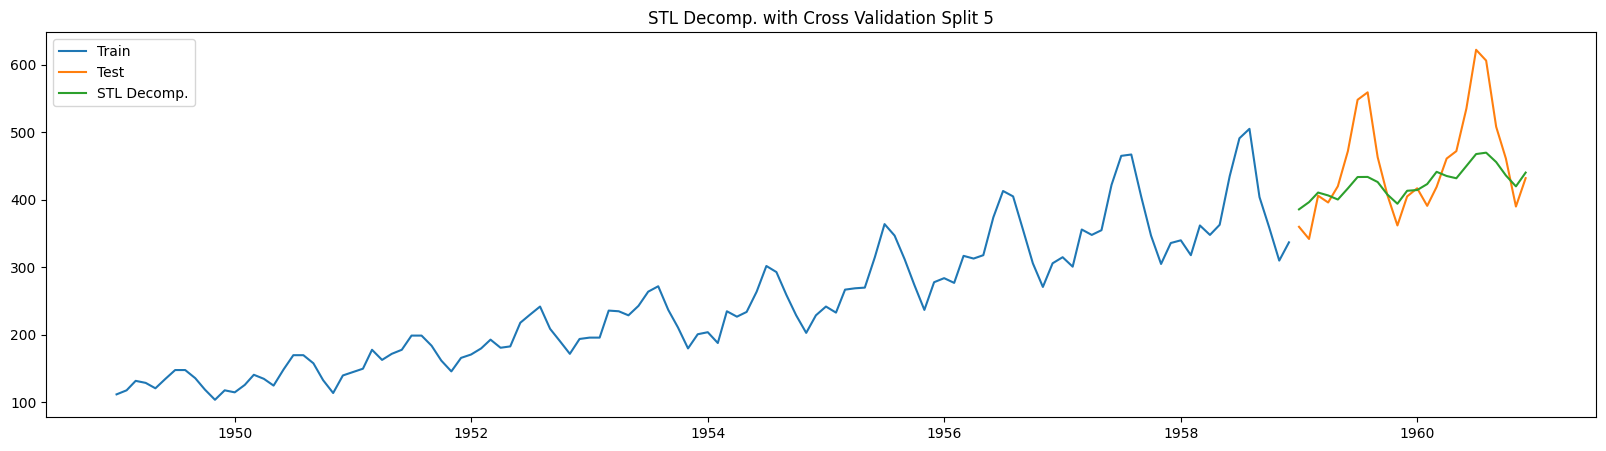

RMSE at split 5 = 63.29186364851186
Mean RMSE = 80.75772518837296


In [ ]:
rmse_list = []

for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  stl = STL(train_data, period=12).fit()
  seasonal = stl.seasonal
  seasonal = np.tile(seasonal, len(test_data) // 12 + 1)[:len(test_data)]

  train_data['t'] = np.arange(0, len(train_data))
  y = test_data.copy()
  y['t'] = np.arange(len(train_data), len(train_data) + len(test_data))

  model = perform_OLS(train_data)

  y['intercept'] = 1
  y['trend'] = model.predict(exog=y[['t', 'intercept']])
  y['forecast'] = [y['trend'].iloc[i] + seasonal[i] for i in range(len(test_data))]
  rmse_list.append(RMSE(y['Passengers'], y['forecast']))
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(y['forecast'], label='STL Decomp.')
  plt.title(f'STL Decomp. with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])

print('Mean RMSE =', np.mean(rmse_list))

## Report

Overall STL Decomp. seems to be more flexible than Classical Decomp. STL Decomp. is able to handle irregular seasonal patterns and trends that change over time. Classical Decomp. assumes the trend and seasonality to be constant over time. Another advantage of STL is that it seems to be less sensitive to extreme values.

- Fixed Partition: We seem to be able to capture the seasonality better using STL, but due to the estimation of the trend the forecast values are quiet off. 
- Roll Forward: Using STL we're able to perform the same on the roll forward. 
- Cross Validation: In all splits the seasonlity is captured quiet well, but the estimation of the trend gets better the more we increase the train data, so generally forecasting gets better with more data introduced.

# 7 - 1  Arima

ARIMA/SARIMA models require the data to be stationary. First we'll start by checking the stationarity

We Have Four Ways to check the stationarity of the data

- By Looking at the plot

- Summary Statisitics

- Histogram plot

- Statistical Test ADF

## Checking Stationarity

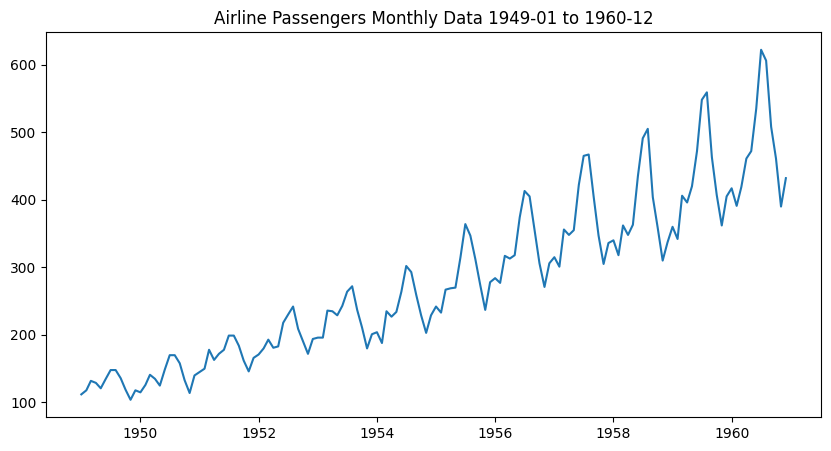

In [ ]:
# Using Analysis (Looking at the data)
plt.figure(figsize=(10,5))
plt.plot(data)
plt.title('Airline Passengers Monthly Data 1949-01 to 1960-12')
plt.show()

As explained earlier, the data exhibts high seasonality, also its mean changes overtime, because there is a upward trend in the data. So, the data is not stationary in both mean and variance

In [ ]:
# Using Summary Statistics
for i in range(3):
  print("*"*50, f"Chunk {i}", "*"*50)
  print("Mean =", data["Passengers"][48 * i : 48 * (i+1)].mean())
  print("Var =", data["Passengers"][48 * i : 48 * (i+1)].var())

************************************************** Chunk 0 **************************************************
Mean = 158.375
Var = 1094.6648936170213
************************************************** Chunk 1 **************************************************
Mean = 269.0416666666667
Var = 3105.9982269503544
************************************************** Chunk 2 **************************************************
Mean = 413.4791666666667
Var = 6161.999556737588


The mean and varaince change quite drastically from one chunk to another, so data is not stationary in both mean and variance

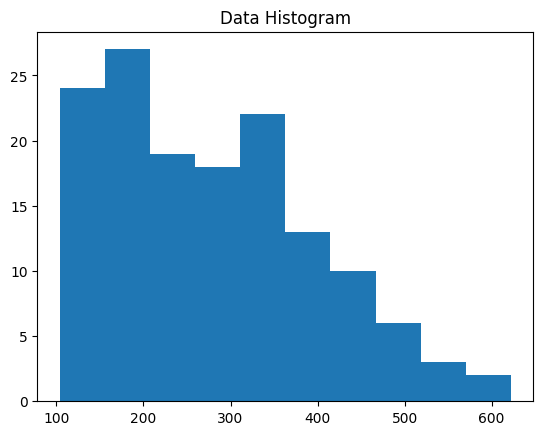

In [ ]:
# Using Histogram
plt.hist(data)
plt.title("Data Histogram")
plt.show()

Data is right-skewed so another indicator for non-stationarity

In [ ]:
# Using ADF test
result = adfuller(data)
adf_stat = result[0]
p_value = result[1]
print(f'ADF Test Statistics: {adf_stat}')
print(f'p-value: {p_value}')
alpha = 0.05  
if p_value <= alpha:
    print('Reject null hypothesis. Data is stationary.')
else:
    print('Fail to reject null hypothesis. Data is non-stationary.')

ADF Test Statistics: 0.8153688792060498
p-value: 0.991880243437641
Fail to reject null hypothesis. Data is non-stationary.


## Non-Stationary Data Transformation 

In [ ]:
train_data, test_data = fixed_partition(data, test_size=24)

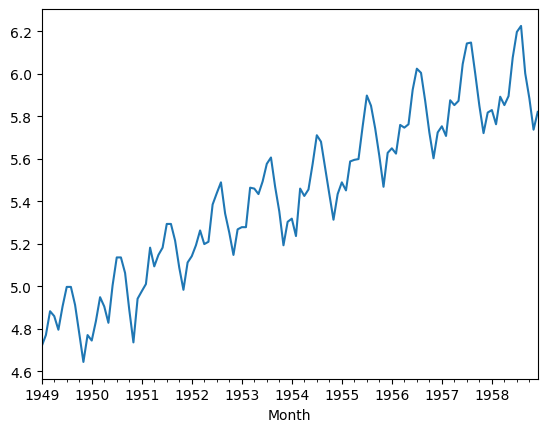

In [ ]:
train_data['Passengers_Box'] = boxcox(train_data['Passengers'] , lmbda=0)
train_data['Passengers_Box'].plot();

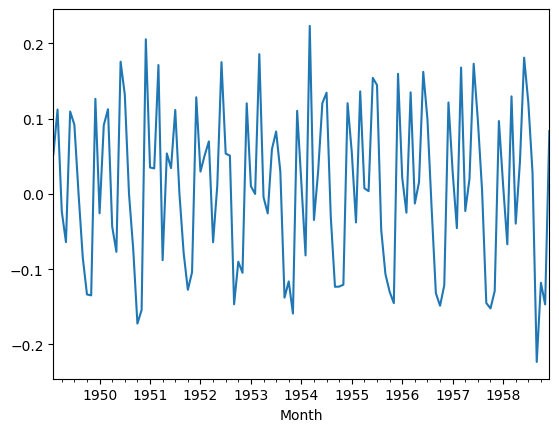

In [ ]:
data_trend_diff  = train_data['Passengers_Box'].diff(periods = 1)
data_trend_diff = data_trend_diff.dropna()
data_trend_diff.plot()
plt.show()

In [ ]:
# Now Lets Check The Stationarity of the data using ADF
stationary_data = data_trend_diff
result = adfuller(stationary_data)
adf_stat = result[0]
p_value = result[1]
print(f'ADF Test Statistics: {adf_stat}')
print(f'p-value: {p_value}')
alpha = 0.05  
if p_value <= alpha:
    print('Reject null hypothesis. Data is stationary.')
else:
    print('Fail to reject null hypothesis. Data is non-stationary.')

ADF Test Statistics: -2.3431700796884756
p-value: 0.15842238699553002
Fail to reject null hypothesis. Data is non-stationary.


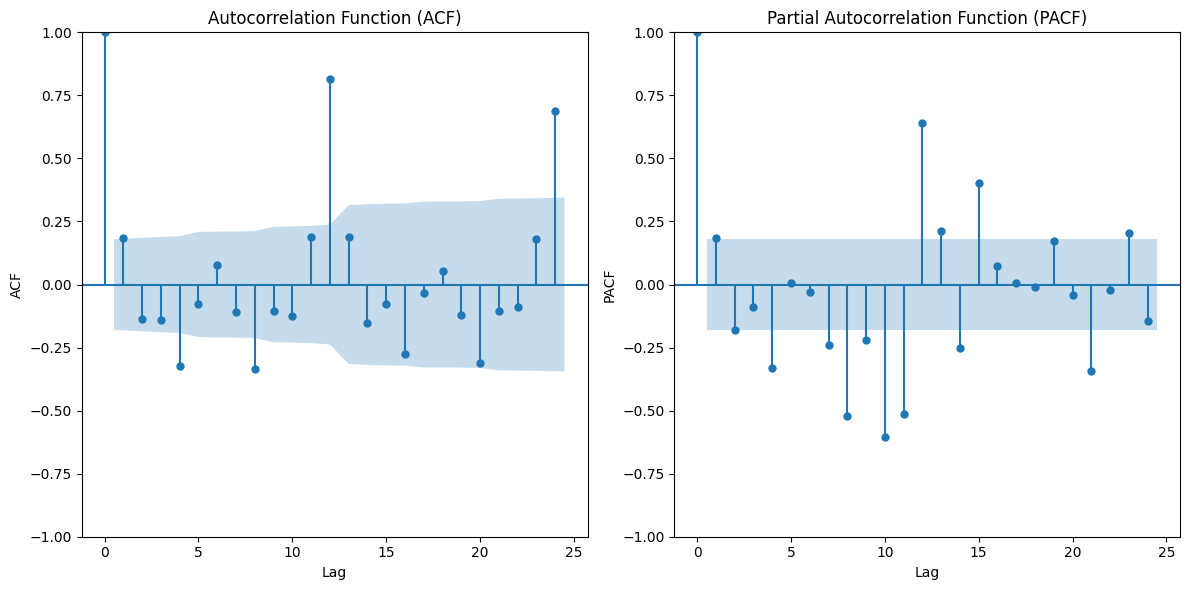

In [ ]:
# ACF, PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(stationary_data, lags=24, ax=ax1)
ax1.set_xlabel('Lag')
ax1.set_ylabel('ACF')
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(stationary_data, lags=24, ax=ax2)
ax2.set_xlabel('Lag')
ax2.set_ylabel('PACF')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Applying ARIMA Models

In [ ]:
arima_model_212 = ARIMA(endog = train_data['Passengers_Box'], order = (2,1,2)).fit()
print(arima_model_212.summary())

                               SARIMAX Results                                
Dep. Variable:         Passengers_Box   No. Observations:                  120
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 107.730
Date:                Thu, 06 Apr 2023   AIC                           -205.461
Time:                        13:32:13   BIC                           -191.565
Sample:                    01-01-1949   HQIC                          -199.818
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2555      0.191      1.336      0.181      -0.119       0.630
ar.L2          0.2383      0.237      1.007      0.314      -0.226       0.702
ma.L1         -0.1103      0.142     -0.775      0.4

In [ ]:
arima_model_210 = ARIMA(endog = train_data['Passengers_Box'], order = (2,1,0)).fit()
print(arima_model_210.summary())

                               SARIMAX Results                                
Dep. Variable:         Passengers_Box   No. Observations:                  120
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 102.386
Date:                Thu, 06 Apr 2023   AIC                           -198.771
Time:                        13:33:57   BIC                           -190.434
Sample:                    01-01-1949   HQIC                          -195.386
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2228      0.111      2.008      0.045       0.005       0.440
ar.L2         -0.1740      0.116     -1.494      0.135      -0.402       0.054
sigma2         0.0105      0.002      5.543      0.0

In [ ]:
arima_model_012 = ARIMA(endog = train_data['Passengers_Box'], order = (0,1,2)).fit()
print(arima_model_012.summary())

                               SARIMAX Results                                
Dep. Variable:         Passengers_Box   No. Observations:                  120
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 103.581
Date:                Thu, 06 Apr 2023   AIC                           -201.162
Time:                        13:33:57   BIC                           -192.825
Sample:                    01-01-1949   HQIC                          -197.777
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2051      0.091      2.252      0.024       0.027       0.384
ma.L2         -0.3049      0.088     -3.476      0.001      -0.477      -0.133
sigma2         0.0102      0.002      5.128      0.0

In [ ]:
arima_model_111 = ARIMA(endog = train_data['Passengers_Box'], order = (1,1,1)).fit()
print(arima_model_111.summary())

                               SARIMAX Results                                
Dep. Variable:         Passengers_Box   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 103.840
Date:                Thu, 06 Apr 2023   AIC                           -201.680
Time:                        13:33:57   BIC                           -193.342
Sample:                    01-01-1949   HQIC                          -198.294
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5761      0.191     -3.014      0.003      -0.951      -0.202
ma.L1          0.8347      0.117      7.131      0.000       0.605       1.064
sigma2         0.0102      0.002      5.556      0.0

We will use ARIMA(1,1,1) as the parameters are significaint, and the lowest AIC and BIC values

## Fixed

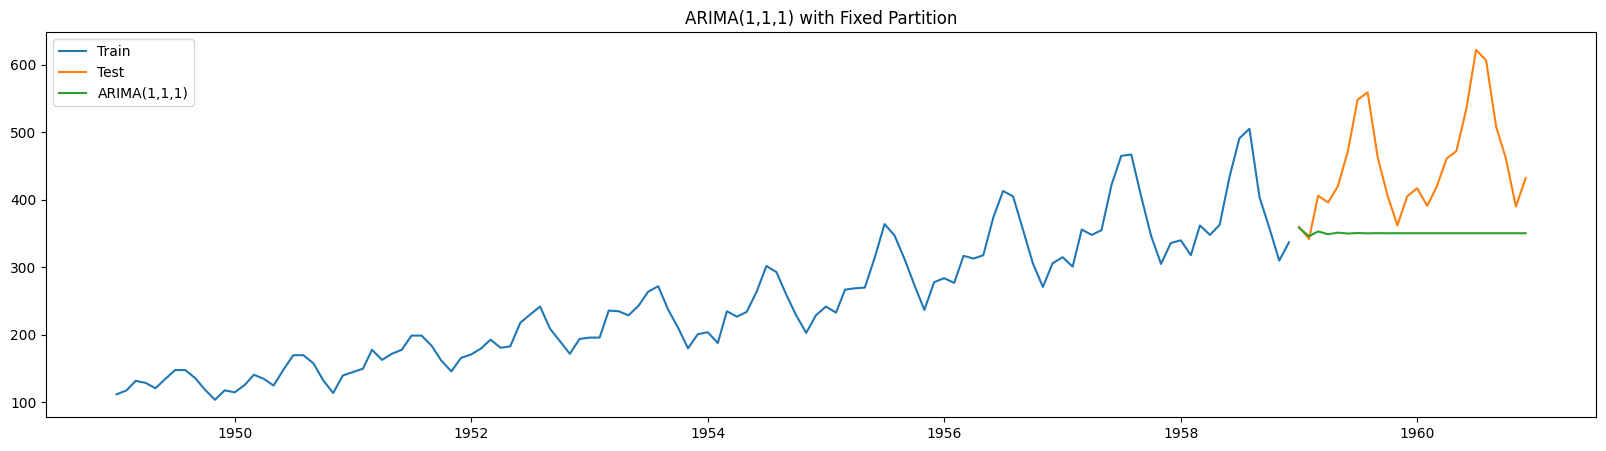

RMSE = 126.15526614217296


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

de_season_train_data = boxcox(train_data['Passengers'], lmbda=0)

arima_model_111 = ARIMA(de_season_train_data, order=(1,1,1)).fit()
boxcox_forecasts = arima_model_111.forecast(len(test_data))
forecasts = inv_boxcox(boxcox_forecasts, 0)


# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, forecasts, label='ARIMA(1,1,1)')
plt.title('ARIMA(1,1,1) with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], forecasts))

## Roll Forward

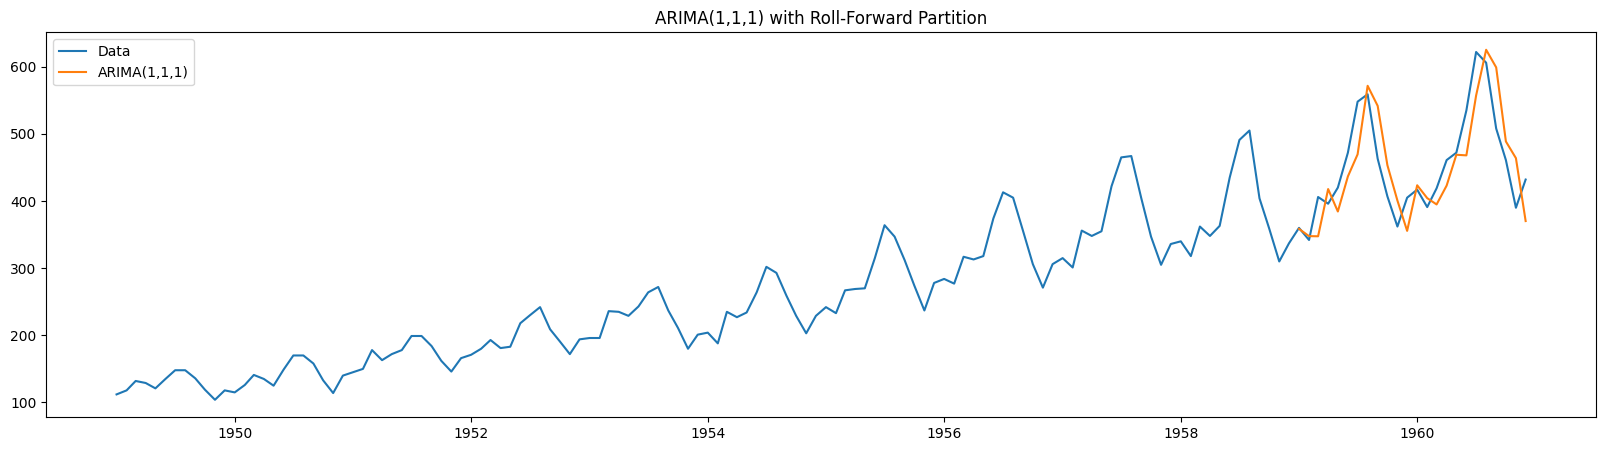

Mean RMSE = 39.722977959076836


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
rmse_list = []
forecasts_index = []
forecasts = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  de_season_train_data = boxcox(train_data['Passengers'], lmbda=0)
  arima_model_111 = ARIMA(de_season_train_data, order=(1,1,1)).fit()
  boxcox_forecasts = arima_model_111.forecast(len(test_data))
  forecasts.append(inv_boxcox(boxcox_forecasts, 0))
  forecasts_index.append(test_data.index)
  rmse_list.append(RMSE(test_data[-test_size: ], forecasts[-test_size:]))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(forecasts_index, forecasts, label='ARIMA(1,1,1)')
plt.title('ARIMA(1,1,1) with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("Mean RMSE =", np.mean(rmse_list))

## Cross Validation

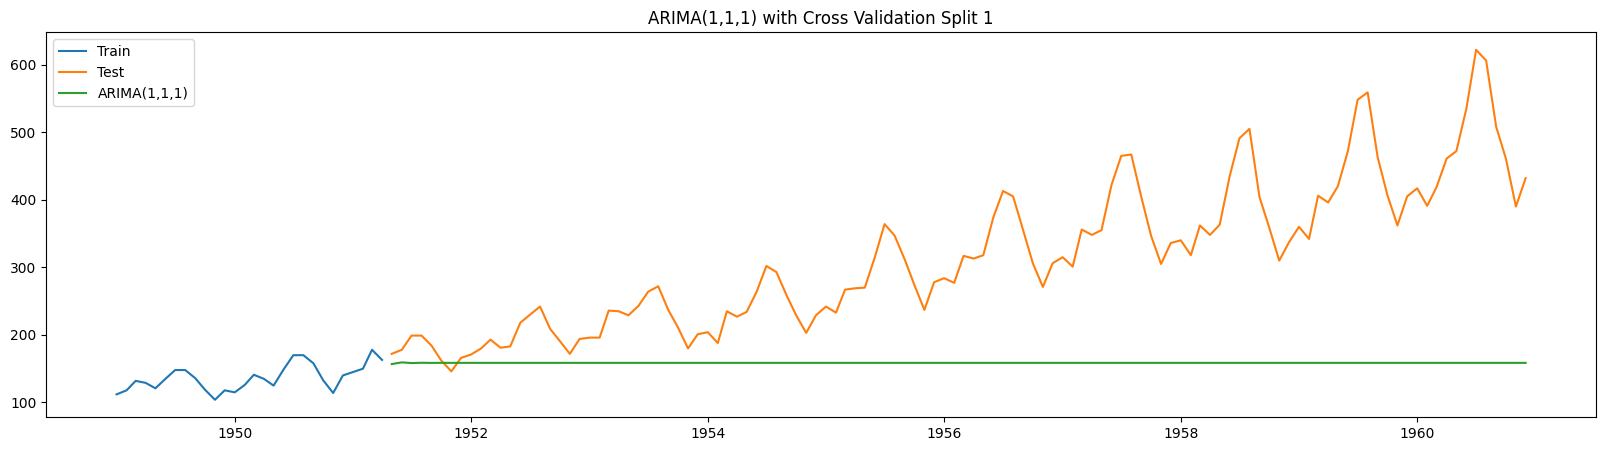

RMSE at split 1 = 189.52280950104912


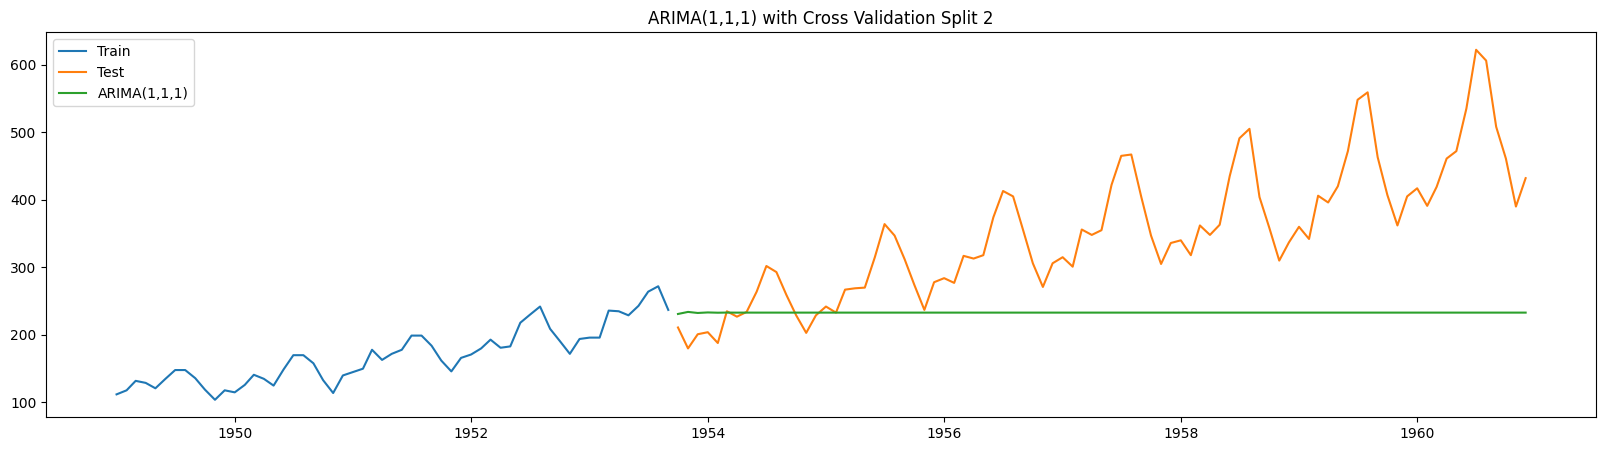

RMSE at split 2 = 153.7287380231994


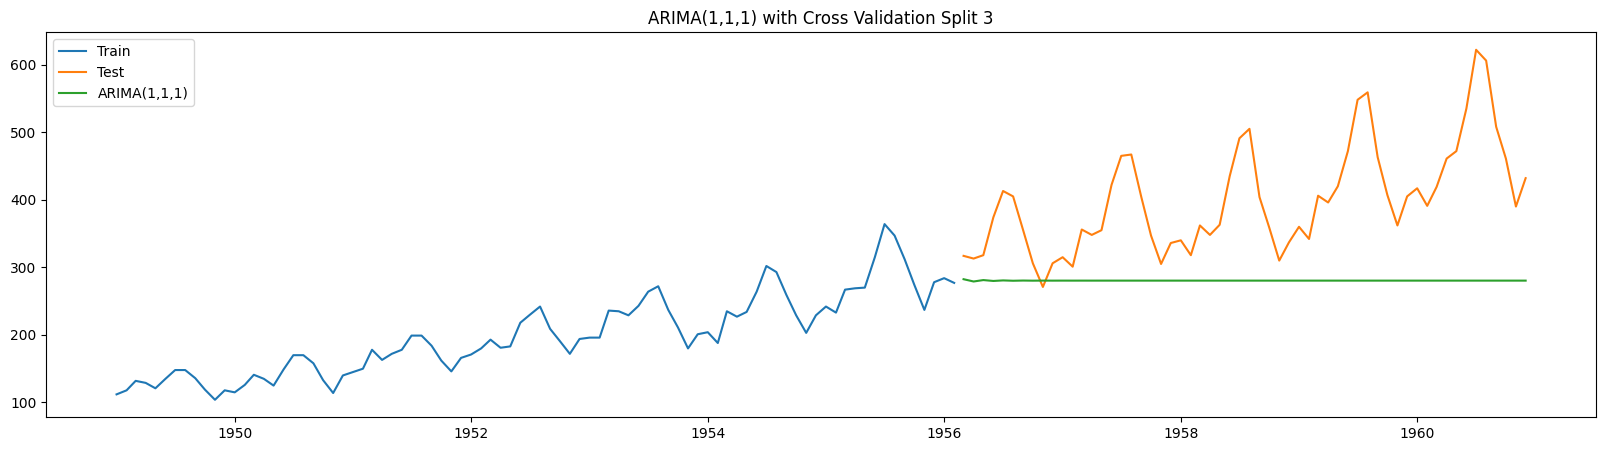

RMSE at split 3 = 143.4173400921334


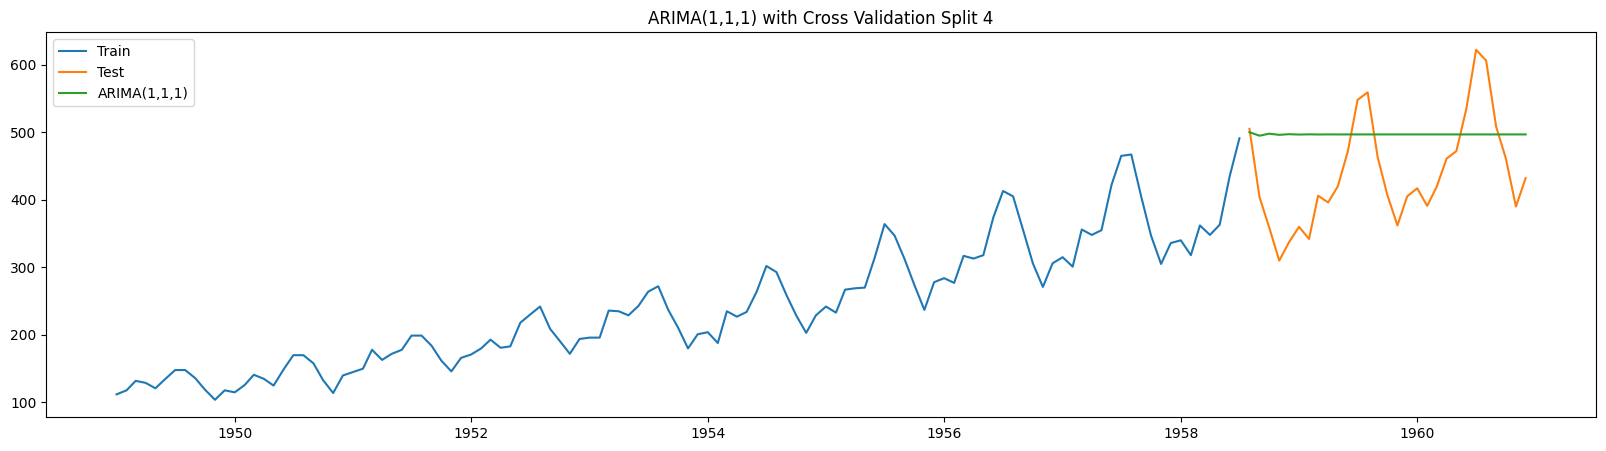

RMSE at split 4 = 96.32689422338504


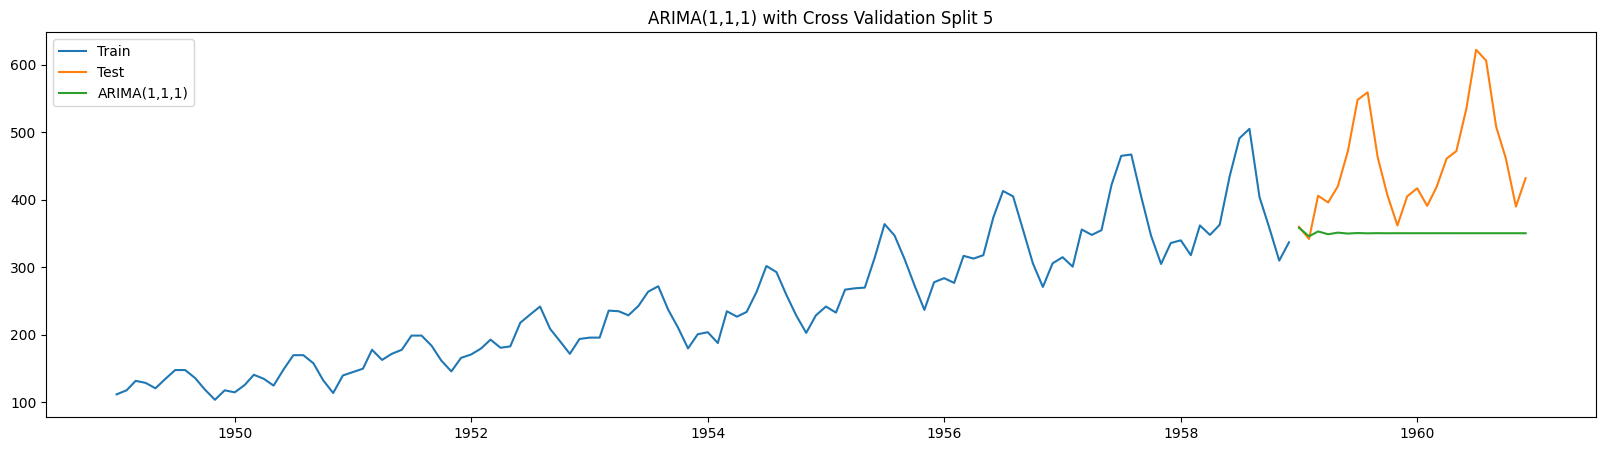

RMSE at split 5 = 126.15526614217296
Mean RMSE = 141.830209596388


In [ ]:
rmse_list = []
forecasts = []
for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  de_season_train_data = boxcox(train_data['Passengers'], lmbda=0)
  arima_model_12112 = ARIMA(de_season_train_data, order=(1,1,1)).fit()
  boxcox_forecasts = arima_model_12112.forecast(len(test_data))
  forecasts = inv_boxcox(boxcox_forecasts, 0)
  rmse_list.append(RMSE(test_data, forecasts))
  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(test_data.index, forecasts, label='ARIMA(1,1,1)')
  plt.title(f'ARIMA(1,1,1) with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list)) 

## Report

We used ARIMA(1,1,1), but it's not right, as the data entered to the ARIMA still has seasonality. The usage of ARIMA in this dataset is not a valid choice du to the high seasonality present. The logical thing to do would to use SARIMA to capture the seasonality.

- Fixed Partition: ARIMA is not the best model to use for long term forecasting, the performance here is good, but again this should not be the case for long term forecasting.

- Roll Forward: ARIMA is a good choice here as we're forecasting a shorter period.

- Cross Validation: Same applies as Fixed Parititon.

# 7 - 2 SARIMA

In [ ]:
train_data, test_data = fixed_partition(data, test_size=24)

In [ ]:
data_boxcox = pd.Series(boxcox(train_data['Passengers'] , lmbda=0), index=train_data.index)

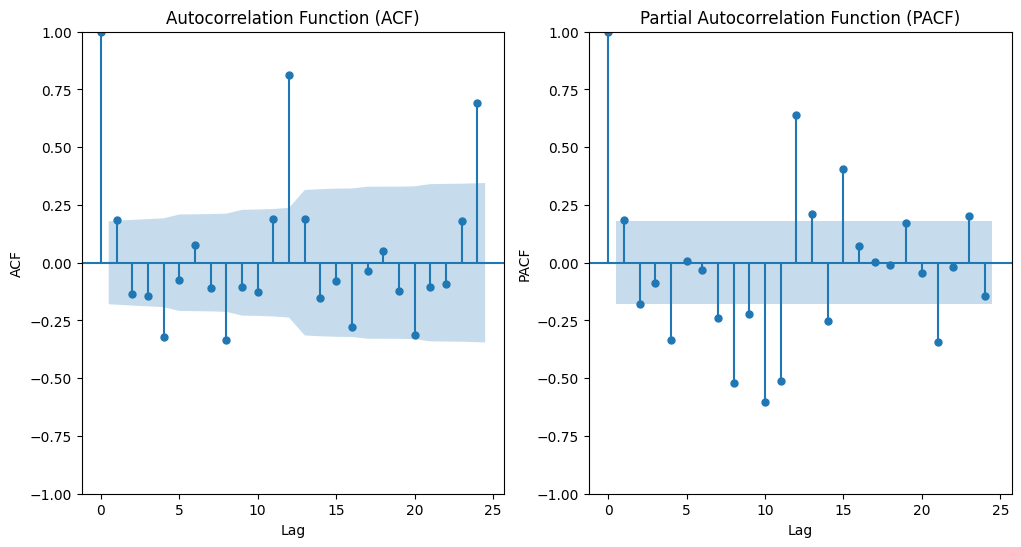

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(stationary_data, lags=24, ax=ax1)
ax1.set_xlabel('Lag')
ax1.set_ylabel('ACF')
ax1.set_title('Autocorrelation Function (ACF)')


plot_pacf(stationary_data, lags=24, ax=ax2)
ax2.set_xlabel('Lag')
ax2.set_ylabel('PACF')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

## Applying SARIMA

In [ ]:
sarima_1 = SARIMAX(endog = data_boxcox, order = (1,1,1), seasonal_order=(1,1,1,12)).fit()
print(sarima_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 197.720
Date:                            Thu, 06 Apr 2023   AIC                           -385.441
Time:                                    13:45:23   BIC                           -372.076
Sample:                                01-01-1949   HQIC                          -380.023
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2019      0.267      0.757      0.449      -0.321       0.724
ma.L1         -0.5392      0.240   

In [ ]:
sarima_2 = SARIMAX(endog = data_boxcox, order = (1,1,1), seasonal_order=(2,1,1,12)).fit()
print(sarima_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 197.653
Date:                            Thu, 06 Apr 2023   AIC                           -383.306
Time:                                    13:45:39   BIC                           -367.269
Sample:                                01-01-1949   HQIC                          -376.805
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1211      0.252      0.481      0.630      -0.372       0.614
ma.L1         -0.4952      0.230   

From looking at AIC and BIC and the significance of the parameters, we can deduce that using SARIMA(1,1,1)(1,1,1,12) yields the best results due to having the lowest AIC and BIC.

## Fixed

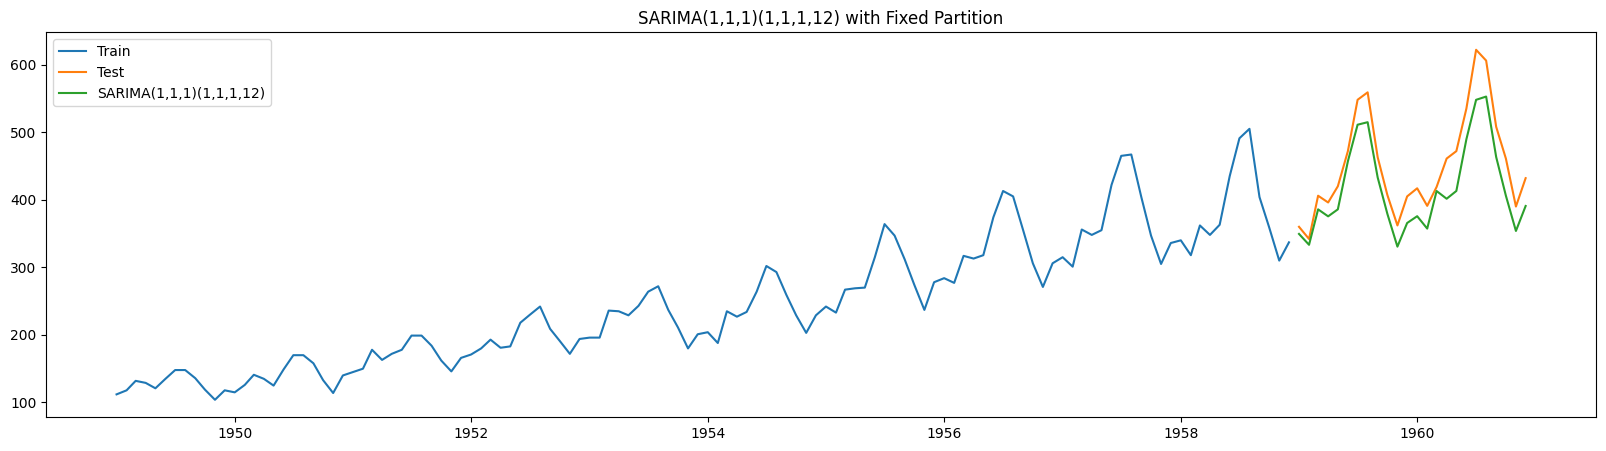

RMSE = 39.90745360472275


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

de_season_train_data = boxcox(train_data['Passengers'], lmbda=0)

sarima_1 = SARIMAX(de_season_train_data, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
boxcox_forecasts = sarima_1.forecast(len(test_data))
forecasts = inv_boxcox(boxcox_forecasts, 0)


# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, forecasts, label='SARIMA(1,1,1)(1,1,1,12)')
plt.title('SARIMA(1,1,1)(1,1,1,12) with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], forecasts))

## Roll Forward

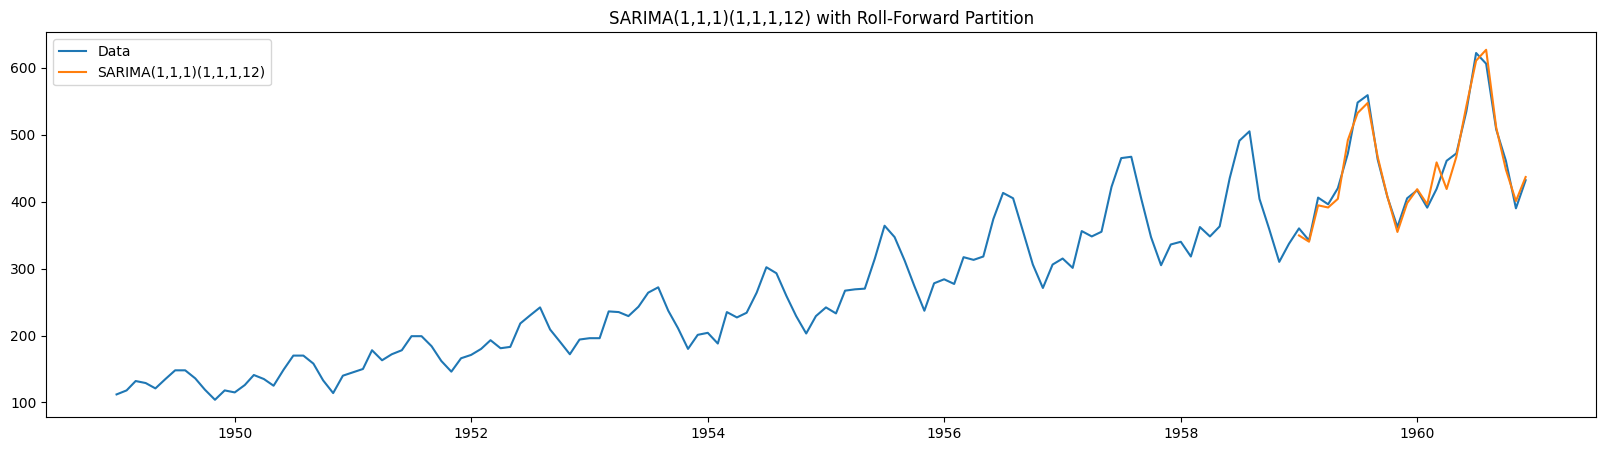

Mean RMSE = 11.507360728344237


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
rmse_list = []
forecasts_index = []
forecasts = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  de_season_train_data = boxcox(train_data['Passengers'], lmbda=0)
  sarima_1 = SARIMAX(de_season_train_data, order = (1,1,1), seasonal_order=(1,1,1,12)).fit()
  boxcox_forecasts = sarima_1.forecast(len(test_data))
  forecasts.append(inv_boxcox(boxcox_forecasts, 0))
  forecasts_index.append(test_data.index)
  rmse_list.append(RMSE(test_data[-test_size: ], forecasts[-test_size:]))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(forecasts_index, forecasts, label='SARIMA(1,1,1)(1,1,1,12)')
plt.title('SARIMA(1,1,1)(1,1,1,12) with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("Mean RMSE =", np.mean(rmse_list))

## Cross Validation

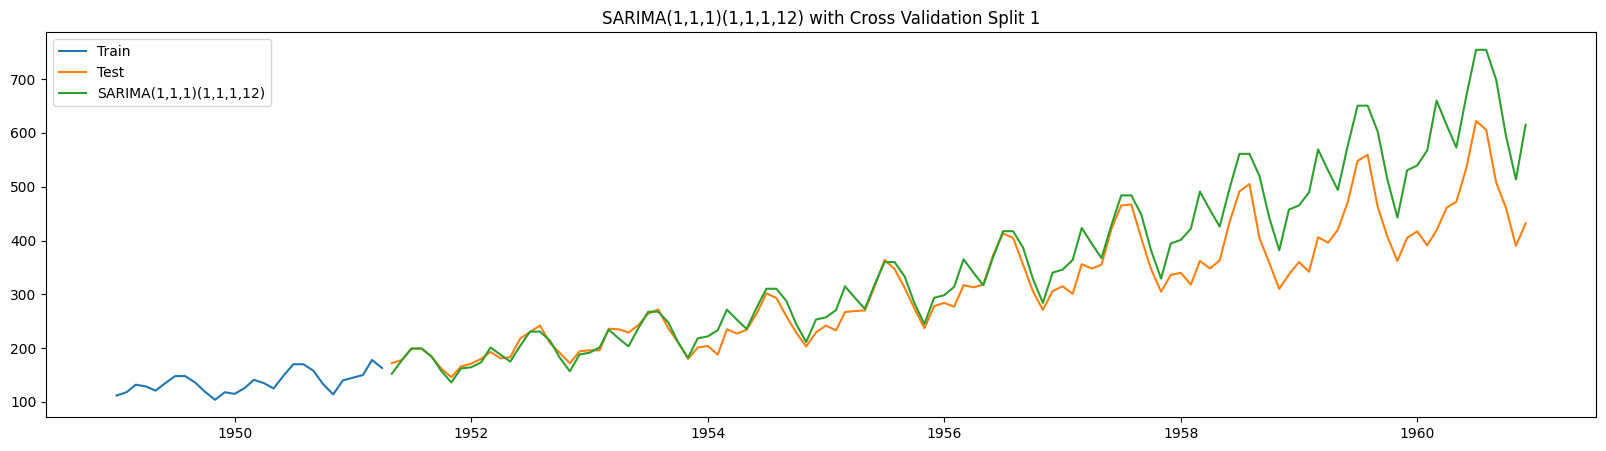

RMSE at split 1 = 72.28128268330532


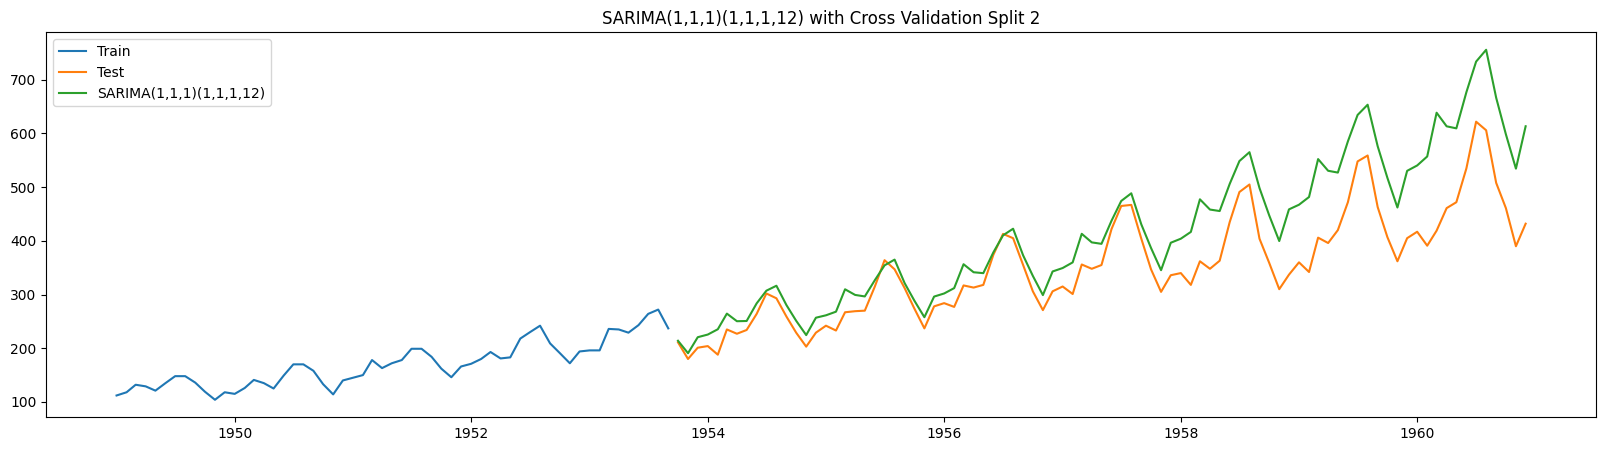

RMSE at split 2 = 82.41476063363012


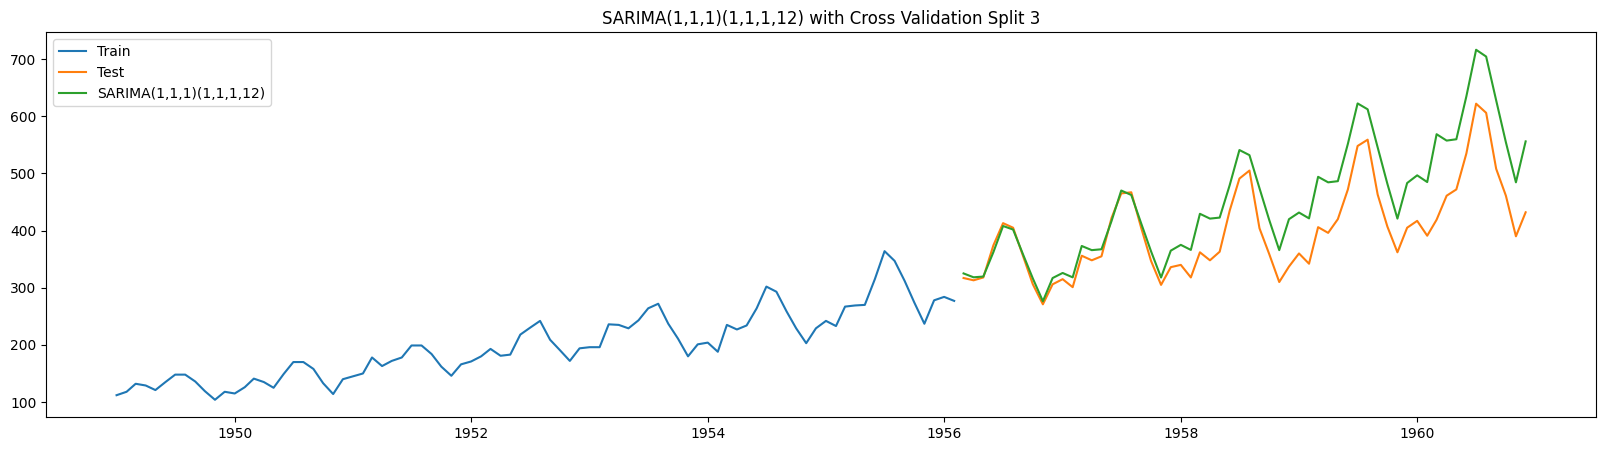

RMSE at split 3 = 64.64387027531731


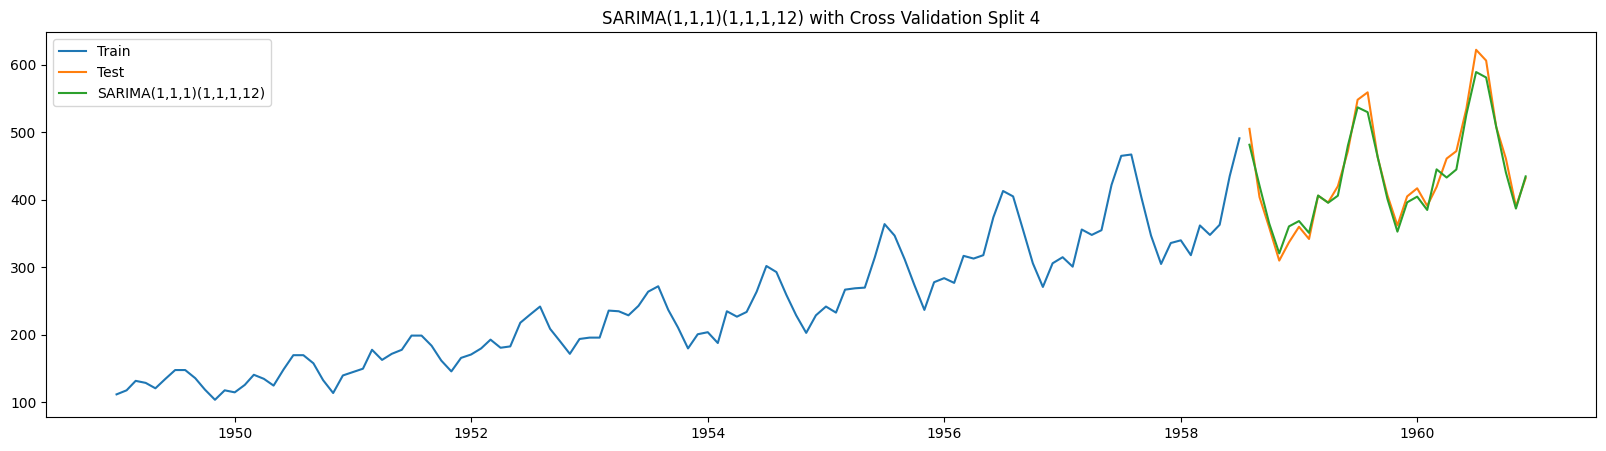

RMSE at split 4 = 16.35804273606538


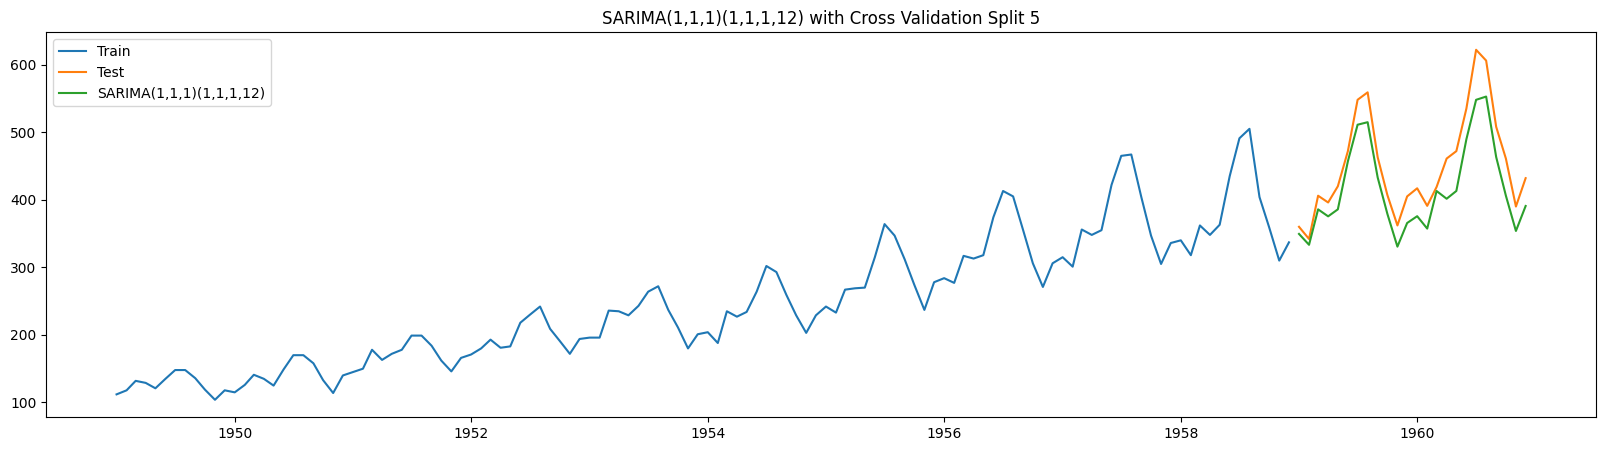

RMSE at split 5 = 39.90745360472275
Mean RMSE = 55.12108198660818


In [ ]:
rmse_list = []
forecasts = []
for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  de_season_train_data = boxcox(train_data['Passengers'], lmbda=0)
  sarima_1 = SARIMAX(de_season_train_data, order = (1,1,1), seasonal_order=(1,1,1,12)).fit()
  boxcox_forecasts = sarima_1.forecast(len(test_data))
  forecasts = inv_boxcox(boxcox_forecasts, 0)
  rmse_list.append(RMSE(test_data, forecasts))
  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(test_data.index, forecasts, label='SARIMA(1,1,1)(1,1,1,12)')
  plt.title(f'SARIMA(1,1,1)(1,1,1,12) with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list)) 

## Report

In general SARIMA would be one of the best models to use in this dataset, as it would be able to capture both the trend and seasonality and it's reflected in the results of the model

- Fixed Partition: The model seems to be performing quite well as it get the seasonality of the data right, but it's still of by some margin as we're predicting a longer period.

- Roll Forward: SARIMA performs the best in this approach as we're giving the model reasonable amount of data to train on, and we're using it to forecast a shorter perdiod.

- Cross Validation: Same as in fixed paritition, but as the train data size increases the model get better.

# 8 - 1 Single Exponential Smoothing

## Fixed

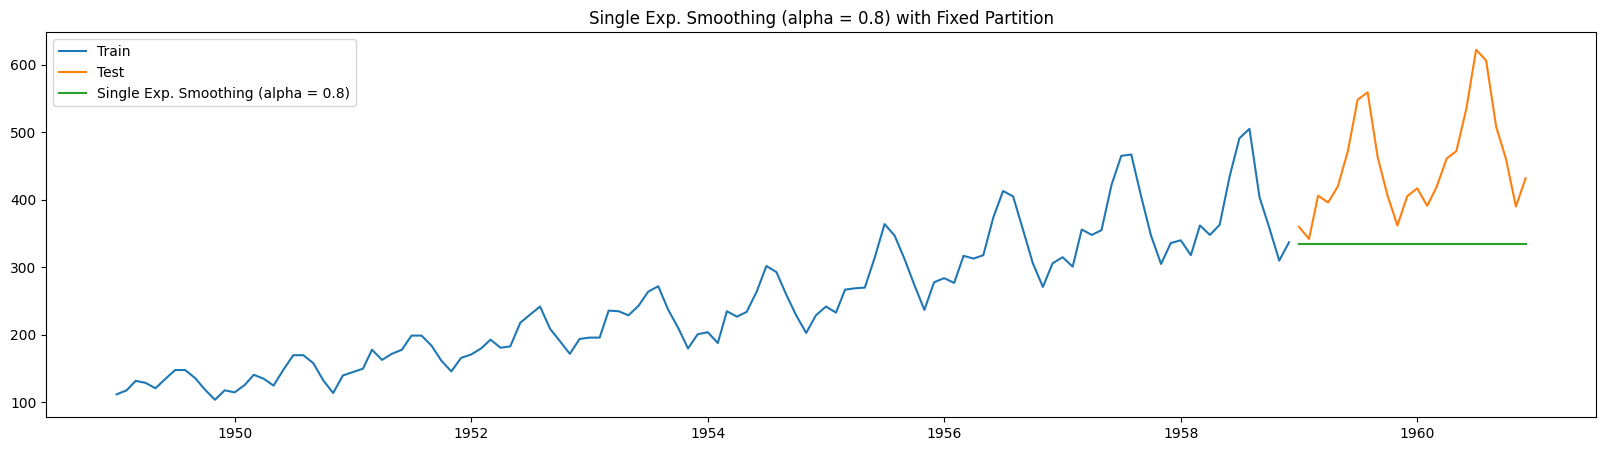

RMSE = 139.79481505129573


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)

alpha = 0.8
# fit model with high alpha to track the changes in the data quicker
single_exp_model = SimpleExpSmoothing(train_data['Passengers']).fit(smoothing_level=alpha)

forecasts = single_exp_model.forecast(len(test_data))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, forecasts, label=f'Single Exp. Smoothing (alpha = {alpha})')
plt.title(f'Single Exp. Smoothing (alpha = {alpha}) with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], forecasts))

## Roll Forward

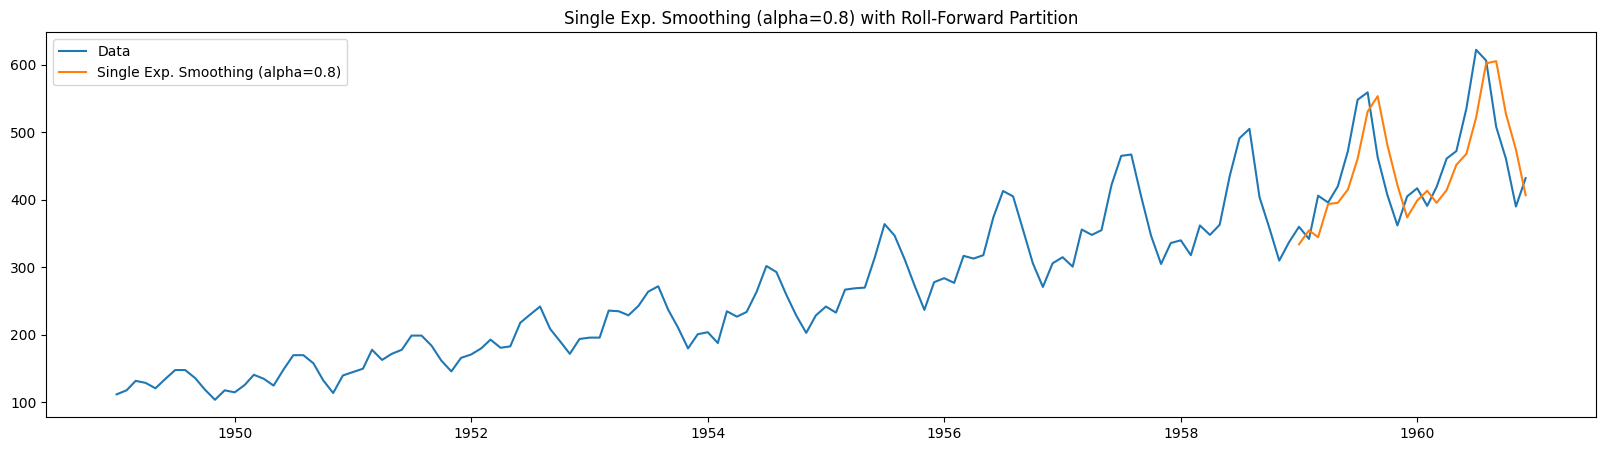

Mean RMSE = 47.11002953740725


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
rmse_list = []
forecasts_index = []
forecasts = []
alpha = 0.8
for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  single_exp_model = SimpleExpSmoothing(train_data['Passengers']).fit(smoothing_level = alpha)
  forecasts.append(single_exp_model.forecast(len(test_data)))
  forecasts_index.append(test_data.index)
  rmse_list.append(RMSE(test_data[-test_size: ], forecasts[-test_size:]))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(forecasts_index, forecasts, label=f'Single Exp. Smoothing (alpha={alpha})')
plt.title(f'Single Exp. Smoothing (alpha={alpha}) with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("Mean RMSE =", np.mean(rmse_list))

## Cross Validation

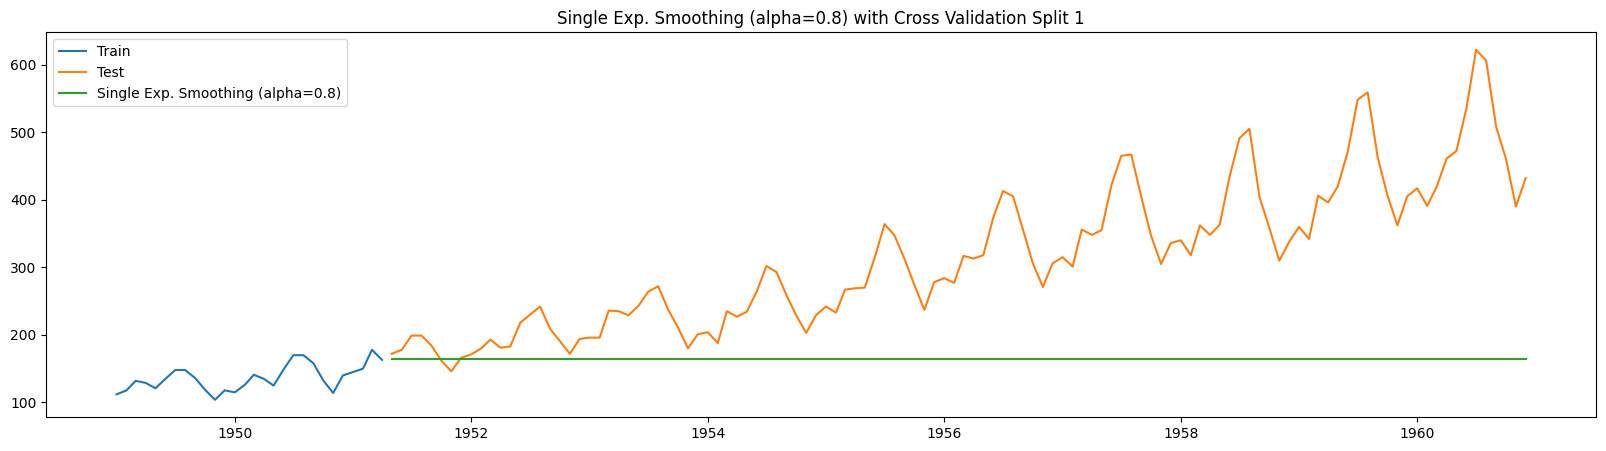

RMSE at split 1 = 184.44289139455233


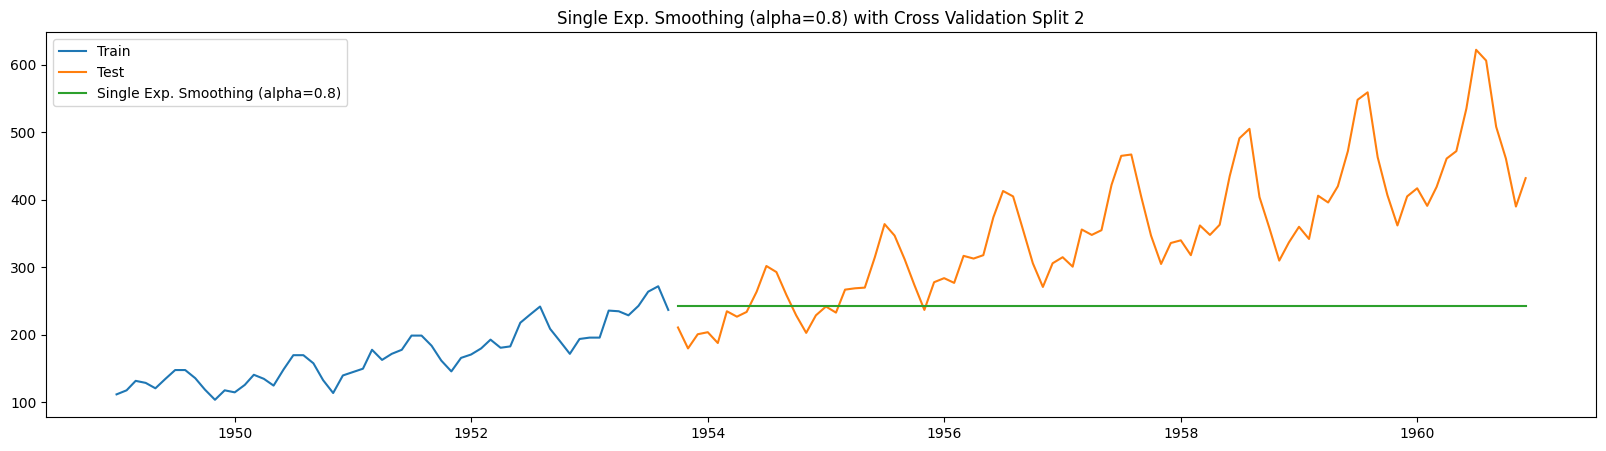

RMSE at split 2 = 145.7368467399387


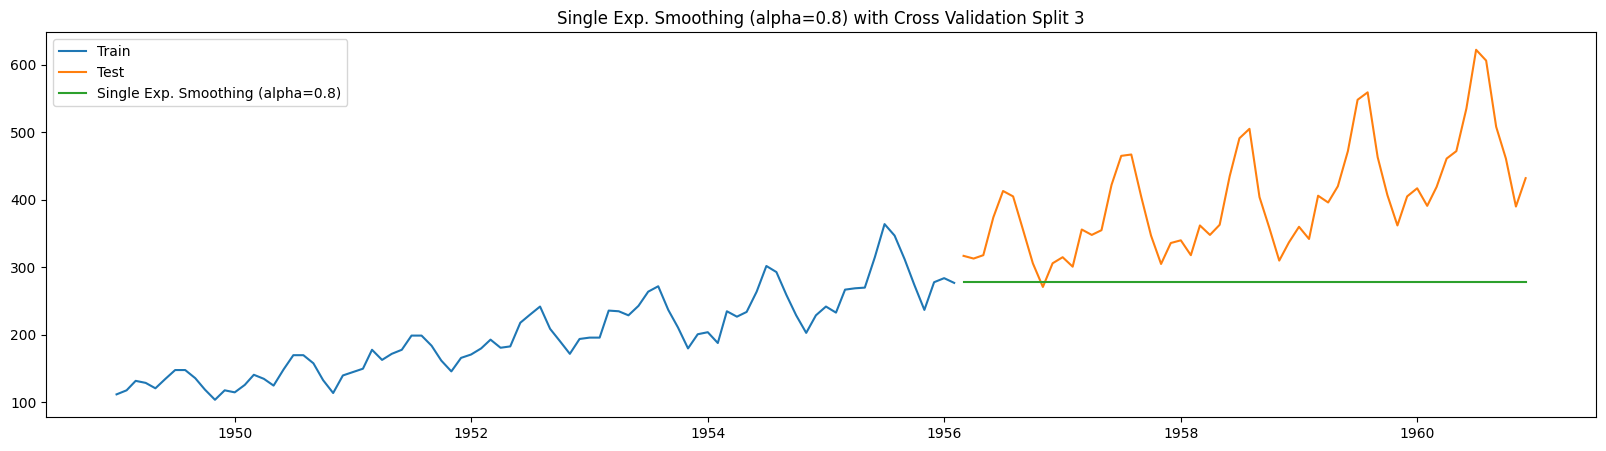

RMSE at split 3 = 145.47408865211204


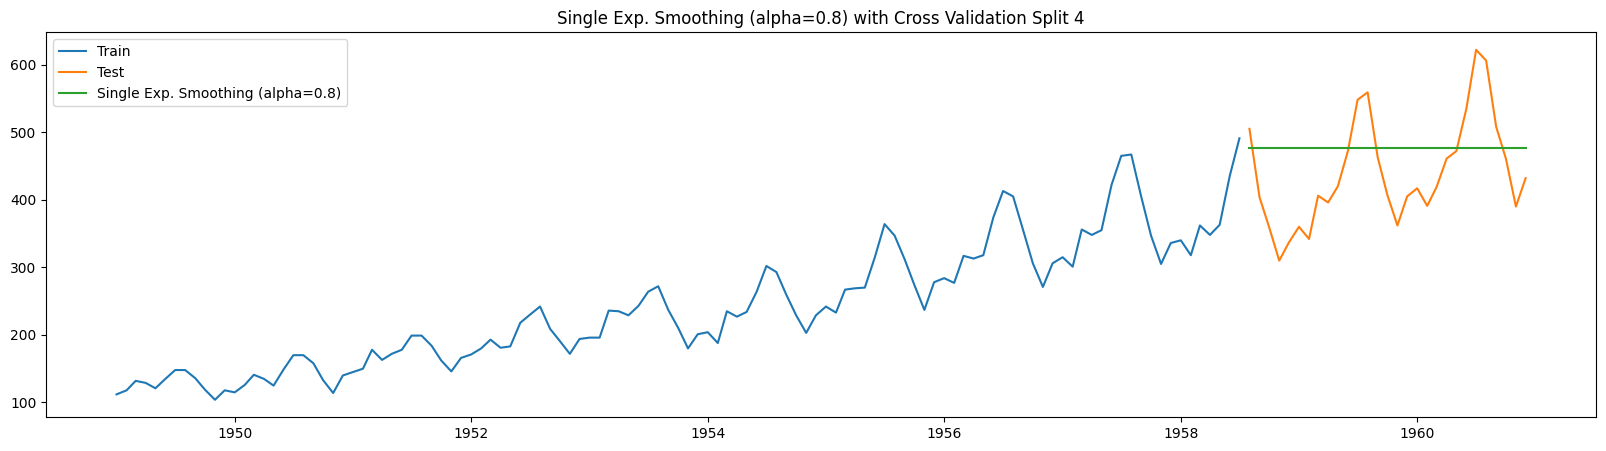

RMSE at split 4 = 86.23623032278584


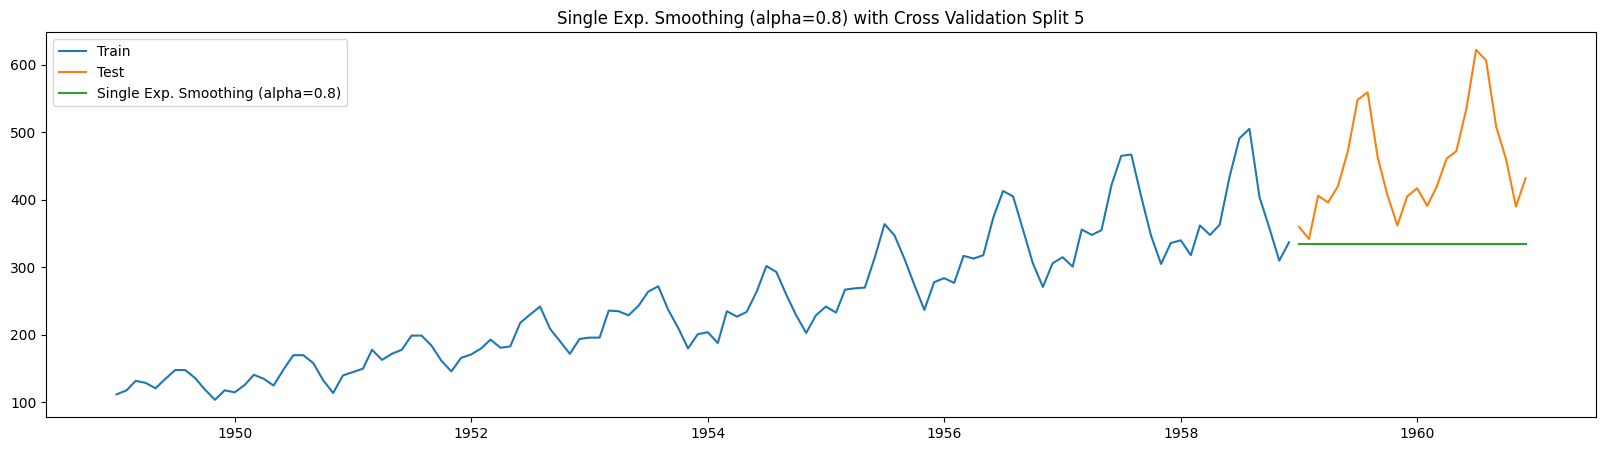

RMSE at split 5 = 139.79481505129573
Mean RMSE = 140.3369744321369


In [ ]:
rmse_list = []
forecasts = []
for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  single_exp_model = SimpleExpSmoothing(train_data['Passengers']).fit(smoothing_level=alpha)
  forecasts = single_exp_model.forecast(len(test_data))
  rmse_list.append(RMSE(test_data, forecasts))
  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(test_data.index, forecasts, label=f'Single Exp. Smoothing (alpha={alpha})')
  plt.title(f'Single Exp. Smoothing (alpha={alpha}) with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list))

## Report

We used alpha (smoothing factor) with 0.8 which is a high value to be able to capture changes in the data faster.

- Fixed Partition: The model can't be used for long forecasting periods, since it woud just assume all the periods of forecasting to have the same value as the first forecasting period.

- Roll Forward: Using it with shorter forecasting periods seems to have yielded relatively not so bad results, this is due to the high alpha.

- Cross Validation: We observe the same issue as the fixed partition, the model can't be used to forecast longer periods, since it lacks any information about the trend or seasonality.

# 8 - 2 Double Exponential Smoothing 

## Fixed

### Additive

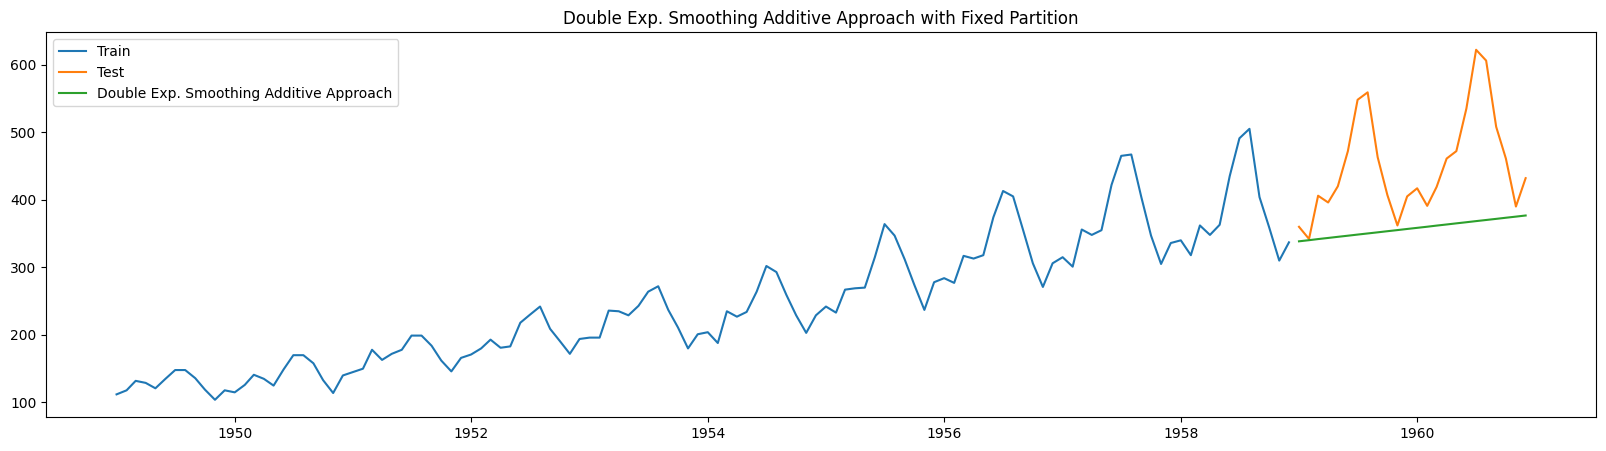

RMSE = 118.31685230398281


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)



triple_exp_model = Holt(train_data['Passengers']).fit(optimized=True)

forecasts = triple_exp_model.forecast(len(test_data))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, forecasts, label=f'Double Exp. Smoothing Additive Approach')
plt.title(f'Double Exp. Smoothing Additive Approach with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], forecasts))

### Multiplicative

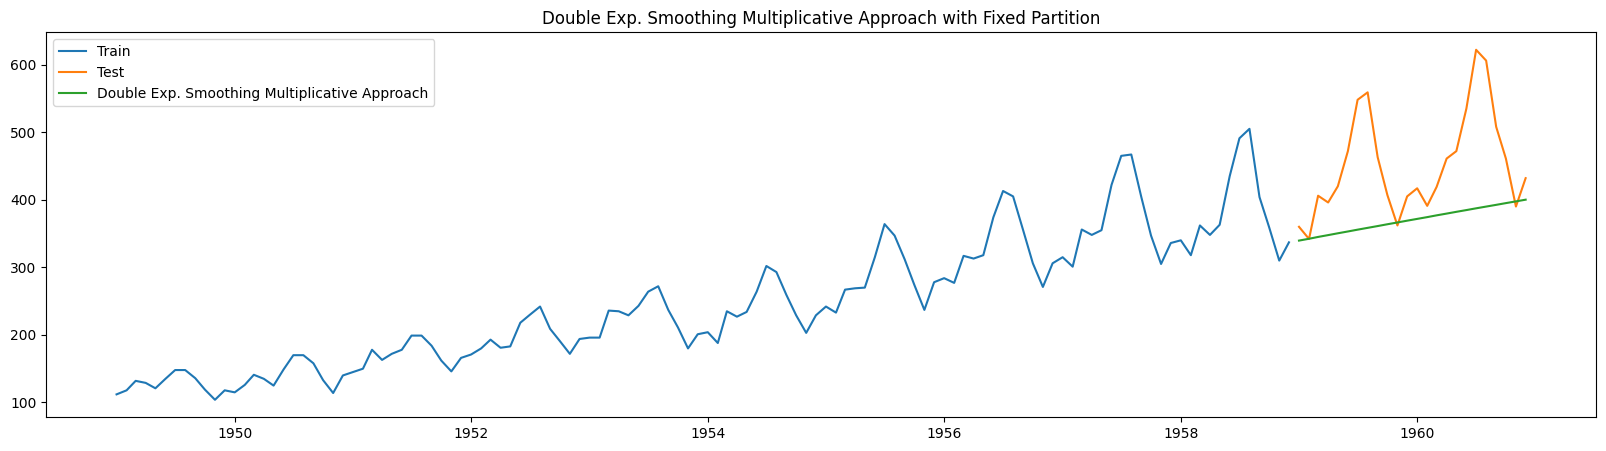

RMSE = 107.63709928403163


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)



triple_exp_model = ExponentialSmoothing(train_data, trend='mul', seasonal=None, damped=True).fit(optimized=True)

forecasts = triple_exp_model.forecast(len(test_data))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, forecasts, label=f'Double Exp. Smoothing Multiplicative Approach')
plt.title(f'Double Exp. Smoothing Multiplicative Approach with Fixed Partition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], forecasts))

## Roll Forward

### Additive

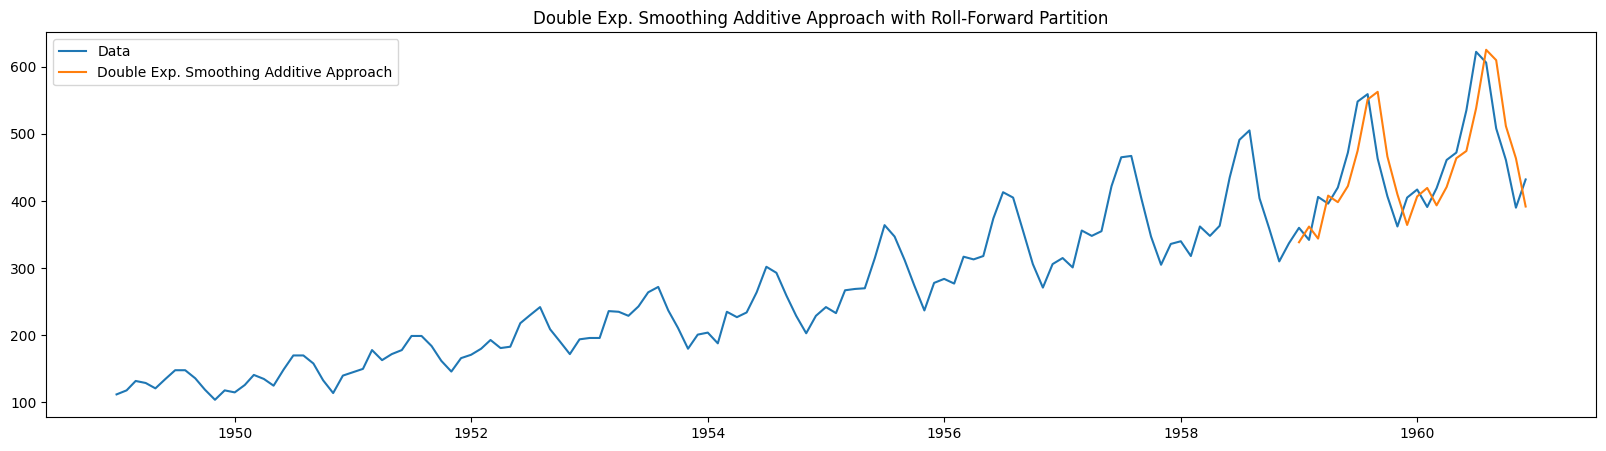

Mean RMSE = 44.080024738354304


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
rmse_list = []
forecasts_index = []
forecasts = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  triple_exp_model = Holt(train_data['Passengers']).fit(optimized=True)
  forecasts.append(triple_exp_model.forecast(len(test_data)))
  forecasts_index.append(test_data.index)
  rmse_list.append(RMSE(test_data[-test_size: ], forecasts[-test_size:]))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(forecasts_index, forecasts, label=f'Double Exp. Smoothing Additive Approach')
plt.title(f'Double Exp. Smoothing Additive Approach with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("Mean RMSE =", np.mean(rmse_list))

### Multiplicative

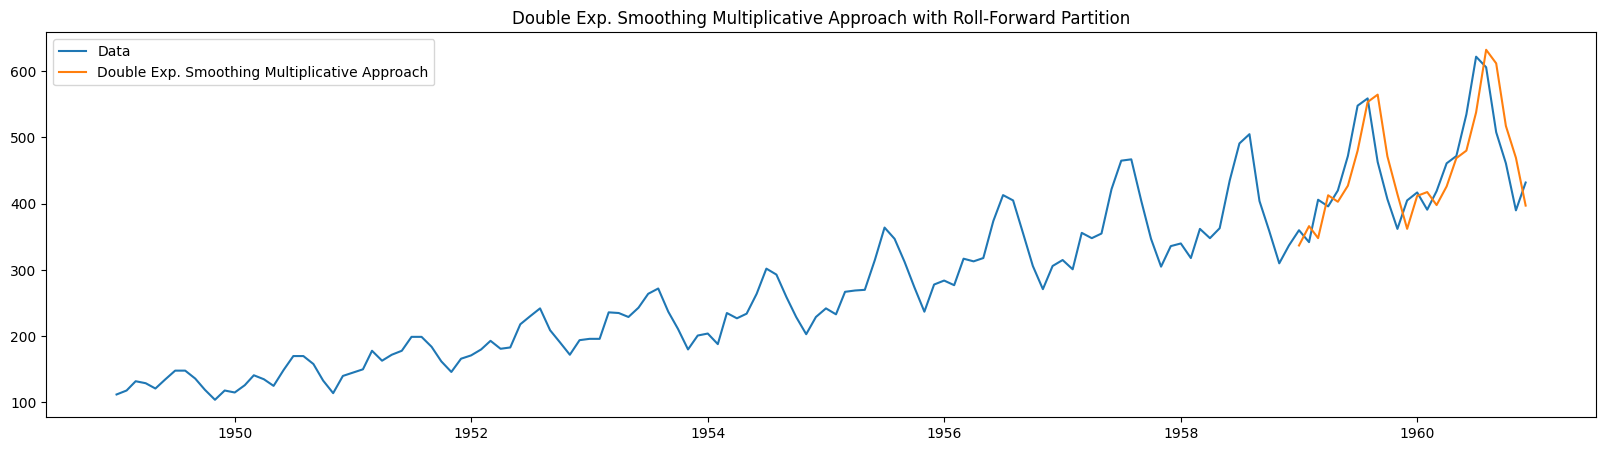

Mean RMSE = 43.718043406139714


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
rmse_list = []
forecasts_index = []
forecasts = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  triple_exp_model = ExponentialSmoothing(train_data, trend='mul', seasonal=None).fit(optimized=True)
  forecasts.append(triple_exp_model.forecast(len(test_data)))
  forecasts_index.append(test_data.index)
  rmse_list.append(RMSE(test_data[-test_size: ], forecasts[-test_size:]))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(forecasts_index, forecasts, label=f'Double Exp. Smoothing Multiplicative Approach')
plt.title(f'Double Exp. Smoothing Multiplicative Approach with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("Mean RMSE =", np.mean(rmse_list))

## Cross Validation

### Additive

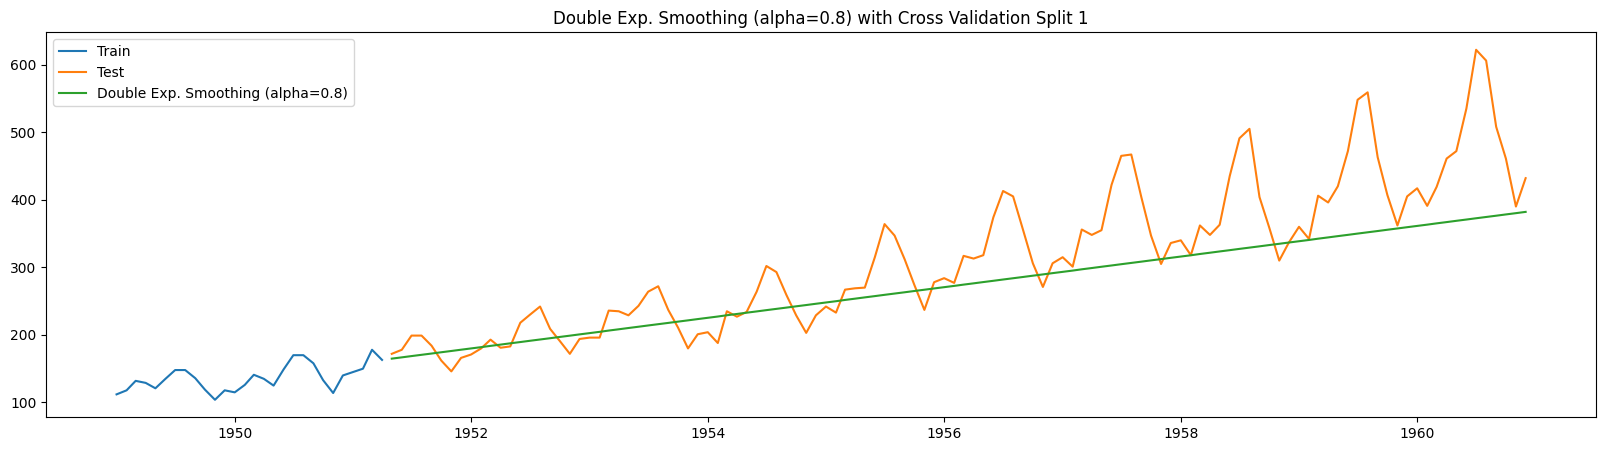

RMSE at split 1 = 71.91364011282126


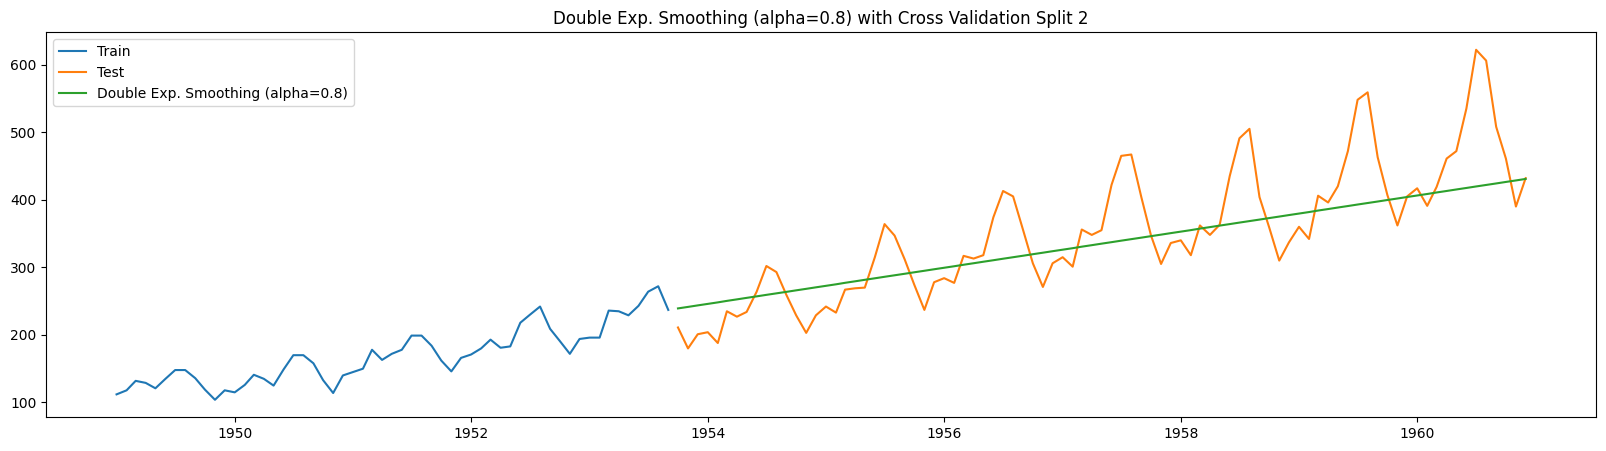

RMSE at split 2 = 62.06328880023014


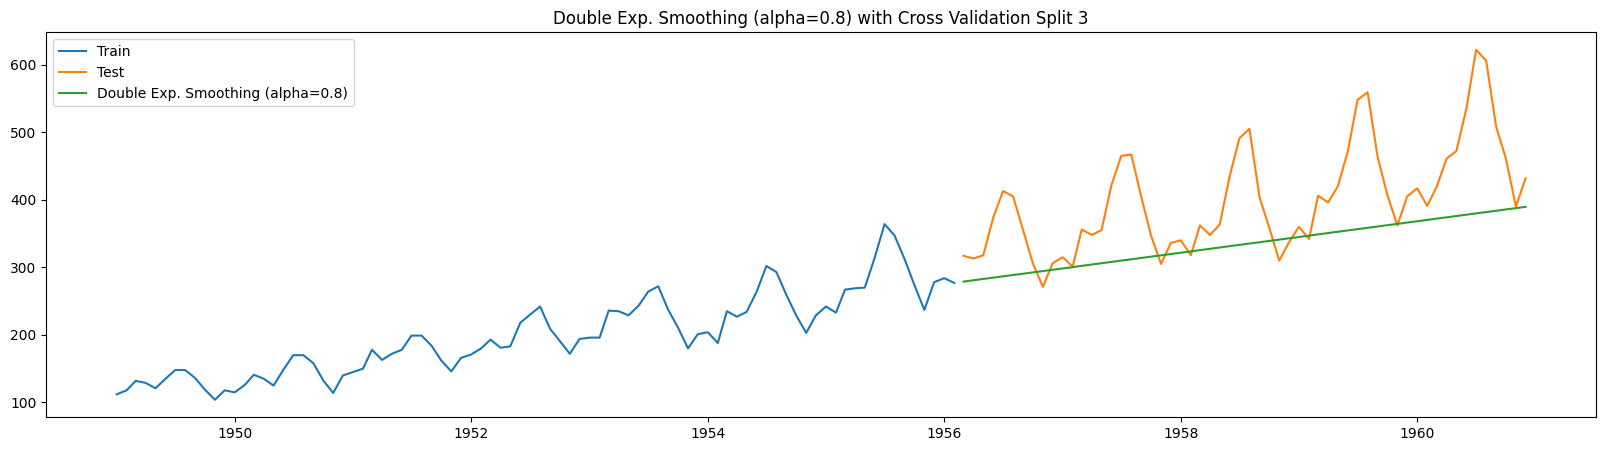

RMSE at split 3 = 91.98465784269936


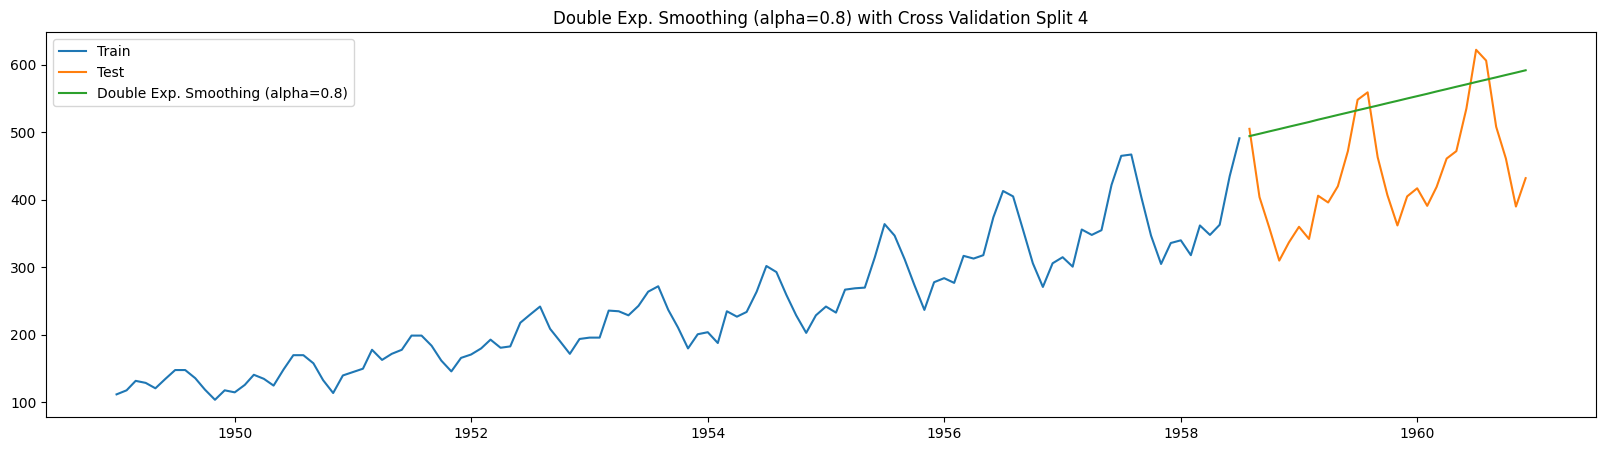

RMSE at split 4 = 124.26953521129168


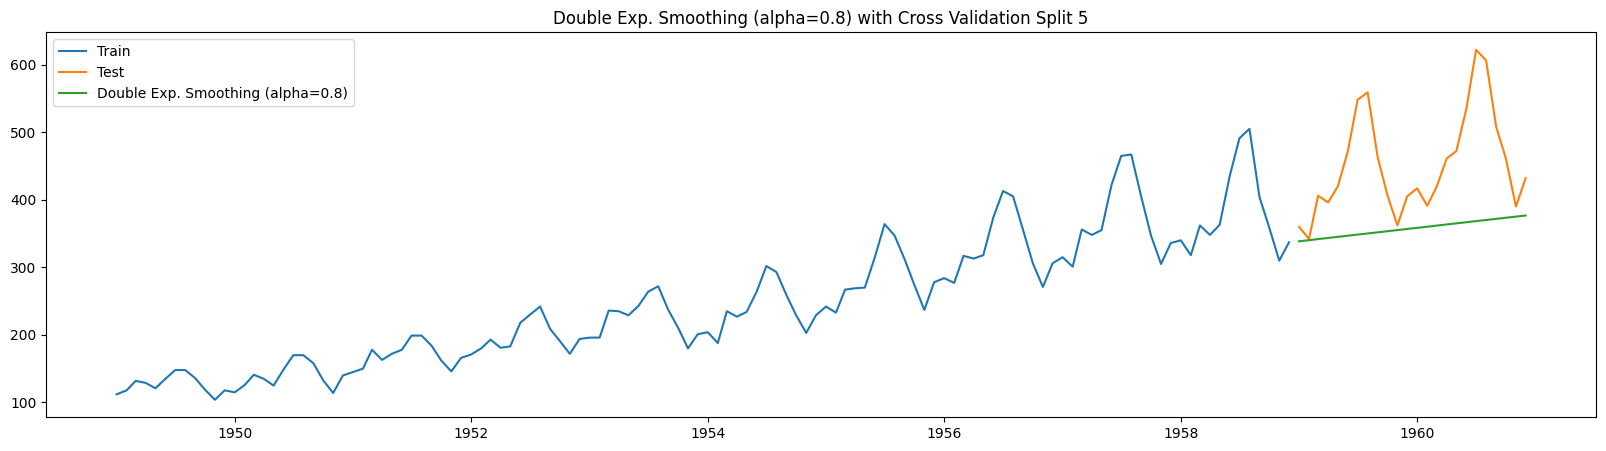

RMSE at split 5 = 118.31685230398281
Mean RMSE = 93.70959485420505


In [ ]:
rmse_list = []
forecasts = []
for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  single_exp_model = Holt(train_data['Passengers']).fit(optimized=True)
  forecasts = single_exp_model.forecast(len(test_data))
  rmse_list.append(RMSE(test_data, forecasts))
  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(test_data.index, forecasts, label=f'Double Exp. Smoothing (alpha={alpha})')
  plt.title(f'Double Exp. Smoothing (alpha={alpha}) with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list))

### Multiplicative

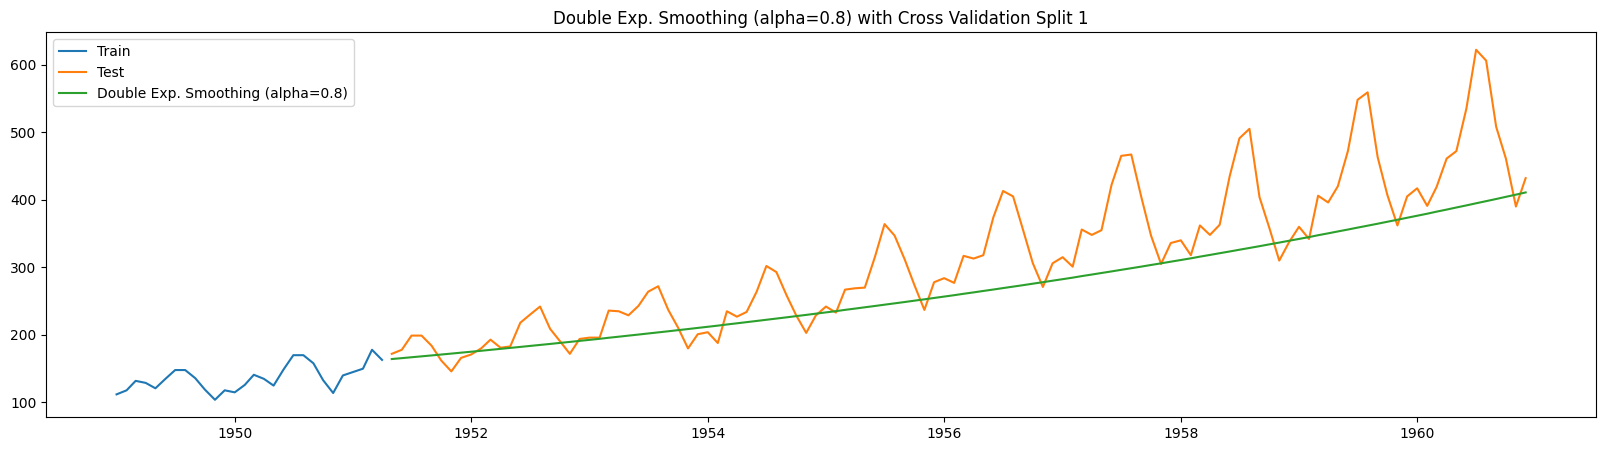

RMSE at split 1 = 71.2497567097377


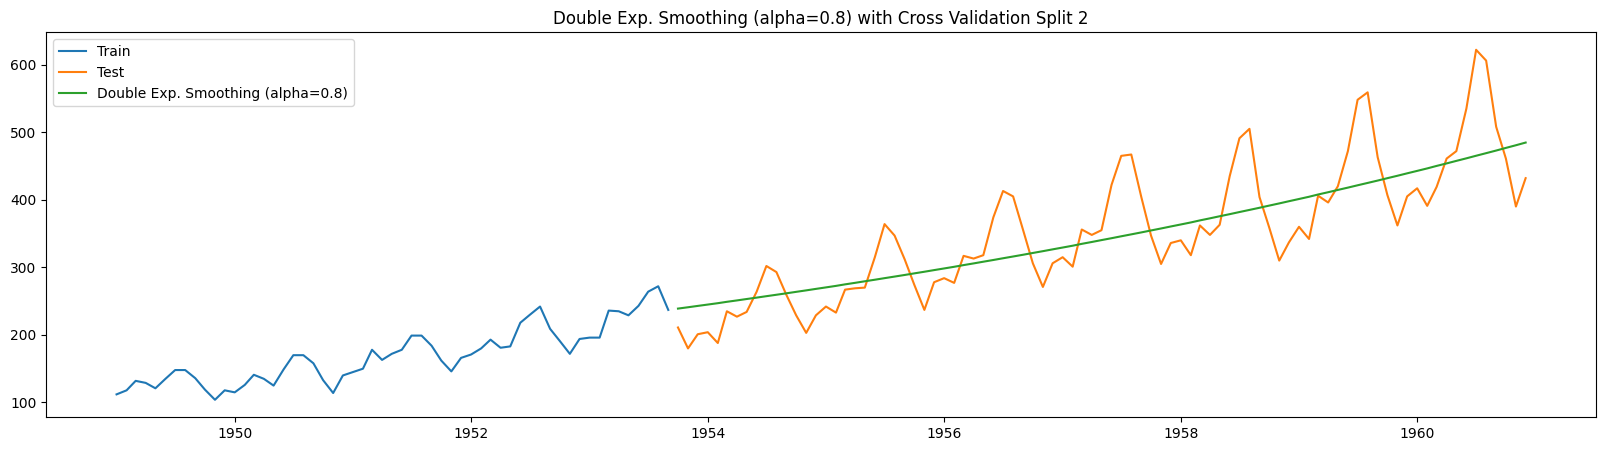

RMSE at split 2 = 56.065630632717244


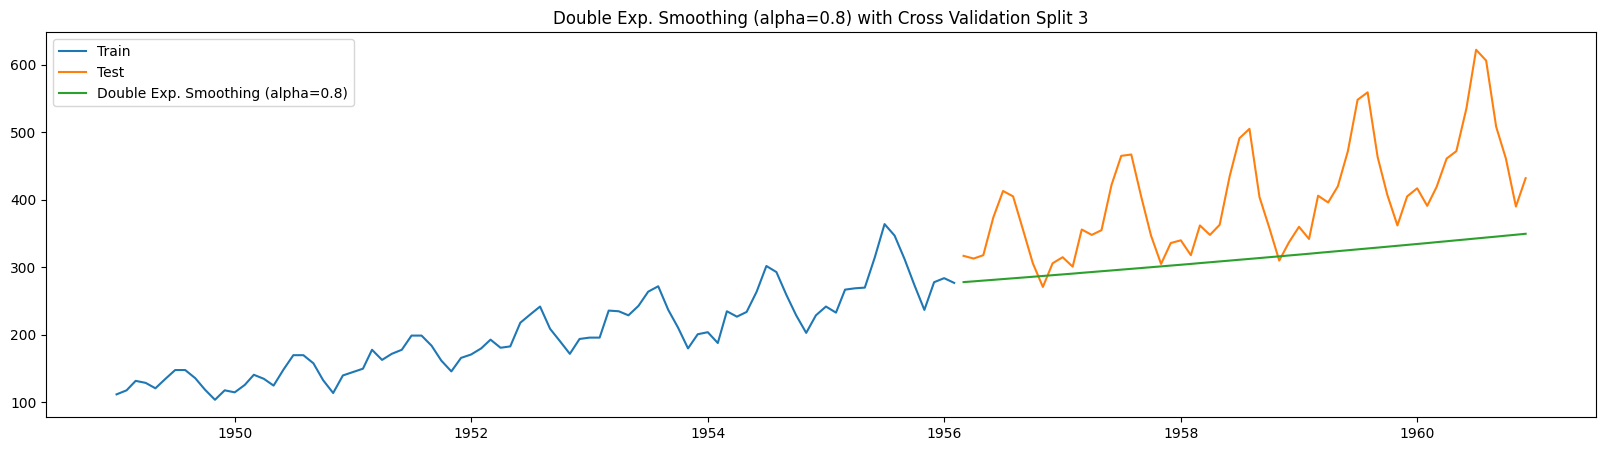

RMSE at split 3 = 110.81843638050344


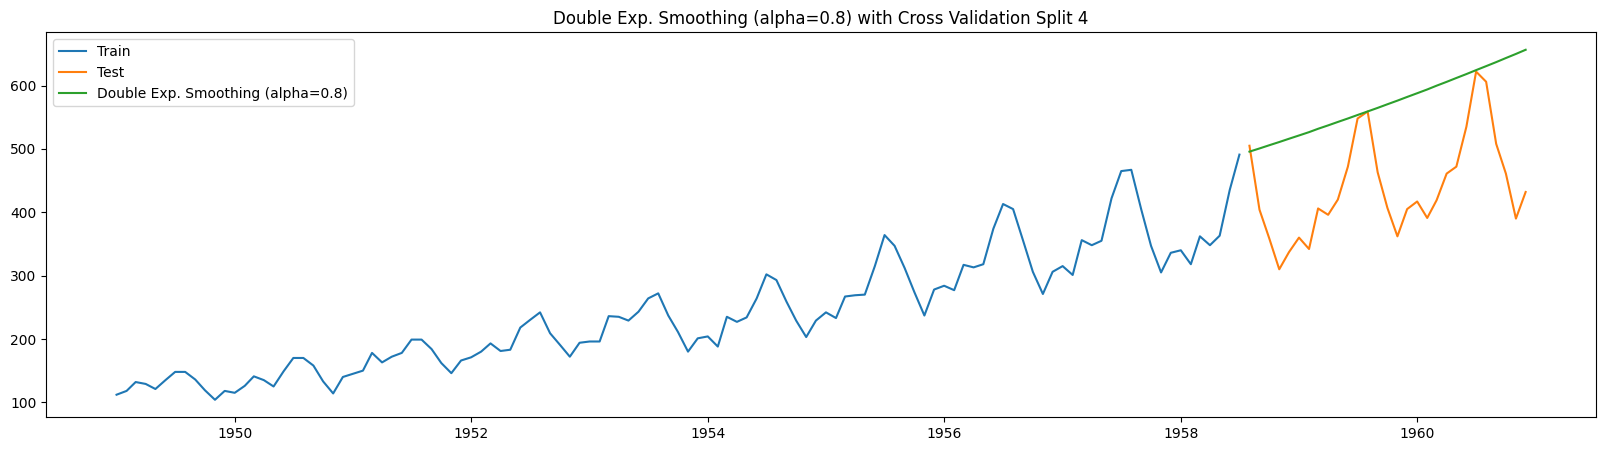

RMSE at split 4 = 150.08853686744254


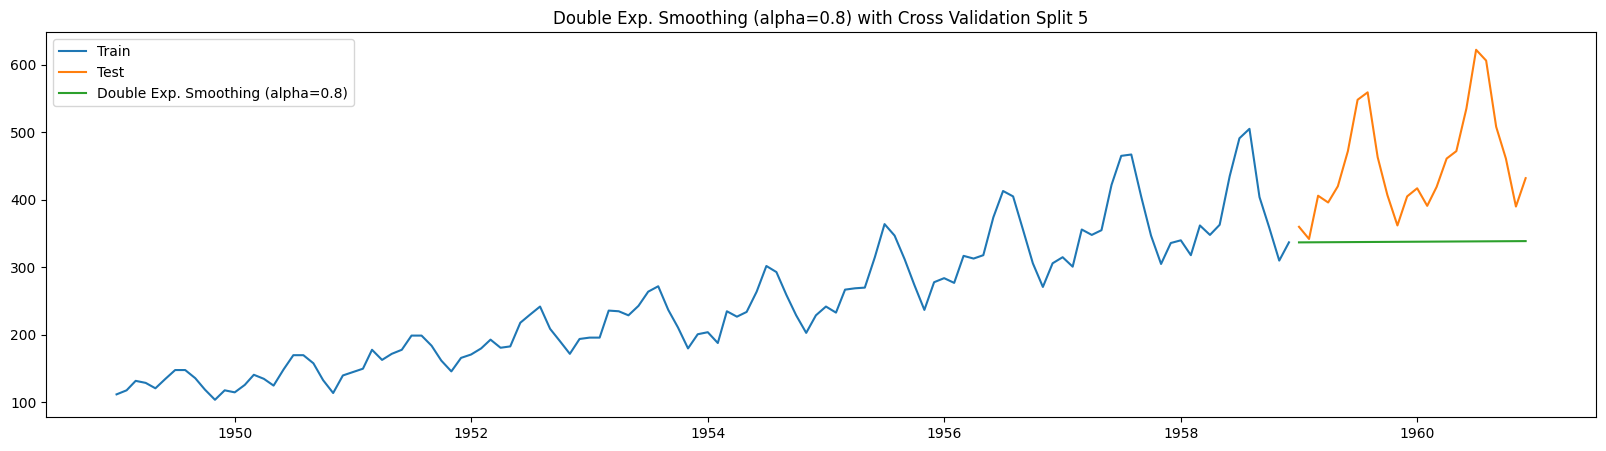

RMSE at split 5 = 136.4600308353549
Mean RMSE = 104.93647828515115


In [ ]:
rmse_list = []
forecasts = []
for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  single_exp_model = ExponentialSmoothing(train_data, trend='mul', seasonal=None).fit(optimized=True)
  forecasts = single_exp_model.forecast(len(test_data))
  rmse_list.append(RMSE(test_data, forecasts))
  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(test_data.index, forecasts, label=f'Double Exp. Smoothing (alpha={alpha})')
  plt.title(f'Double Exp. Smoothing (alpha={alpha}) with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list))

## Report

Using Double Exp. Smoothing has the advantage of capturing the overall trend of the data.

- Fixed Partition: Overall  Damping is a technique used in time series forecasting to reduce the impact of seasonality or trend in the data, By applying damping to the model, the impact of extreme values in each interval can be reduced, resulting in a more accurate forecast and a lower RMSE. In an additive model, the presence of a positive trend may not be effectively addressed by applying damping. This is because when damping is applied, the forecast is lowered, rendering it less useful. Upon comparing the forecasts generated by the additive model before and after damping, it was found that the model performed better without damping.this occurs as we can't select the a good damping parameter. On the other hand, in a multiplicative model, the use of damping can lead to improved forecasts. This means that applying damping in a multiplicative model can be beneficial for forecasting purposes.

- Roll Forward: Damping is not good with Roll Forward Techinque as
The roll-forward technique involves using a fixed window of past data to make forecasts for the future. As new data becomes available, the window is shifted forward, and the model is retrained to make new forecasts. This approach is useful when dealing with time series data that exhibit changing trends or seasonality patterns. However, when damping is applied to the model, it introduces a bias that can persist across different time periods. This bias can be exacerbated when using the roll-forward technique since the model is being retrained on new data and the bias may carry over into the new forecasts.

- Cross Validation: After applying damping, the root mean square error (RMSE) increased in both additive and multiplicative models. This suggests that using damping in either model may not be the best approach for generating accurate forecasts. Therefore, it may be advisable to avoid using damping in these models to minimize the forecasting error.

# 8 - 3 Triple Exponential Smoothing

## Fixed

### Additive

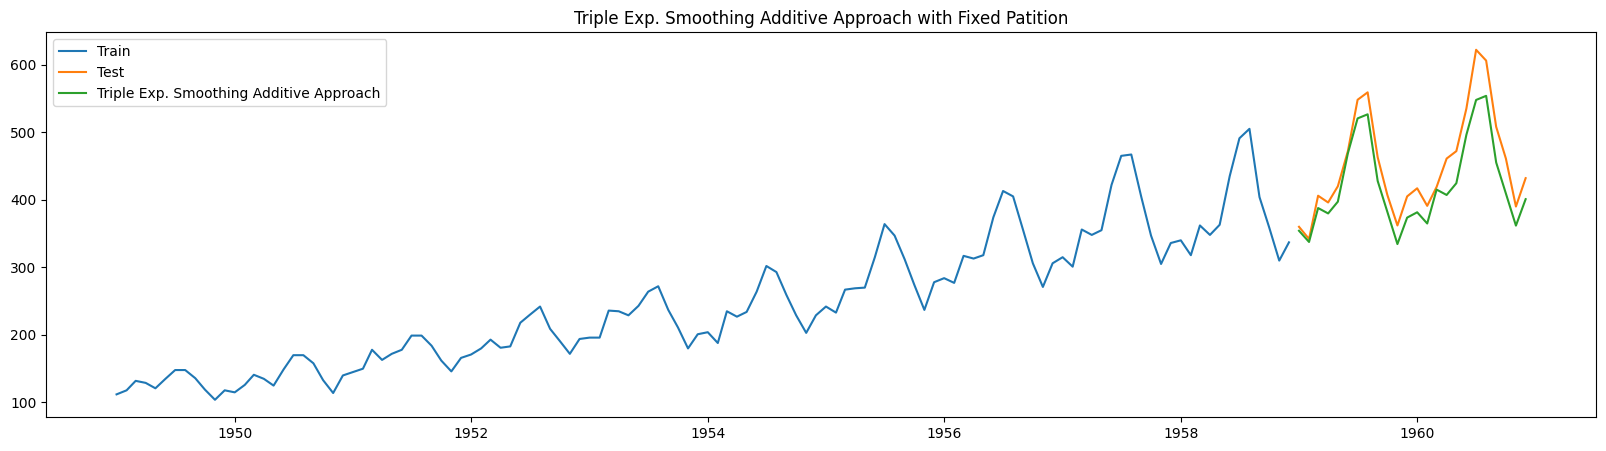

RMSE = 35.757539410127215


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)



triple_exp_model = ExponentialSmoothing(train_data['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

forecasts = triple_exp_model.forecast(len(test_data))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, forecasts, label=f'Triple Exp. Smoothing Additive Approach')
plt.title(f'Triple Exp. Smoothing Additive Approach with Fixed Patition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], forecasts))

### Multiplicative

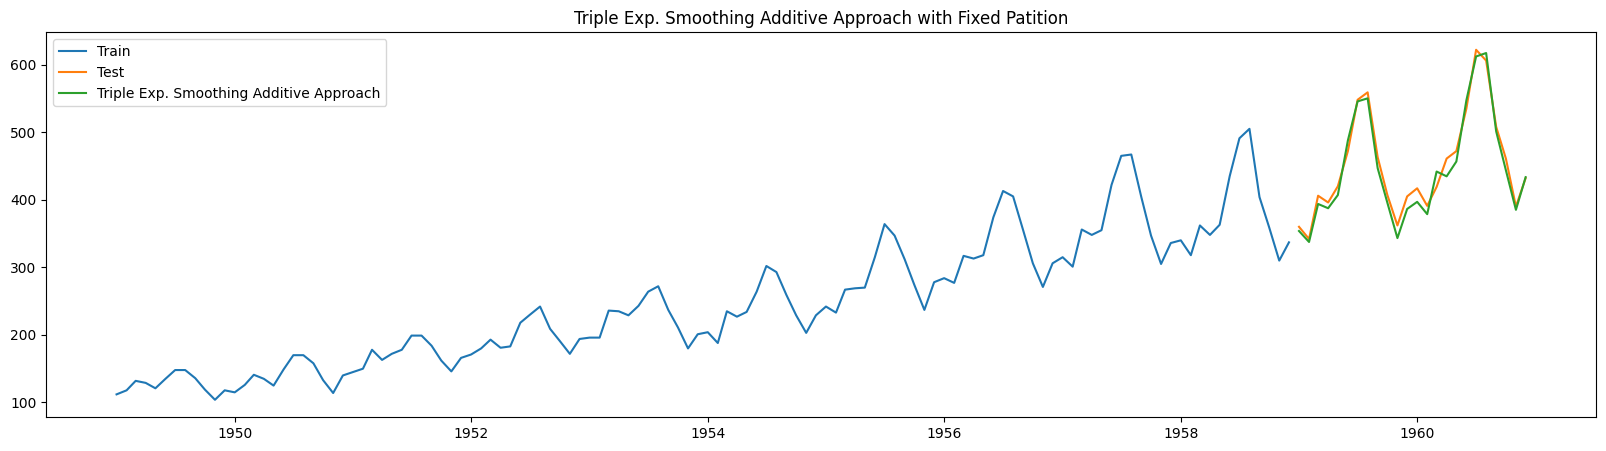

RMSE = 13.878583106104267


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
train_data, test_data = fixed_partition(data, test_size=test_size)



triple_exp_model = ExponentialSmoothing(train_data['Passengers'], trend='mul', seasonal='mul', seasonal_periods=12).fit(optimized=True)

forecasts = triple_exp_model.forecast(len(test_data))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, forecasts, label=f'Triple Exp. Smoothing Additive Approach')
plt.title(f'Triple Exp. Smoothing Additive Approach with Fixed Patition')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['Passengers'], forecasts))

## Roll Forward

### Additive

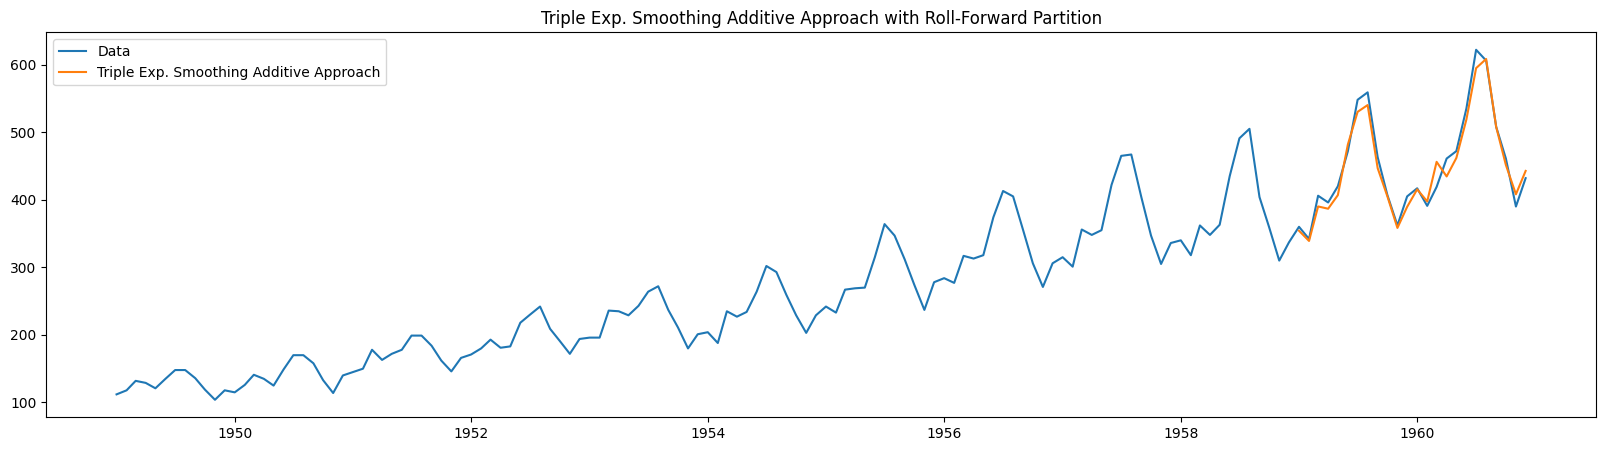

Mean RMSE = 12.378871714794348


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
rmse_list = []
forecasts_index = []
forecasts = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  triple_exp_model = ExponentialSmoothing(train_data['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
  forecasts.append(triple_exp_model.forecast(len(test_data)))
  forecasts_index.append(test_data.index)
  rmse_list.append(RMSE(test_data[-test_size: ], forecasts[-test_size:]))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(forecasts_index, forecasts, label=f'Triple Exp. Smoothing Additive Approach')
plt.title(f'Triple Exp. Smoothing Additive Approach with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("Mean RMSE =", np.mean(rmse_list))

### Multiplicative

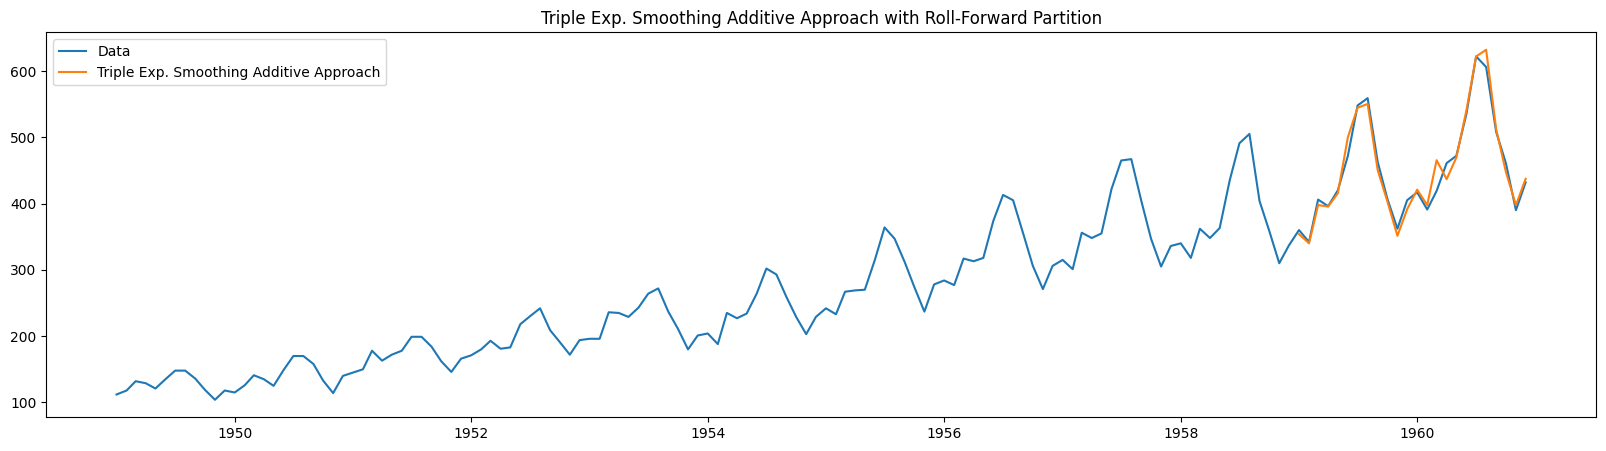

Mean RMSE = 10.30556021144062


In [ ]:
# starting roll forward with 120 months (6 years), then testing on 1 month
rf_window_size = 120
test_size = 1
rmse_list = []
forecasts_index = []
forecasts = []

for train_data, test_data in roll_forward(data, rf_window_size, test_size):
  triple_exp_model = ExponentialSmoothing(train_data['Passengers'], trend='mul', seasonal='mul', seasonal_periods=12).fit(optimized=True)
  forecasts.append(triple_exp_model.forecast(len(test_data)))
  forecasts_index.append(test_data.index)
  rmse_list.append(RMSE(test_data[-test_size: ], forecasts[-test_size:]))

# Plotting Results and Error
plt.figure(figsize=(20,5))
plt.plot(data, label='Data')
plt.plot(forecasts_index, forecasts, label=f'Triple Exp. Smoothing Additive Approach')
plt.title(f'Triple Exp. Smoothing Additive Approach with Roll-Forward Partition')
plt.legend(loc='best')
plt.show()

print("Mean RMSE =", np.mean(rmse_list))

## Cross Validation

### Additive

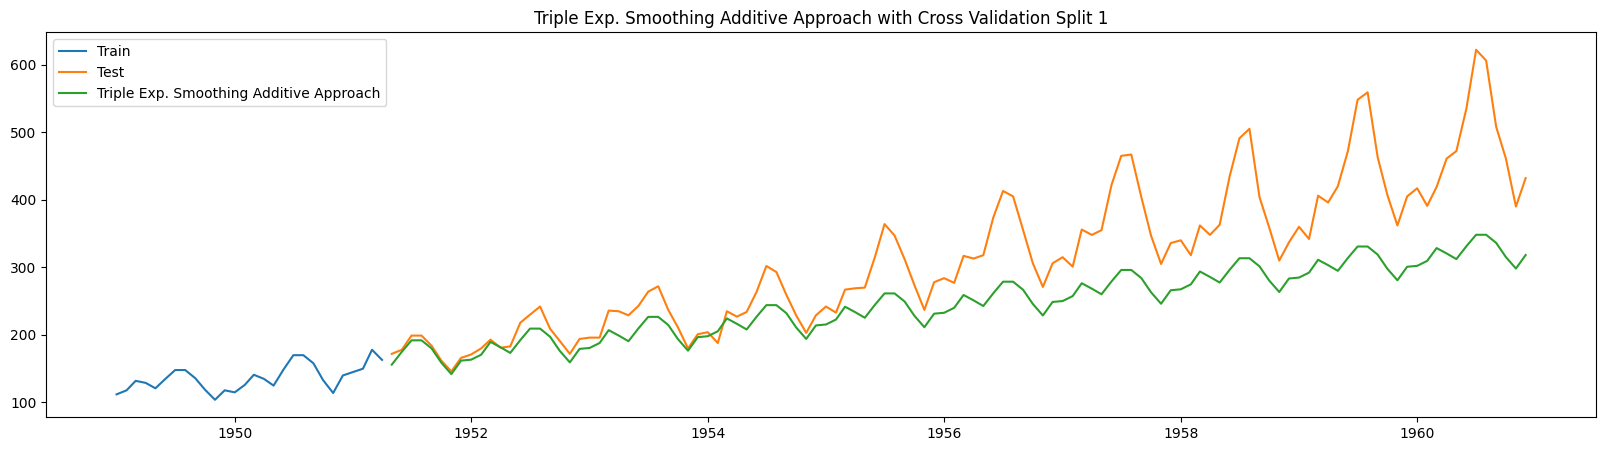

RMSE at split 1 = 90.5169033271441


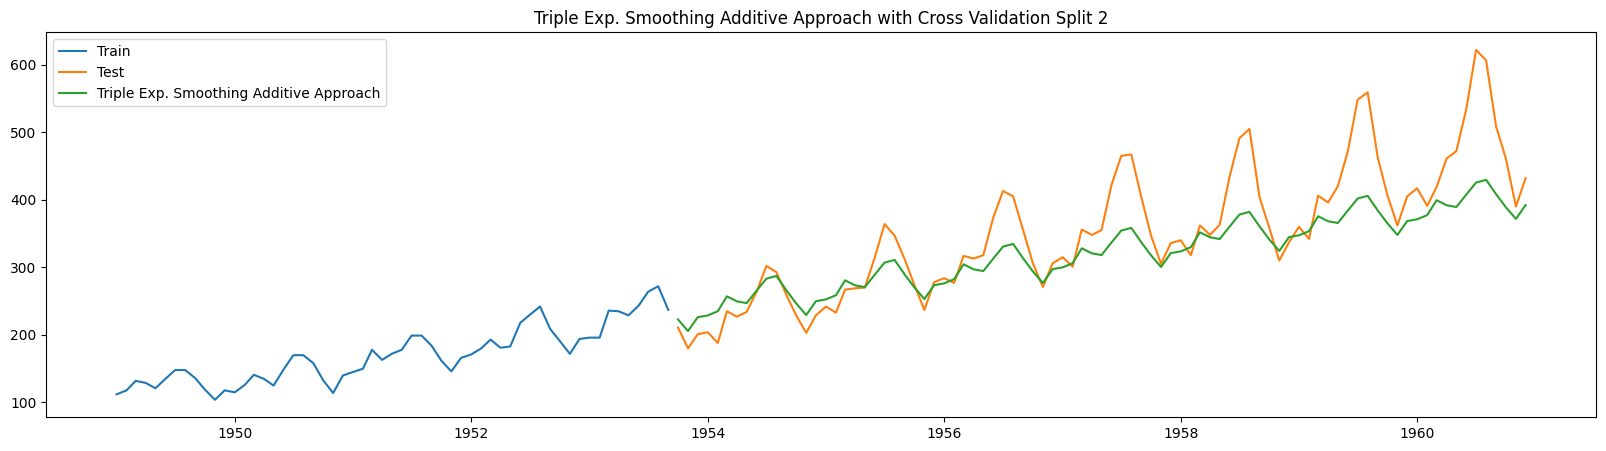

RMSE at split 2 = 58.11749186955068


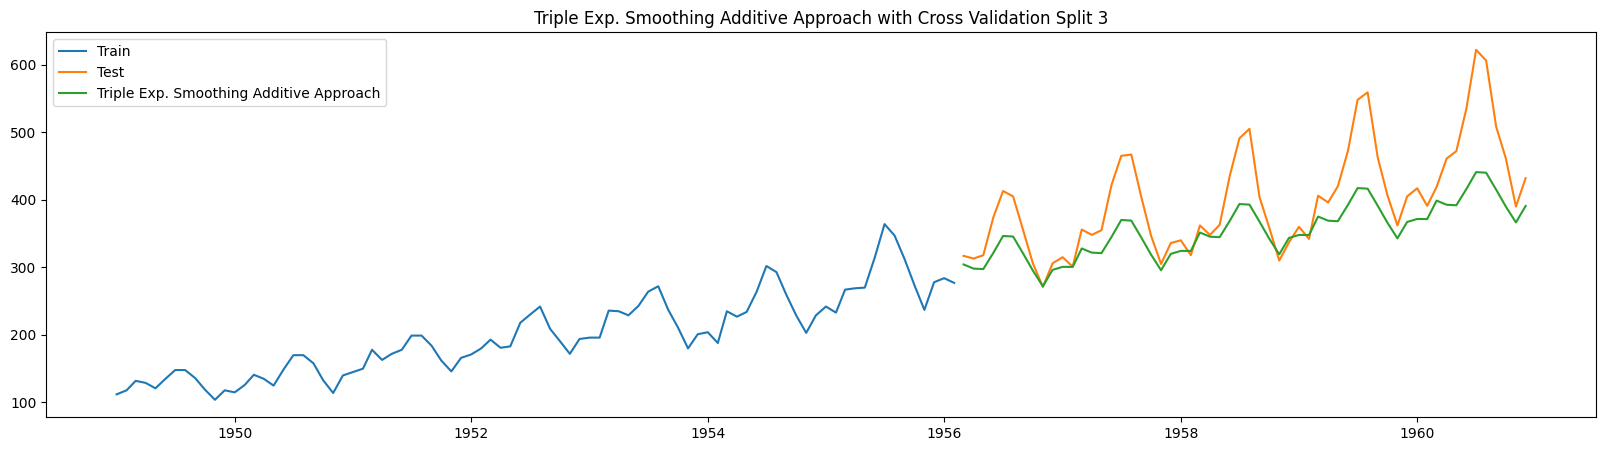

RMSE at split 3 = 63.67843999845406


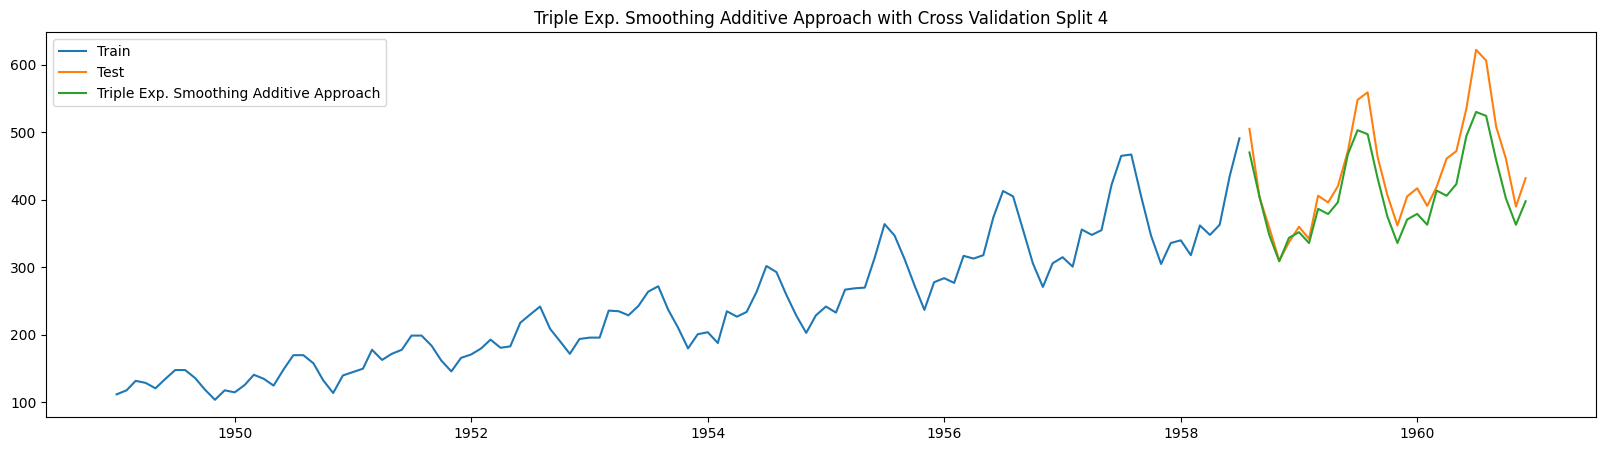

RMSE at split 4 = 39.26061311965583


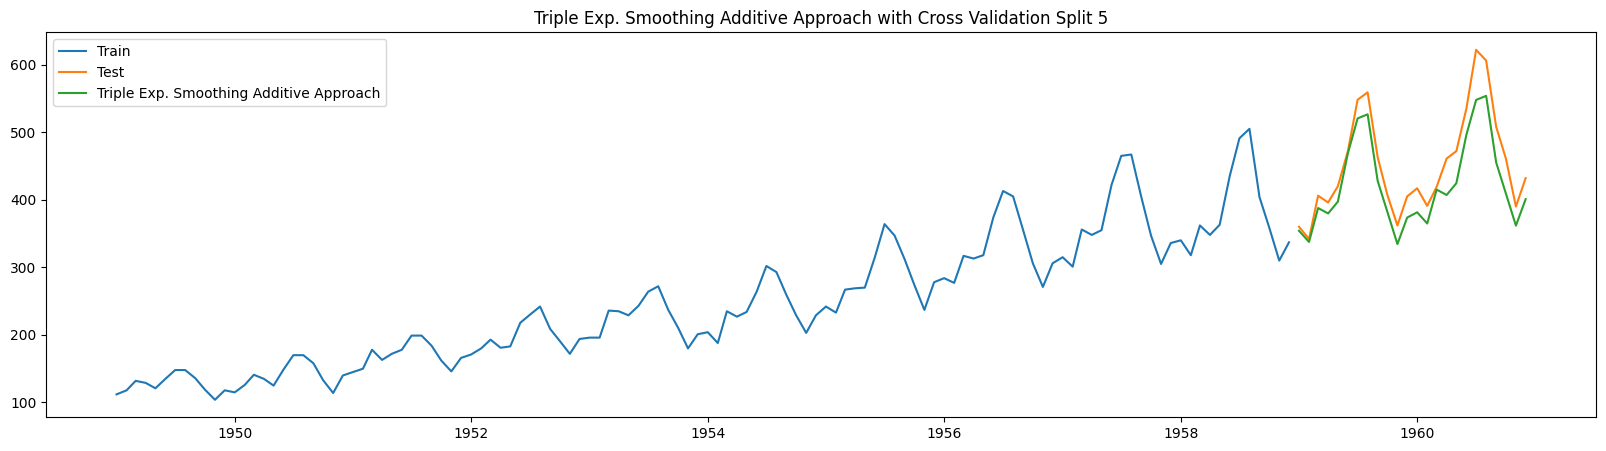

RMSE at split 5 = 35.757539410127215
Mean RMSE = 57.46619754498638


In [ ]:
rmse_list = []
forecasts = []
for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  triple_exp_model = ExponentialSmoothing(train_data['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

  forecasts = triple_exp_model.forecast(len(test_data))
  rmse_list.append(RMSE(test_data, forecasts))
  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(test_data.index, forecasts, label=f'Triple Exp. Smoothing Additive Approach')
  plt.title(f'Triple Exp. Smoothing Additive Approach with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list))

### Multiplicative

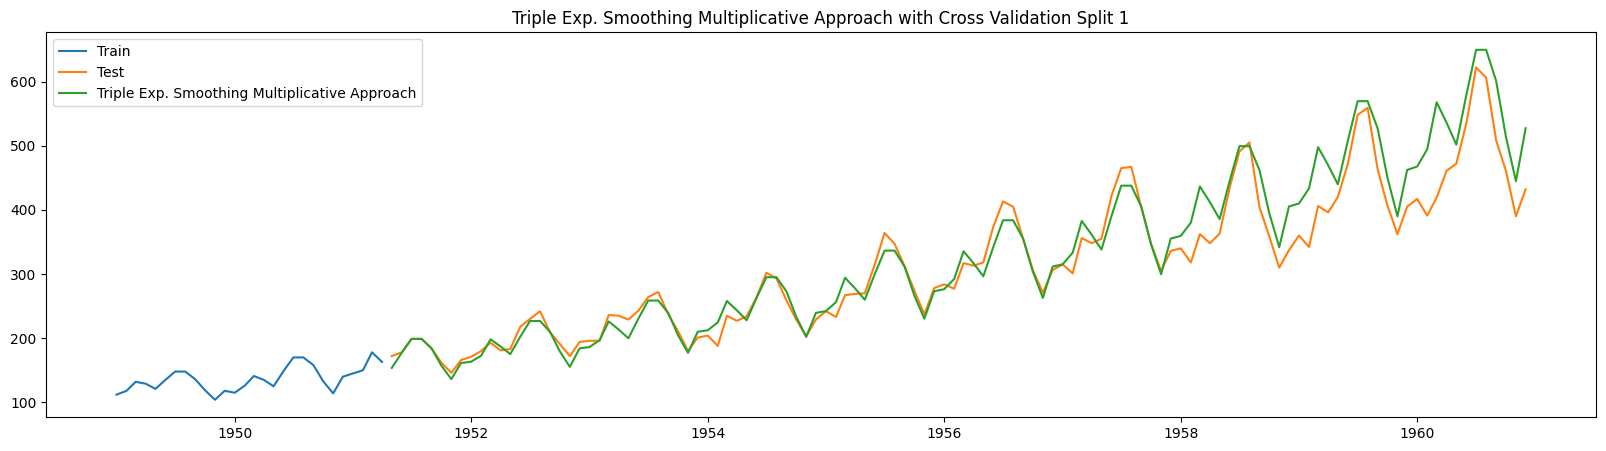

RMSE at split 1 = 35.888722841681854


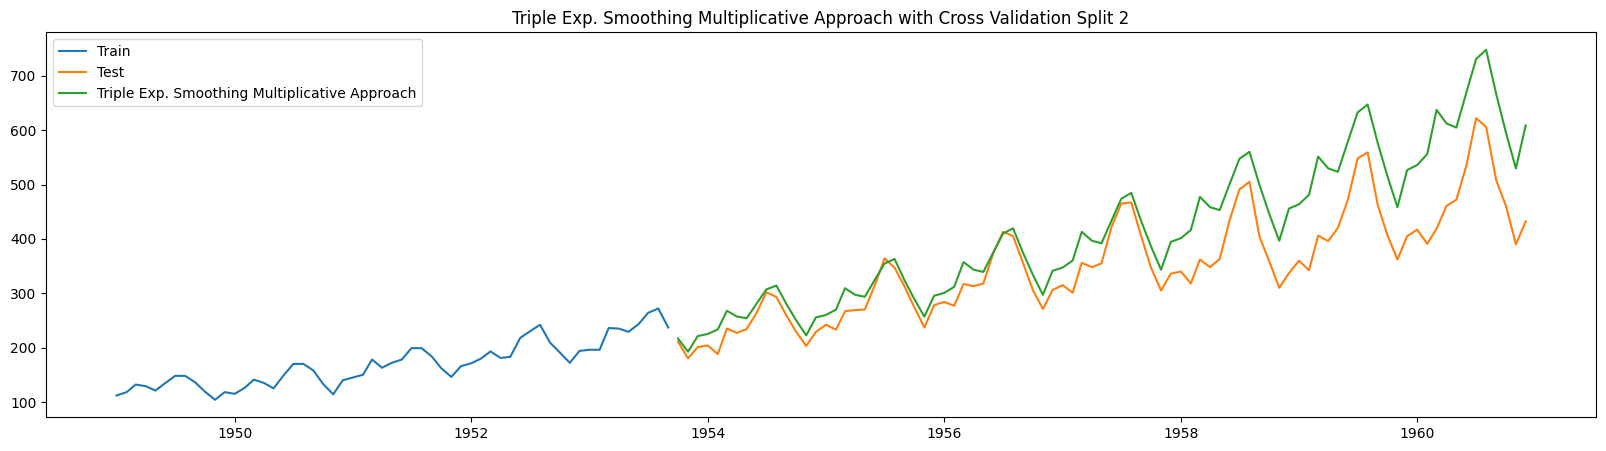

RMSE at split 2 = 80.6813743988231


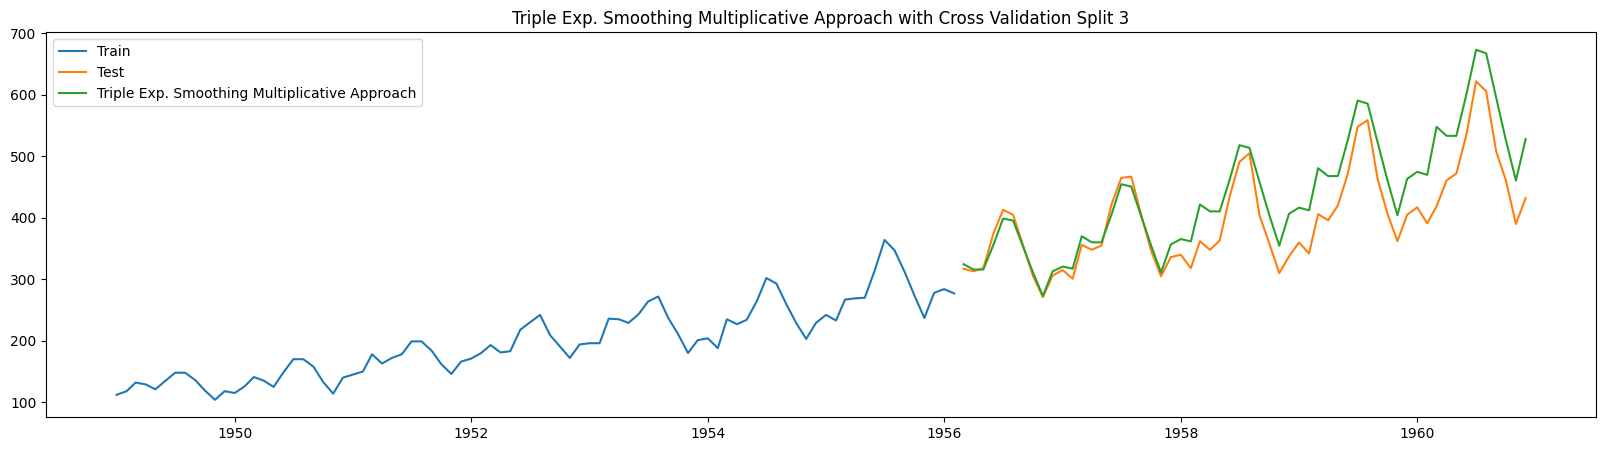

RMSE at split 3 = 48.94207082746512


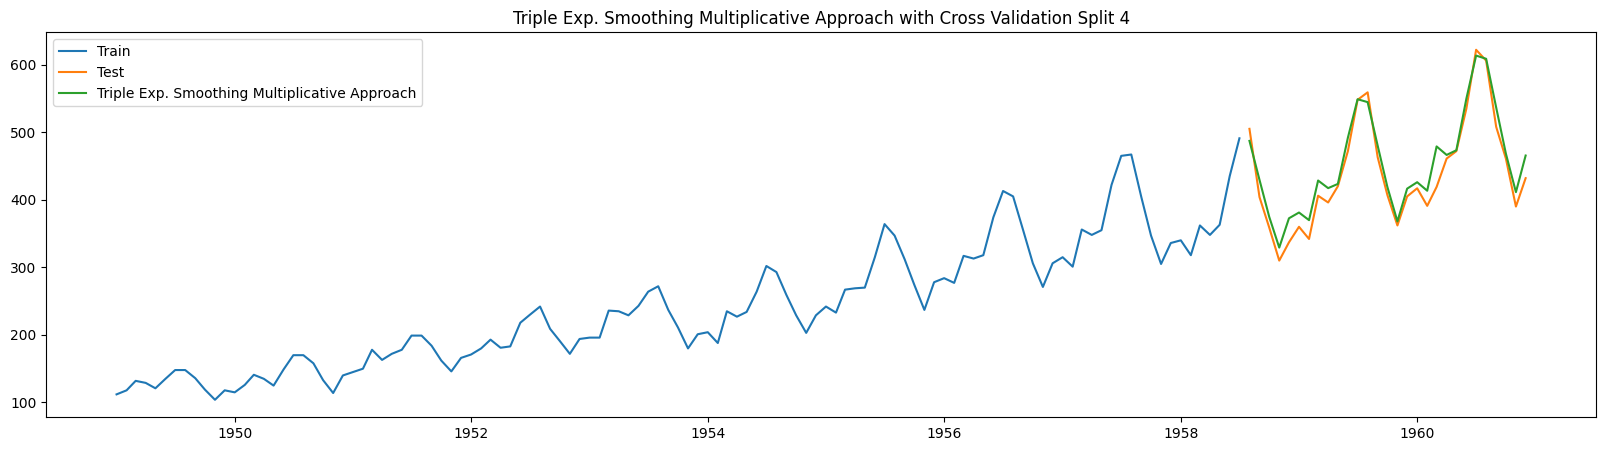

RMSE at split 4 = 21.33839602611632


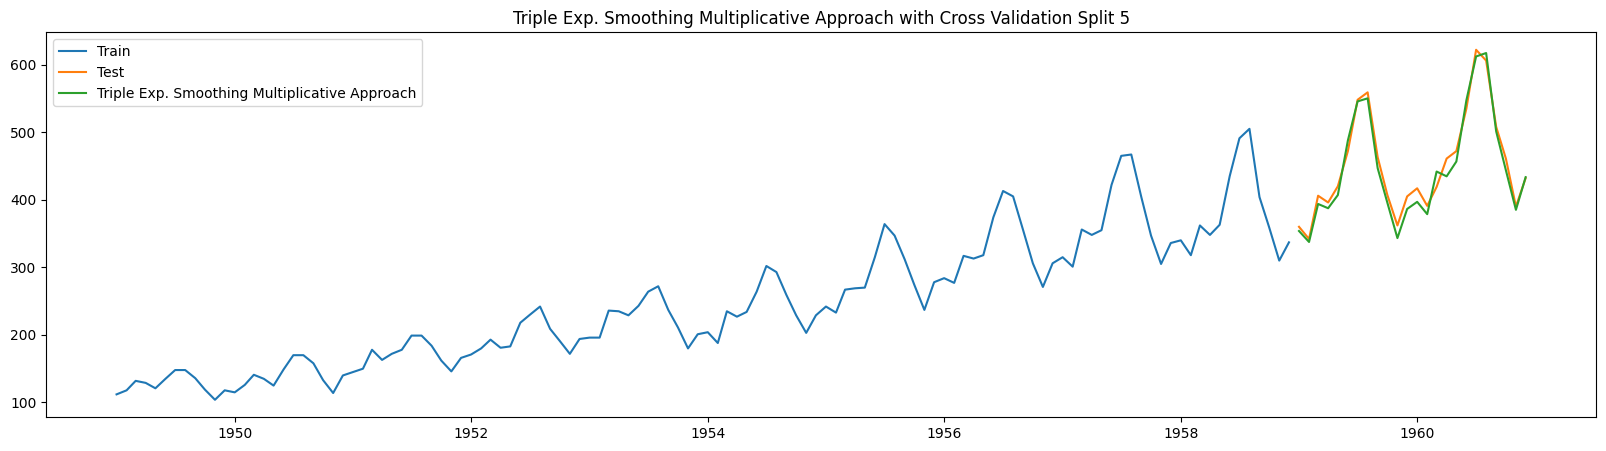

RMSE at split 5 = 13.878583106104267
Mean RMSE = 40.14582944003813


In [ ]:
rmse_list = []
forecasts = []
for i, (train_data, test_data) in enumerate(cross_validation(data, n_splits = 5)):
  triple_exp_model = ExponentialSmoothing(train_data['Passengers'], trend='mul', seasonal='mul', seasonal_periods=12).fit(optimized=True)

  forecasts = triple_exp_model.forecast(len(test_data))
  rmse_list.append(RMSE(test_data, forecasts))
  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['Passengers'], label='Train')
  plt.plot(test_data.index, test_data['Passengers'], label='Test')
  plt.plot(test_data.index, forecasts, label=f'Triple Exp. Smoothing Multiplicative Approach')
  plt.title(f'Triple Exp. Smoothing Multiplicative Approach with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list))

## Report

Using Triple Exp. is theortically a good choice, since this technique allows us to capture trend and seasonality, and this theory is confirmed form looking at the RMSE.

- Fixed Partition: Using multiplicative Double Exp. Smoothing yields better results than using additive method, this is because the data is multiplicative.

- Roll Forward: Using the model for short forecasting, seems to produce good results in both additive and multiplicative, although multiplicative produces better results.

- Cross Validation: In additive approach it seems to not be able to produce good results on short training data, as the data increased the forecasting was better. Multiplicative on the otherhand seems to produce better forecasting even in short training data, this could be due that it has information on both the trend and the seasonality of the data.

# 9 - Facebook Prophet Algorithm

## Fixed

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/q748lzoo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/0mm3t2gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18668', 'data', 'file=/tmp/tmpr3phbbku/q748lzoo.json', 'init=/tmp/tmpr3phbbku/0mm3t2gd.json', 'output', 'file=/tmp/tmpr3phbbku/prophet_modelps7yt8it/prophet_model-20230406160216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


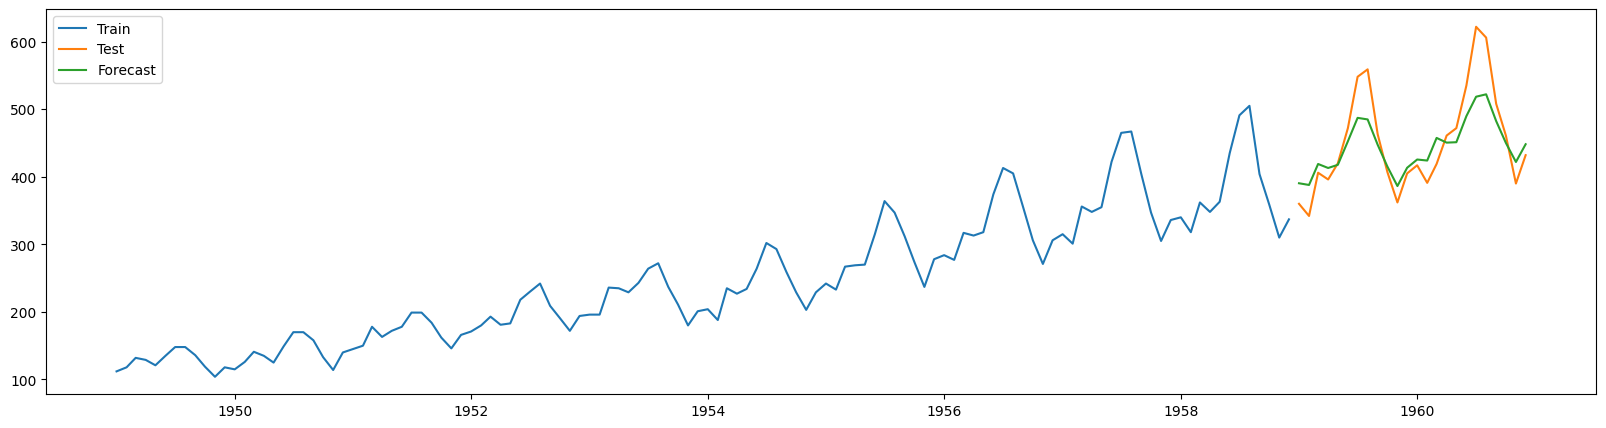

RMSE = 40.35218846265365


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
data_FB = pd.DataFrame({
    'ds': data.index,
    'y': data['Passengers']
})
train_data, test_data = fixed_partition(data_FB, test_size=test_size)

model = Prophet()
model.fit(train_data)
future_dates = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(future_dates[-24:])

# plot
plt.figure(figsize=(20,5))
plt.plot(train_data['ds'],train_data['y'], label='Train')
plt.plot(test_data['ds'],test_data['y'], label='Test')
plt.plot(forecast['ds'].tolist(),forecast['yhat'].tolist(), label = 'Forecast')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(test_data['y'], forecast['yhat']))

## Roll Forward

In [ ]:
%%capture
rf_window_size = 120
test_size = 1
trend = []
test_index = []
test_val = []
forecast_data = []
rmse_list = []
for train,test in roll_forward(data_FB, rf_window_size, test_size):
    model = Prophet()
    model.fit(train)
    future_dates = model.make_future_dataframe(periods=1, freq='MS')
    forecast = model.predict(future_dates)
    forecast_data.append(forecast['yhat'].iloc[-1])
    test_val.append(test['y'])
    test_index.append(test['ds'])
    rmse_list.append(RMSE(test_val[-test_size: ], forecast_data[-test_size: ]))

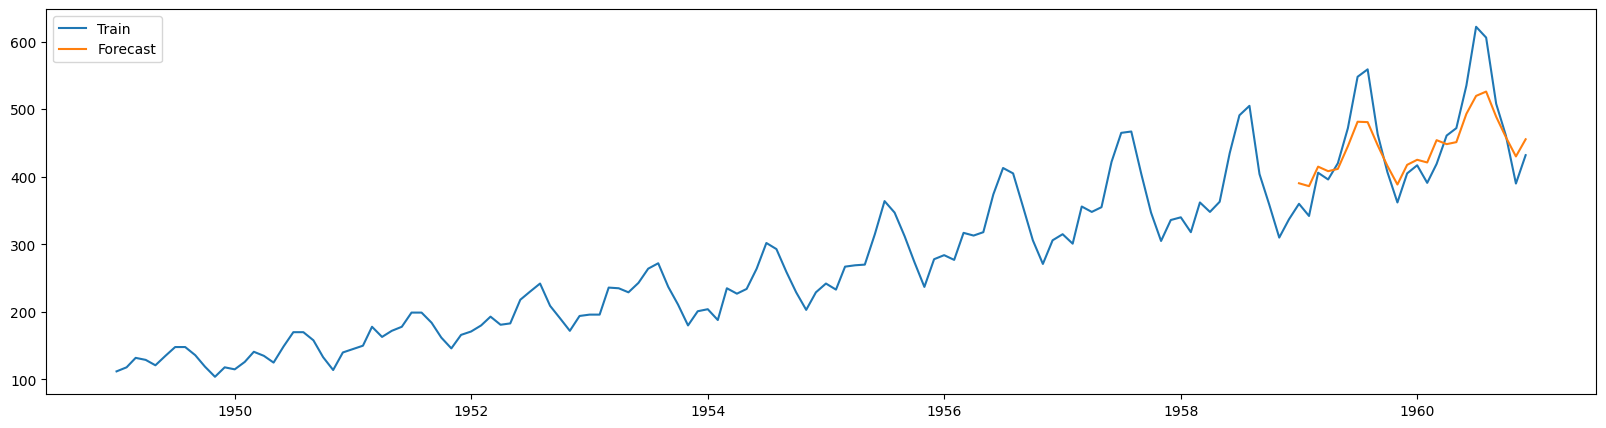

Mean RMSE = 31.523024376684788


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data_FB['ds'],data_FB['y'], label='Train')
# plt.plot(test_index,test_val, label='Test')
plt.plot(test_index,forecast_data, label = 'Forecast')
plt.legend(loc='best')
plt.show()
print("Mean RMSE =", np.mean(rmse_list))

## Cross Validation

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/06m4w9fb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/1y7yzmm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26959', 'data', 'file=/tmp/tmpr3phbbku/06m4w9fb.json', 'init=/tmp/tmpr3phbbku/1y7yzmm0.json', 'output', 'file=/tmp/tmpr3phbbku/prophet_modelydhs2ef5/prophet_model-20230406161516.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

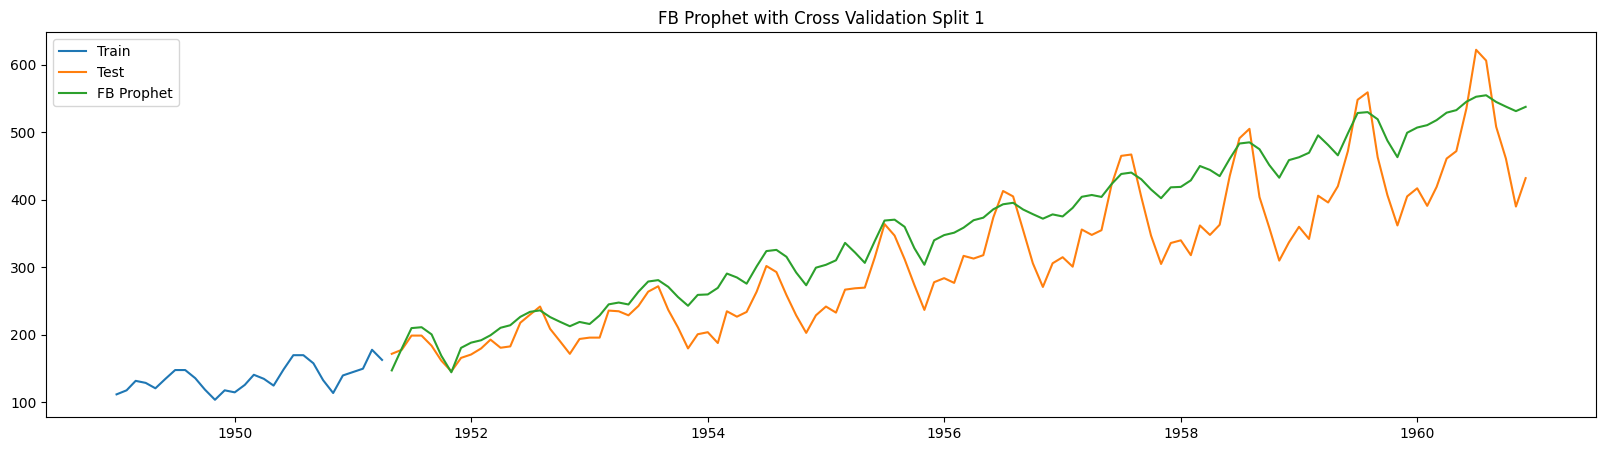

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/yukgpaw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/s72qmxjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76556', 'data', 'file=/tmp/tmpr3phbbku/yukgpaw1.json', 'init=/tmp/tmpr3phbbku/s72qmxjx.json', 'output', 'file=/tmp/tmpr3phbbku/prophet_modelgaonm9by/prophet_model-20230406161517.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:15:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RMSE at split 1 = 60.25546402924457


16:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


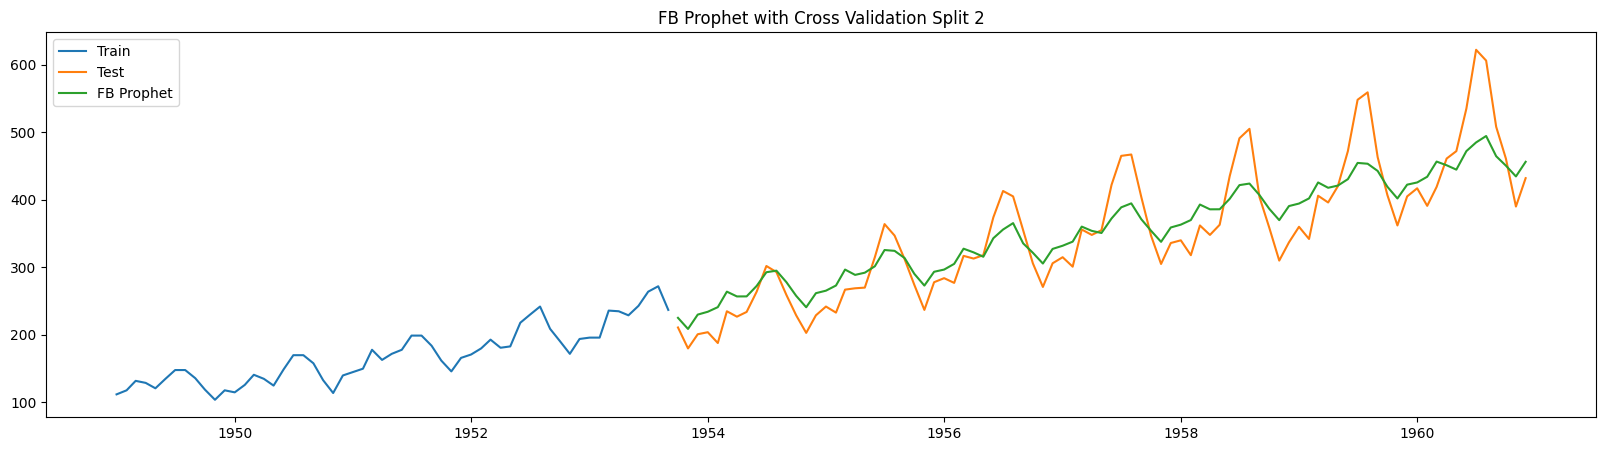

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/umru4m1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/6hljf7g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26567', 'data', 'file=/tmp/tmpr3phbbku/umru4m1s.json', 'init=/tmp/tmpr3phbbku/6hljf7g6.json', 'output', 'file=/tmp/tmpr3phbbku/prophet_modelnovc3wdo/prophet_model-20230406161519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RMSE at split 2 = 41.02306685514128


16:15:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


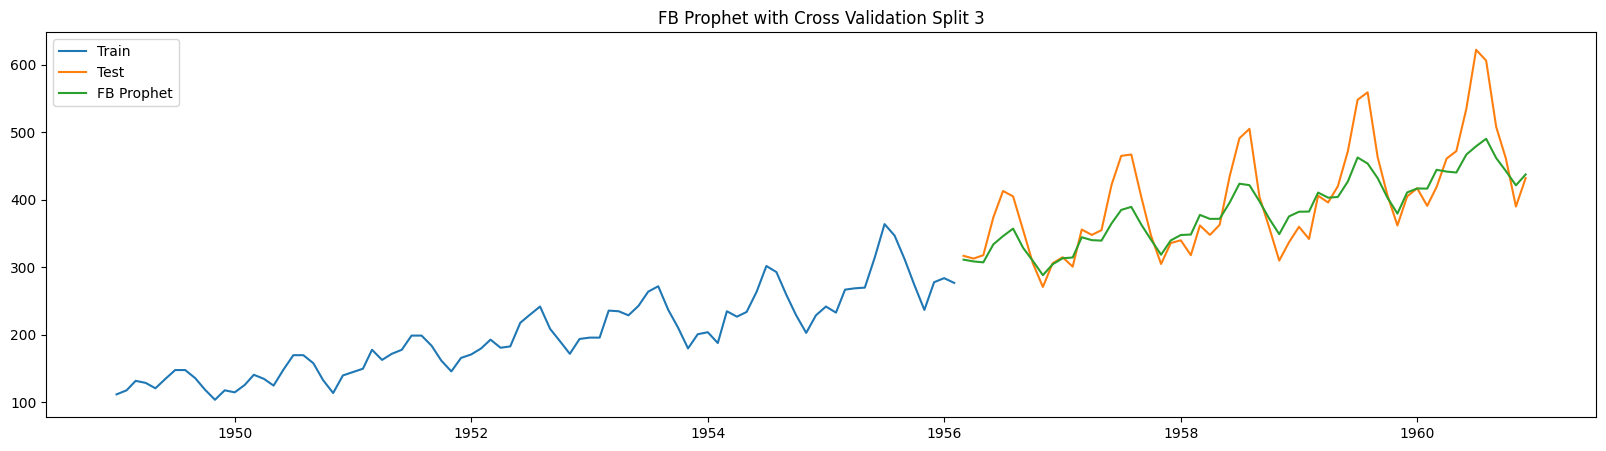

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/56qvh_bk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/tv1y62ro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20678', 'data', 'file=/tmp/tmpr3phbbku/56qvh_bk.json', 'init=/tmp/tmpr3phbbku/tv1y62ro.json', 'output', 'file=/tmp/tmpr3phbbku/prophet_modelmtbmrcow/prophet_model-20230406161521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RMSE at split 3 = 44.43475958234572


16:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


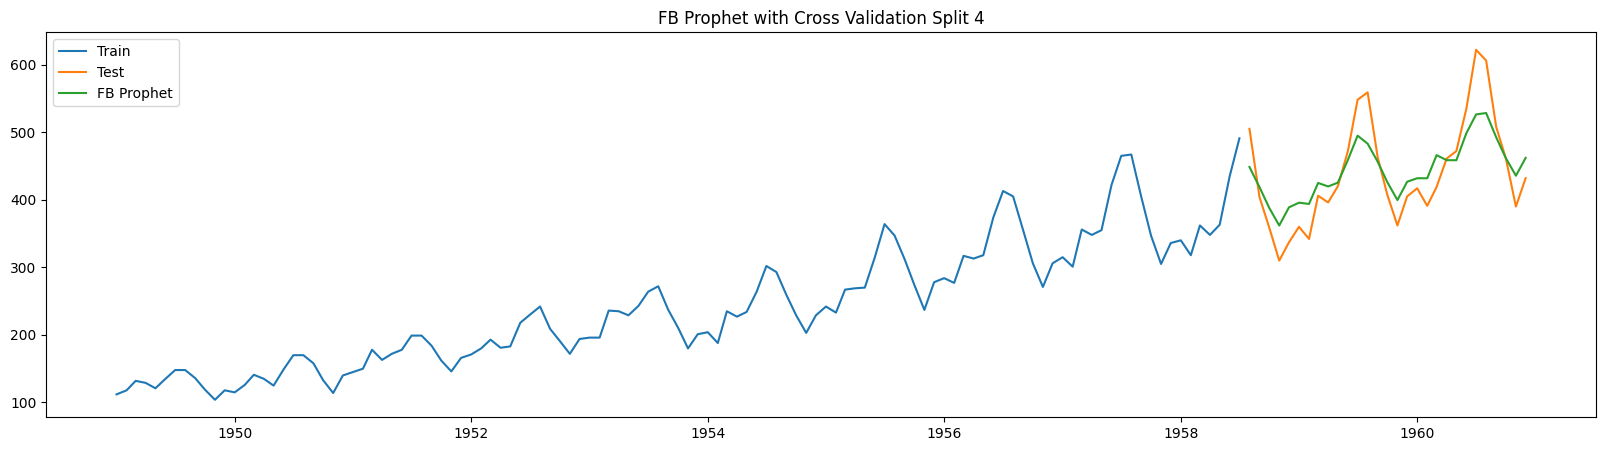

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/n9c5_uab.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr3phbbku/2kri147_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86041', 'data', 'file=/tmp/tmpr3phbbku/n9c5_uab.json', 'init=/tmp/tmpr3phbbku/2kri147_.json', 'output', 'file=/tmp/tmpr3phbbku/prophet_modela7x5xtqg/prophet_model-20230406161522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:15:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


RMSE at split 4 = 41.353747030051366


16:15:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


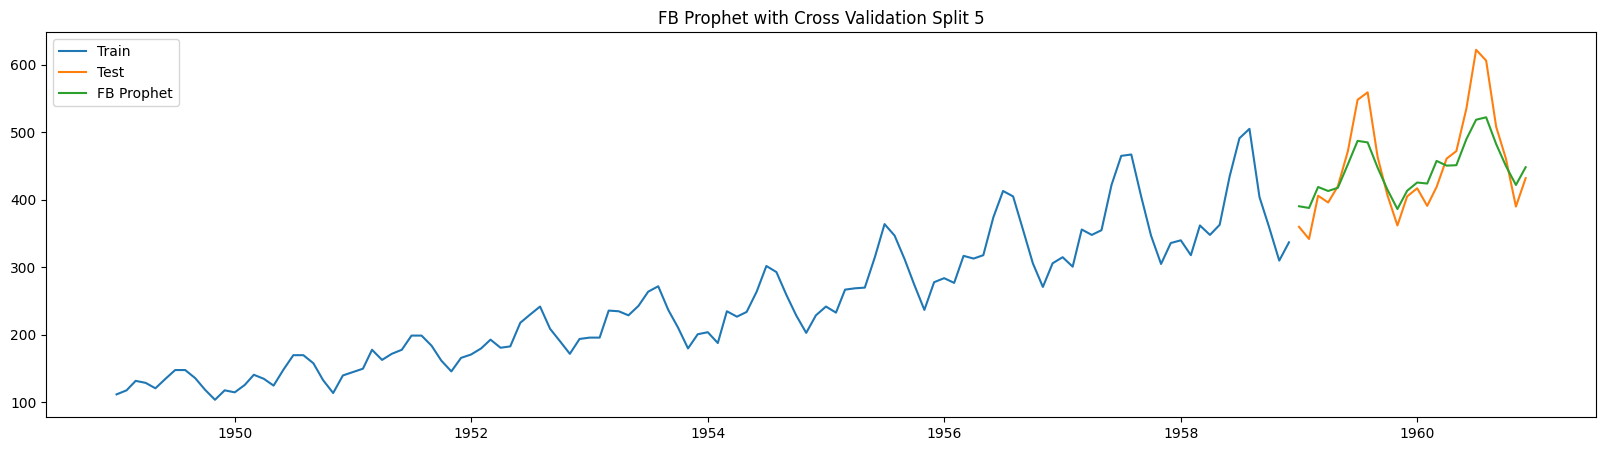

RMSE at split 5 = 40.35218846265365
Mean RMSE = 45.48384519188731


In [ ]:
rmse_list = []
for i, (train_data, test_data) in enumerate(cross_validation(data_FB, n_splits = 5)):

  
  model = Prophet()
  model.fit(train_data)
  future_dates = model.make_future_dataframe(periods = len(test_data), freq = 'MS')
  forecast = model.predict(future_dates[-len(test_data):])

  rmse_list.append(RMSE(test_data['y'], forecast['yhat']))

  
  # Plotting Results and Error
  plt.figure(figsize=(20,5))
  plt.plot(train_data.index, train_data['y'], label='Train')
  plt.plot(test_data.index, test_data['y'], label='Test')
  plt.plot(forecast['ds'], forecast['yhat'], label='FB Prophet')
  plt.title(f'FB Prophet with Cross Validation Split {i+1}')
  plt.legend(loc='best')
  plt.show()

  print(f"RMSE at split {i+1} =", rmse_list[-1])
  

print('Mean RMSE =', np.mean(rmse_list)) 

## Report

The advantage of using FB prophet would be its simplicity, he perofrmance of the algorithm is not the best on the dataset, but it yields relatively good results. From its metrics we could say that the algorithm can be used for long and short term forecasting. The model theroitcally can be improved further using some hyperparameter tuning

# 10 - XGBoost Regressor

## Fixed

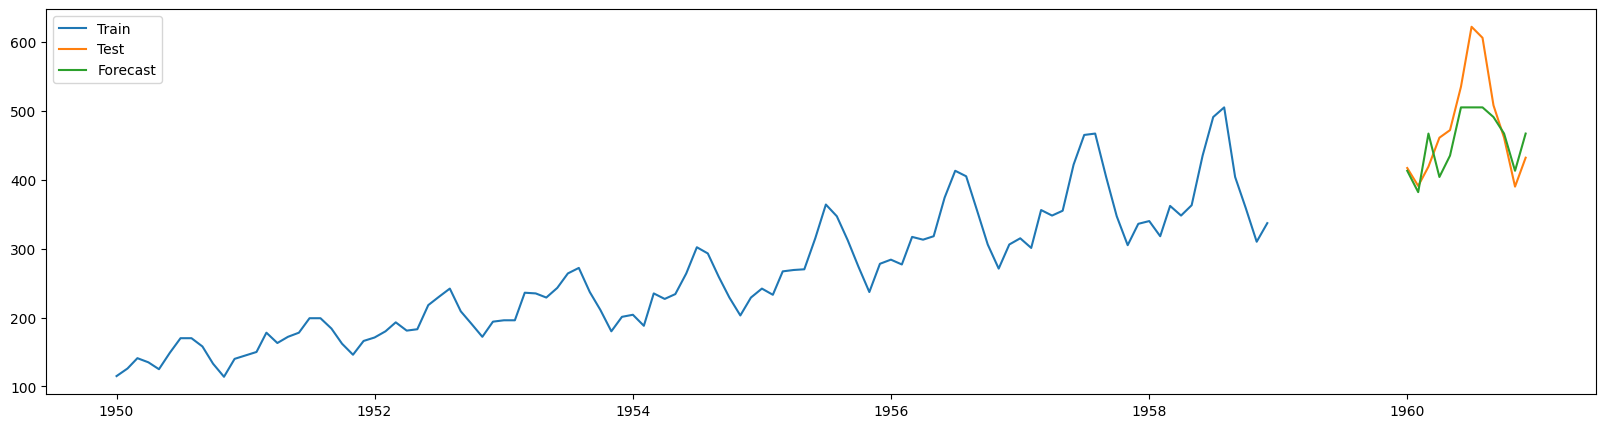

RMSE = 53.14132128278107


In [ ]:
# splitting data so that we have 24 months for testing and the rest for training
test_size = 24
lag = 12
train, test = fixed_partition(data, test_size=test_size)

train['passengers_lag'] = train['Passengers'].shift(lag)
test['passengers_lag'] = test['Passengers'].shift(lag)
train = train.dropna()
test = test.dropna()
X_train = train[['passengers_lag']]
y_train = train['Passengers']
X_test = test[['passengers_lag']]
y_test = test['Passengers']
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


plt.figure(figsize=(20,5))
plt.plot(train.index,y_train, label='Train')
plt.plot(test.index,y_test, label='Test')
plt.plot(test.index,y_pred, label = 'Forecast')
plt.legend(loc='best')
plt.show()

print("RMSE =", RMSE(y_test, y_pred))

## Cross Validation

 ROOT Mean squared error: 190.28745397085285


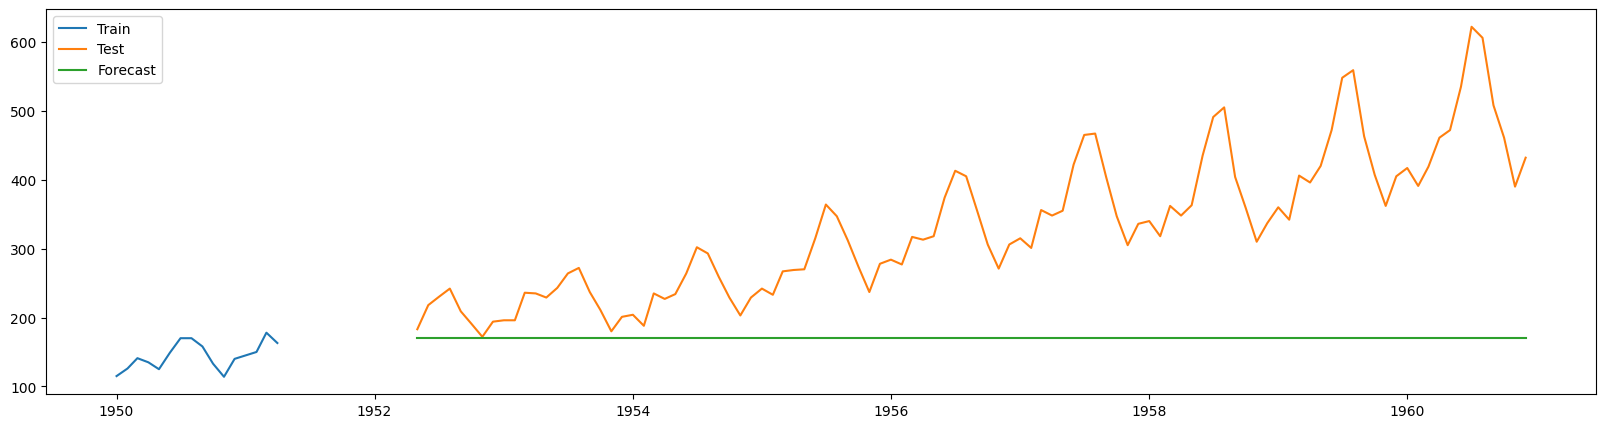

 ROOT Mean squared error: 133.2877751353123


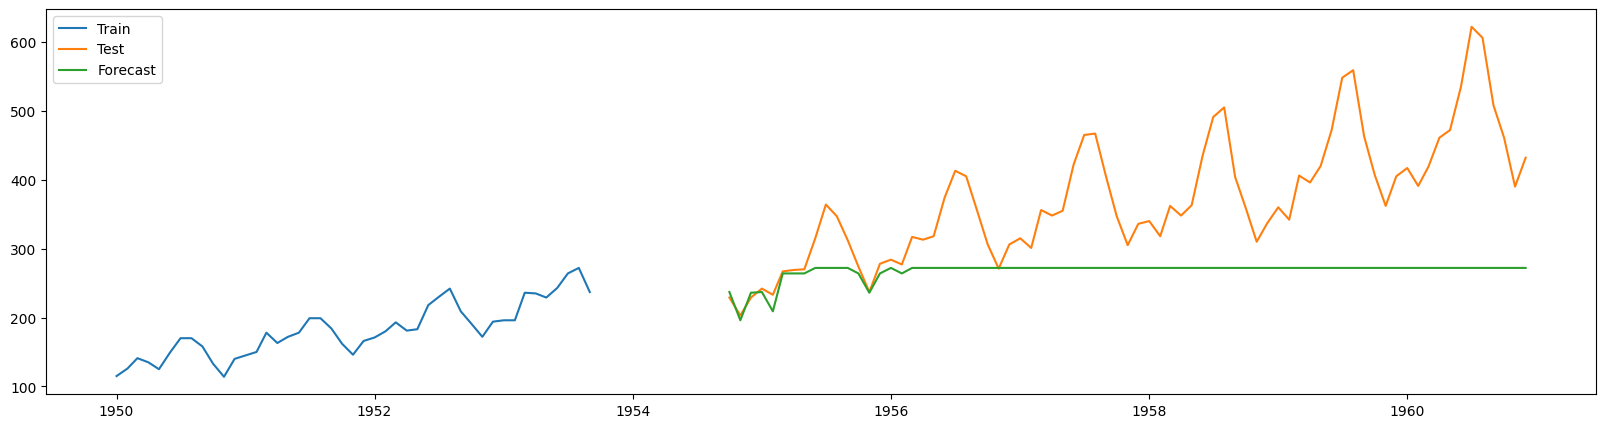

 ROOT Mean squared error: 92.97292495151194


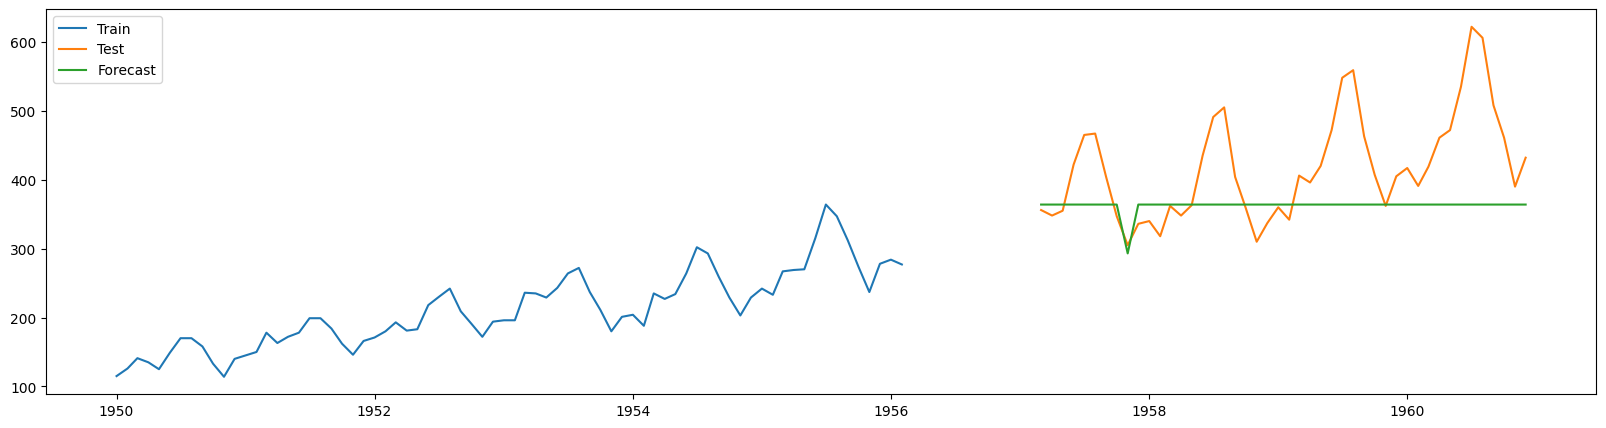

 ROOT Mean squared error: 51.503458065424056


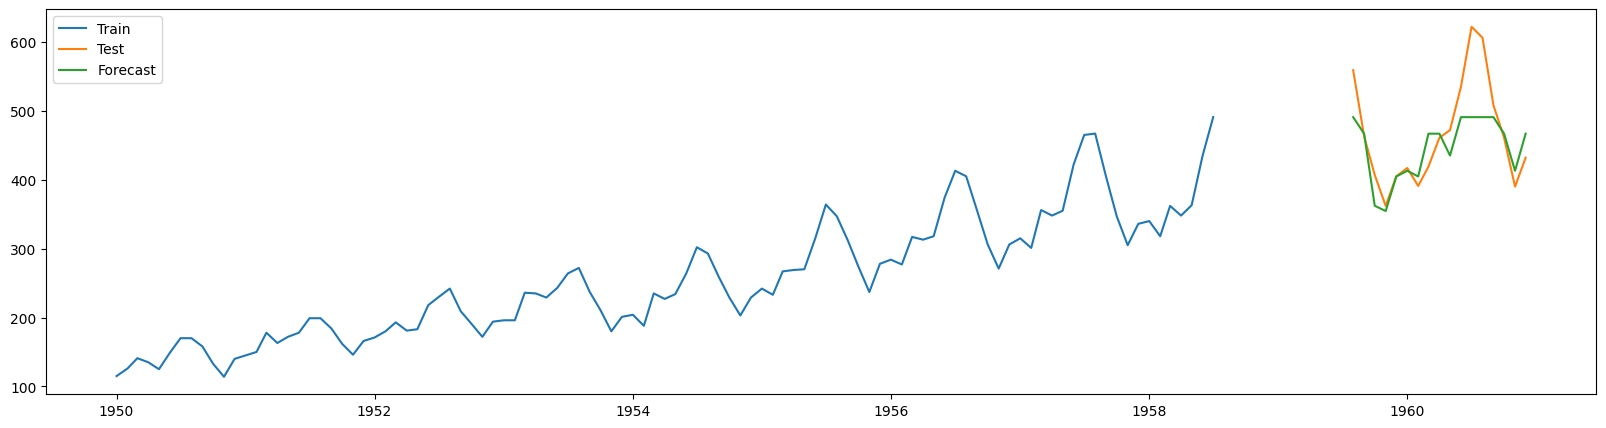

 ROOT Mean squared error: 53.17239545707222


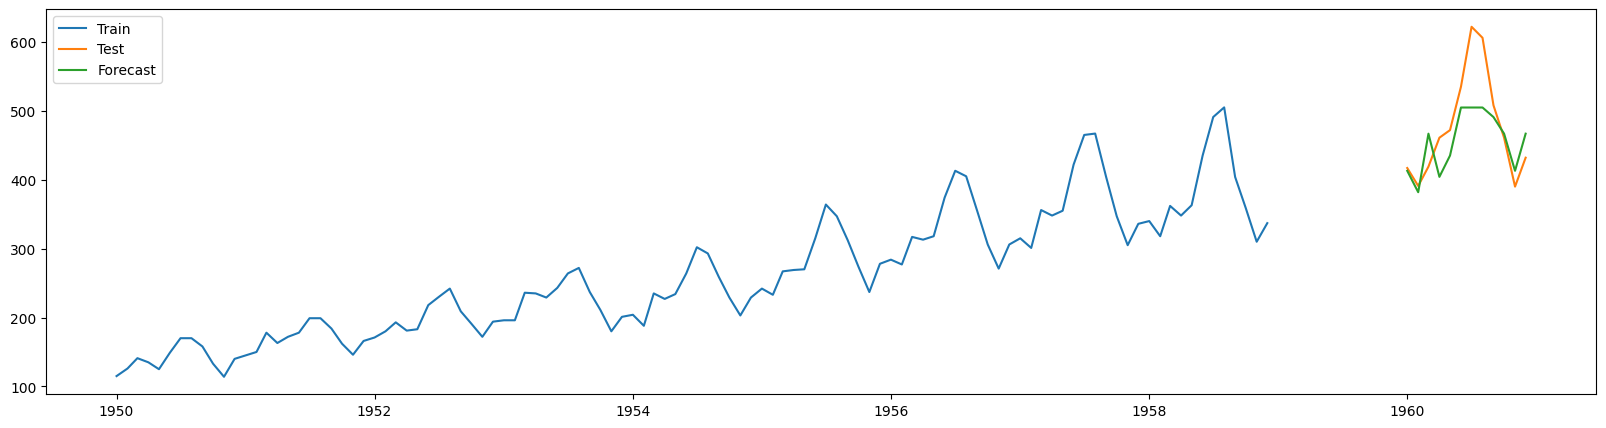

Total ROOT Mean squared error: 104.24480151603466


In [ ]:
splits = cross_validation(data, n_splits=5)
errr= []
for train, test in splits:
    train['passengers_lag'] = train['Passengers'].shift(lag)
    test['passengers_lag'] = test['Passengers'].shift(lag)
    train = train.dropna()
    test = test.dropna()
    X_train = train[['passengers_lag']]
    y_train = train['Passengers']
    X_test = test[['passengers_lag']]
    y_test = test['Passengers']
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(' ROOT Mean squared error:', np.sqrt(mse))
    errr.append(np.sqrt(mse))
    plt.figure(figsize=(20,5))
    plt.plot(train.index,y_train, label='Train')
    plt.plot(test.index,y_test, label='Test')
    plt.plot(test.index,y_pred, label = 'Forecast')
    plt.legend(loc='best')
    plt.show()
print('Total ROOT Mean squared error:', np.mean(errr))

## Report

The XGBOOST model typically requires a large amount of data in order to effectively leverage the variety of lags available and achieve high performance. This is because having more data allows the model to better identify patterns and relationships between the target variable and its historical values. Therefore, when working with XGBOOST, it is important to ensure that sufficient data is available to achieve the best possible results

- Fixed Partitioning: The XGBOOST regressor performed well on the fixed partition of the airline passengers dataset with a lag of 12, likely due to the significant amount of data available for training and testing.


- Cross Validation: cross-validation on the airline passengers dataset, the overall root mean squared error (RMSE) was higher than in the fixed partition This may be due to the limited information available in each fold of the data, which can make it more difficult for the XGBOOST model to accurately predict passenger numbers.

We couldn't apply it in roll forward as it take lag 12 and the window of roll forward was with size

# Conclusion

In [ ]:
rmse_results = pd.read_csv('/content/Time Series Results.csv')

In [ ]:
rmse_results

Technique  Fixed   Roll   Cross
0                        Simple Moving Average  113.8  55.38  139.60
1                                Naïve forcast  137.3  44.20  142.60
2                      Weighted Moving Average   84.6  52.40  183.00
3                    Linear Regression Average   74.7  55.40   80.00
4                       Classical Decompostion   60.0  54.70   84.10
5                             STL Decompostion   68.7  66.20   80.70
6                                        ARIMA  126.1  39.72  141.83
7                                      S-ARIMA   39.9  11.50   55.10
8                  Exponential Smothing Single  139.7  47.10  140.30
9         Exponential Smothing Double Additive  118.3  44.00   93.70
10  Exponential Smothing Double Multiplicative  107.6  43.70  104.90
11        Exponential Smothing Triple Additive   35.7  12.30   57.40
12  Exponential Smothing Triple Multiplicative   13.8  10.30   40.10
13                                  FB Prophet   40.3  31.50   45.40
14                           XGBOOST Regressor   53.1    NaN  104.20

Exponential Smothing Triple Multiplicative seems to be the best performing model in both long and short term forecasting. SARIMA also seems a logical choice for short term forecasting since it was able to capture the seasonality of the data.